# CLUSTER ANALYSIS OF TISSUE DATASETS FILTERED BY CLOCKS

# Approach:
To understand how the clock is affected by the type of tissue, we will perform cluster analysis using the tissue-specific datasets filtered from the full methylation dataset. We will use and compare several clustering algorithms (K-Mean, Hierarchical clustering and DBSCANN) to group the tissues based on the methylation levels of the CpG sites. We will then analyze the clusters to identify the tissues that have similar methylation patterns and identify CpG sites that are differentially methylated between the clusters.

# Goal
Measuring the similarity between tissues based on the methylation levels of the CpG sites can help us understand how the clock is affected by the type of tissue. By identifying tissues with similar methylation patterns, we can gain insights into the underlying biological processes that drive the aging process in different tissues.

STEPS:
- Feature Selection: Use the clock dataset to select the top CpGs identified by the clocks to be informative for age prediction. These CpGs will serve as features for clustering.
- Clustering: Apply a clustering algorithm to each tissue-specific dataset separately using the selected CpGs as features. 
- Cluster Analysis: Analyze the clusters to identify tissues with similar methylation patterns and CpGs that are differentially methylated between the clusters.
- Validation: Validate the stability and reproducibility of the clusters using appropriate methods such as bootstrapping or cross-validation.

NOTES:
Finding the best K: The K-means algorithm requires the number of clusters (K) to be specified in advance. To determine the optimal number of clusters, we will use the elbow method, silhouette score, and gap statistic. The best measure of K is the silhouette score, which is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

## 0. Load data and filter datasets by clocks (Clock1 so far...)

In [1]:
#### LOAD: libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns

import itertools
from itertools import combinations

from pathlib import Path

import matplotlib.cm as cm  
from matplotlib import colormaps as mcolors
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, jaccard_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, pairwise_distances
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.cluster.hierarchy import single, cophenet, linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, cityblock, squareform, euclidean
from scipy.stats import f_oneway


from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed, compute
from dask.distributed import Client, progress, LocalCluster
from dask.diagnostics import ProgressBar

import joblib

import itertools

In [2]:
#### LOAD: Functions

###############################################

def kmeans_clustering(X, k):

    """
    Perform k-means clustering on a dataset. Also calculates silhouette score and inertia. 
    Plot the elbow plot to determine the optimal number of clusters.

    Parameters:
    - X: Dataset to cluster.
    - k: Number of clusters to create.

    """

    try:
        # Initialize k-means clustering with current parameters
        kmeans = KMeans(n_clusters=k, random_state=42)
        
        # Fit the model to the data
        kmeans.fit(X)
        
        # Calculate silhouette score to evaluate the clustering
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        
        # Get inertia (sum of squared distances to the closest cluster center)
        inertia = kmeans.inertia_
        
        return [k, silhouette_avg, kmeans.cluster_centers_, kmeans.labels_, inertia]
    except Exception as e:
        return [k, None, None, None, None, str(e)]
    

###############################################

def hierarchical_clustering(X, method, metric):

    """
    Perform hierarchical clustering on a dataset. Also calculates cophenetic correlation and silhouette score.

    Parameters:
    - X: Dataset to cluster.
    - method: Linkage method to use.
    - metric: Distance metric to use.
    
    """

    try:
        # Perform hierarchical clustering
        Z = linkage(X, method=method, metric=metric)

        # Calculate the cophenetic correlation
        c, coph_dists = cophenet(Z, pdist(X))

        # Calculate the silhouette score
        labels = fcluster(Z, t=0.7 * np.max(Z[:, 2]), criterion='distance')  # Using distance criterion
        silhouette_avg = silhouette_score(X, labels)

        return ['Complete', method, metric, c, silhouette_avg, Z, labels]
    except ValueError as e:
        return ['Complete', method, metric, None, None, None, str(e)]

###############################################

# Add DBSCAN HERE

###############################################

def feature_analysis(tissue_name, dataset, labels):
    """
    Perform feature analysis on a dataset using different statistical tests.
    
    Args:
        tissue_name (str): Name of the tissue.
        dataset (pd.DataFrame): Dataset with CpGs as columns and samples as rows.
        labels (np.array): Cluster labels for each sample.
        
    Returns:
        pd.DataFrame: Feature scores and p-values for each statistical test.
    """
    
    # Convert dataset to numpy array
    X = dataset.values
    
    # Chi-squared test
    chi2_scores, chi2_pvalues = chi2(X, labels)
    
    # ANOVA F-value
    f_scores, f_pvalues = f_classif(X, labels)
    
    # Mutual Information
    mi_scores = mutual_info_classif(X, labels)
    
    # Create a dataframe with feature scores and p-values
    feature_scores = pd.DataFrame({
        'CpG': dataset.columns,
        'Chi2_Score': chi2_scores,
        'Chi2_Pvalue': chi2_pvalues,
        'F_Score': f_scores,
        'F_Pvalue': f_pvalues,
        'MI_Score': mi_scores
    })
    
    # Sort the dataframe by Chi2 score in descending order
    feature_scores = feature_scores.sort_values(by='Chi2_Score', ascending=False)
    
    return feature_scores



In [3]:
#### LOAD: Metadata
metadata = pd.read_csv('GSE223748_complete_metadata.csv')

In [4]:
#### LOAD: Complete methylation data

complete_methylation = pd.read_csv('GSE223748_datBetaNormalized.csv')
complete_methylation.rename(columns={'Unnamed: 0': 'CpG'}, inplace=True)

In [5]:
#### LOAD: Tissue-specific methylation datasets from the saved CSV files

folder_name = "Tissue Methylation"
tissue_files = os.listdir(folder_name) # Get a list of all files in the folder
tissues_df = metadata[['Sample', 'Tissue']]
tissues = tissues_df['Tissue'].unique() # Get a list of all tissues

# Load each CSV file into its own dataframe
for file in tissue_files:
    if file.endswith("_methylation_dataset.csv"):
        # Extract tissue name from file name
        tissue = file.split("_")[0]

        # Load CSV file into dataframe
        file_path = os.path.join(folder_name, file)
        globals()['{}_methylation_dataset'.format(tissue)] = pd.read_csv(file_path)

In [6]:
#### LOAD: Methylation data for the complete CpGs of each clock
clock1 = pd.read_csv('./Clocks Methylation Data/Clock1_Methylation_data_complete.csv')
# clock2 = pd.read_csv('./Clocks Methylation Data/Clock2_Methylation_data_complete.csv')
# clock3 = pd.read_csv('./Clocks Methylation Data/Clock3_Methylation_data_complete.csv')
# clock2_3 = pd.read_csv('./Clocks Methylation Data/Clock2_3_Overlap_Methylation_data_complete.csv')

In [15]:
clock1.shape

(335, 15044)

In [16]:
clock1.head()

CpG  202897220093_R01C01  202897220093_R02C01  202897220093_R03C01  \
0  cg11728741             0.068117             0.067774             0.066174   
1  cg24352905             0.036081             0.051498             0.053750   
2  cg08938156             0.038598             0.035016             0.033070   
3  cg13058338             0.044092             0.042869             0.055642   
4  cg26067250             0.072081             0.073122             0.074480   

   202897220093_R04C01  202897220093_R05C01  202897220093_R06C01  \
0             0.068007             0.068168             0.066324   
1             0.044476             0.052884             0.034006   
2             0.039462             0.036047             0.038373   
3             0.047772             0.048508             0.045878   
4             0.076515             0.072465             0.072201   

   202897220093_R01C02  202897220093_R02C02  202897220093_R03C02  ...  \
0             0.068542             0.067023             0.073910  ...   
1             0.038629             0.034521             0.041215  ...   
2             0.037440             0.034336             0.042841  ...   
3             0.049126             0.045214             0.050714  ...   
4             0.072929             0.072766             0.080162  ...   

   206139140103_R02C02  206139140103_R03C02  206139140103_R04C02  \
0             0.110101             0.094364             0.103115   
1             0.059211             0.052091             0.063619   
2             0.132353             0.151589             0.170453   
3             0.034318             0.039776             0.028211   
4             0.091394             0.087090             0.087236   

   206139140103_R05C02  206139140103_R06C02  206139140104_R01C01  \
0             0.082374             0.109176             0.099880   
1             0.055042             0.054033             0.067906   
2             0.166092             0.125154             0.119996   
3             0.029256             0.024757             0.032184   
4             0.085740             0.080525             0.075837   

   206139140104_R02C01  206139140104_R03C01  206139140104_R04C01  \
0             0.101242             0.098242             0.093631   
1             0.054027             0.054988             0.069833   
2             0.150663             0.141750             0.187928   
3             0.028561             0.029797             0.031891   
4             0.090453             0.088125             0.094802   

   206139140104_R05C01  
0             0.099830  
1             0.068214  
2             0.186769  
3             0.028859  
4             0.094790  

[5 rows x 15044 columns]

In [7]:
#### Filter the complete methylation dataset by the CpGs in Clock1
clock1_cpgs = clock1['CpG'].values
complete_methylation_dataset_clock1_filtered = complete_methylation[complete_methylation['CpG'].isin(clock1_cpgs)]
complete_methylation_dataset_clock1_filtered.shape

(335, 15044)

In [8]:
#### Filter the all tissues-specific datasets by the CpGs in Clock 1
clock1_cpgs = clock1['CpG'].values

for tissue in tissues:
    tissue_df = globals()['{}_methylation_dataset'.format(tissue)].copy()
    tissue_df_clock1 = tissue_df[tissue_df['CpG'].isin(clock1_cpgs)]
    globals()['{}_methylation_dataset_clock1_filtered'.format(tissue)] = tissue_df

# Note to self: the resulting variables will be named as follows: Blood_methylation_dataset_clock1_filtered

In [11]:
tissue_df.shape

(37554, 12)

In [12]:
tissue_df.head()

CpG  205619060032_R06C01  205619060033_R02C01  205619060033_R04C02  \
0  cg00000165             0.488798             0.505373             0.489065   
1  cg00001209             0.883412             0.887029             0.903491   
2  cg00001364             0.901876             0.885708             0.908280   
3  cg00001582             0.059739             0.071271             0.077362   
4  cg00002920             0.772465             0.823105             0.783889   

   205619060056_R06C01  205619060057_R02C01  205619060057_R04C02  \
0             0.469737             0.484719             0.491021   
1             0.871923             0.891195             0.922473   
2             0.883637             0.886127             0.903500   
3             0.068783             0.068217             0.070741   
4             0.790455             0.808720             0.803337   

   205619060091_R02C01  205619060091_R04C02  205619060092_R02C01  \
0             0.478863             0.462059             0.469509   
1             0.875508             0.854703             0.844823   
2             0.871643             0.876005             0.882339   
3             0.071112             0.071300             0.079408   
4             0.737033             0.820422             0.773415   

   205619060092_R04C02  205619060093_R06C01  
0             0.466235             0.476630  
1             0.868044             0.785026  
2             0.867274             0.871281  
3             0.067039             0.072427  
4             0.705897             0.657723

In [10]:
tissue_df_clock1.shape

(335, 12)

In [9]:
# Create a dataframe with the tissue names and respective filtered datasets

# List with tissue datasets
tissues = tissues_df['Tissue'].unique() # Get a list of all tissues
tissue_datasets_clock1 = pd.DataFrame(columns=['Tissue', 'Dataset']) # create a dataframe to store the datasets

# List of tissues not included
tissues_not_included = []

# fill the dictionary with dataset and respective tissue name
for tissue in tissues:

    # Check that the tissue has more than 10 samples
    if metadata[metadata['Tissue'] == tissue].shape[0] < 10:
        # add tissue name to not included list
        tissues_not_included.append(tissue)
        # print(f'{tissue} has less than 10 samples and will not be included.')
    else:
        tissue_datasets_clock1.loc[len(tissue_datasets_clock1)] = [tissue, globals()['{}_methylation_dataset_clock1_filtered'.format(tissue)]]
print('Tissues not included:', tissues_not_included)
print('Total number of tissues not included:', len(tissues_not_included))
tissue_datasets_clock1.head()

Tissues not included: ['Testis', 'Pancreas', 'Thyroid', 'Blubber', 'Ileum', 'Duodenum', 'Tendon', 'Mammary', 'TemporalCortex', 'Lamina', 'OccipitalCortex', 'ParietalCortex', 'MitralValve', 'AdrenalCortex', 'Sacrocaudalis', 'Cecum', 'Uterus', 'Jejunum', 'Larynx', 'SpinalCord', 'Suspensory', 'Cartilage', 'Astrocyte', 'Epidermis', 'Dermis', 'Maybe.Larynx']
Total number of tissues not included: 26


Tissue                                            Dataset
0  Cortex                CpG  202794570001_R01C01  202794...
1   Liver                CpG  202794570002_R01C01  202794...
2   Blood                CpG  202794570002_R01C02  202794...
3    Skin                CpG  202794570010_R01C01  202794...
4  Muscle                CpG  202894750009_R02C02  202894...

Tissues with less than 10 samples were removed from the analysis.

In [13]:
# Summary of the tissues used in the analysis

print('Total number of tissues:', len(tissues))
print('Number of tissues included:', tissue_datasets.shape[0])
print('Number of tissues not included:', len(tissues_not_included))
print('Tissues included not included:', tissues_not_included)


Total number of tissues: 70
Number of tissues included: 44
Number of tissues not included: 26
Tissues included not included: ['Testis', 'Pancreas', 'Thyroid', 'Blubber', 'Ileum', 'Duodenum', 'Tendon', 'Mammary', 'TemporalCortex', 'Lamina', 'OccipitalCortex', 'ParietalCortex', 'MitralValve', 'AdrenalCortex', 'Sacrocaudalis', 'Cecum', 'Uterus', 'Jejunum', 'Larynx', 'SpinalCord', 'Suspensory', 'Cartilage', 'Astrocyte', 'Epidermis', 'Dermis', 'Maybe.Larynx']


In [89]:
### Clustermaps of Tissue Datasets

# Create a folder to save the results
folder = r'./Heatmap Scripts/Tissue heatmaps'
os.makedirs(folder, exist_ok=True)

# Iterate over the tissue datasets and generate the heatmaps
for index, row in tissue_datasets.iterrows():
    tissue_name = row['Tissue']
    tissue_dataset = row['Dataset']
    
    # Transpose the dataset
    tissue_dataset_transposed = tissue_dataset.set_index('CpG').transpose()

    # Generate the heatmap
    clustermap = sns.clustermap(tissue_dataset_transposed, 
                                cmap='RdBu_r', 
                                metric='euclidean', 
                                row_cluster=True,
                                col_cluster=True,
                                z_score=None, 
                                standard_scale=None, 
                                figsize=(10, 8), 
                                vmin=0, vmax=1,  # Set the range of values for the colormap
                                cbar_kws={'label': 'CpGs\nBeta-value', 'orientation': 'vertical'})

    # Adjust the colorbar
    clustermap.cax.set_position([.85, .7, .03, .45])  # [left, bottom, width, height] - thinner and top right
    clustermap.cax.set_aspect(2)  # Make the colorbar taller

    # Update axis labels
    clustermap.ax_heatmap.set_xlabel('CpG')
    clustermap.ax_heatmap.set_ylabel('Sample')

    # Add the title above the clustering lines
    clustermap.fig.suptitle(f'{tissue_name}', x=0.5, y=1.05, ha='center', fontsize=16, fontweight='bold')

    # plt.show()

    # Save the plot
    filepath = os.path.join(folder, f'{tissue_name}_heatmap.png')
    try:
        clustermap.savefig(filepath)
        print(f"Saved heatmap for {tissue_name} at {filepath}")
        if os.path.exists(filepath):
            print(f"File successfully created: {filepath}. Size: {os.path.getsize(filepath)} bytes")
        else:
            print(f"Error: File not created at {filepath}")
    except Exception as e:
        print(f"Error saving heatmap for {tissue_name}: {str(e)}")

    # Close the plot to free up memory
    plt.close(clustermap.fig)


Saved heatmap for Cortex at ./Heatmap Scripts/Tissue heatmaps\Cortex_heatmap.png
File successfully created: ./Heatmap Scripts/Tissue heatmaps\Cortex_heatmap.png. Size: 597987 bytes
Saved heatmap for Liver at ./Heatmap Scripts/Tissue heatmaps\Liver_heatmap.png
File successfully created: ./Heatmap Scripts/Tissue heatmaps\Liver_heatmap.png. Size: 661268 bytes
Saved heatmap for Blood at ./Heatmap Scripts/Tissue heatmaps\Blood_heatmap.png
File successfully created: ./Heatmap Scripts/Tissue heatmaps\Blood_heatmap.png. Size: 660079 bytes
Saved heatmap for Skin at ./Heatmap Scripts/Tissue heatmaps\Skin_heatmap.png
File successfully created: ./Heatmap Scripts/Tissue heatmaps\Skin_heatmap.png. Size: 694858 bytes
Saved heatmap for Muscle at ./Heatmap Scripts/Tissue heatmaps\Muscle_heatmap.png
File successfully created: ./Heatmap Scripts/Tissue heatmaps\Muscle_heatmap.png. Size: 624088 bytes
Saved heatmap for Fibroblast at ./Heatmap Scripts/Tissue heatmaps\Fibroblast_heatmap.png
File successfully 

## 1. K-MEANS clutering of CpGs from all tissue datasets filtered by Clock1

### 1.1. K-Means Clustering of Full Methylation Dataset filtered by CpGs in Clock 1

RUN THIS LATER IN JACKS PC

In [ ]:
# #### [ RUN IN JACKS PC] Smaller dask chunks for faster computation (and prevent memory errors) 

# # Start a Dask client with a specific port
# client = Client(dashboard_address=':50129')

# # Select dataset
# df = complete_methylation_dataset_clock1_filtered

# # Instantiate the results DataFrame
# km_results_complete = pd.DataFrame(columns=['k', 'silhouette_score', 'cluster_centers', 'labels', 'inertia'])
# km_results_errors = pd.DataFrame(columns=['k', 'silhouette_score', 'cluster_centers', 'labels', 'inertia', 'error'])

# # Transpose the dataset so that the samples are rows and CpGs are columns (CpGs as features)
# complete_dataset = df.set_index('CpG').transpose()

# # Select the data (the first not removed as samples are indexed and therefore dont count as a column)
# X = complete_dataset.iloc[:,:]

# # Convert to Dask array with smaller chunks
# X_dask = da.from_array(X, chunks=(50, X.shape[1]))

# # Scatter the data to workers and broadcast it so that all workers have access to it. Prevents memory errors. 
# X_dask_future = client.scatter(X_dask, broadcast=True)

# # Define the range of k values
# k_values = range(2, 85)

# # Create a list of delayed tasks for each k value
# tasks = [kmeans_clustering(X_dask_future, k) for k in k_values]

# # Use Dask's ProgressBar to track progress
# with ProgressBar():
#     print("Starting computation...")
#     # Compute the tasks in parallel
#     results = compute(*tasks)
#     print("Computation completed.")

# # Separate successful results from errors
# successful_results = [res for res in results if res[-1] is None] # Filter out errors
# error_results = [res for res in results if res[-1] is not None] # Filter out successful results

# # Convert results to DataFrame
# km_results_complete = pd.DataFrame(results, columns=['k', 'silhouette_score', 'cluster_centers', 'labels', 'inertia'])

# # Convert error results to DataFrame
# km_results_errors = pd.DataFrame(results, columns=['k', 'silhouette_score', 'cluster_centers', 'labels', 'inertia', 'error'])

# # Sort the results by silhouette score and display the top results
# km_results_complete_sorted = km_results_complete.sort_values(by='silhouette_score', ascending=False)

# # Save the cluster labels and centers of the top-performing model
# top_model = km_results_complete_sorted.iloc[0]
# top_k = top_model['k']
# top_silhouette_score = top_model['silhouette_score']
# top_cluster_centers = top_model['cluster_centers']
# top_labels = top_model['labels']

# # Save top results using joblib for future plotting
# folder = './Cluster Analysis/KM'
# os.makedirs(folder, exist_ok=True)

# centers_path = os.path.join(folder, f'top_cluster_centers_KM_results_complete.joblib')
# joblib.dump(top_cluster_centers, centers_path)

# labels_path = os.path.join(folder, f'top_labels_KM_results_complete.joblib')
# joblib.dump(top_labels, labels_path)

# # Plot the elbow plot
# plt.figure(figsize=(10, 6))
# plt.plot(km_results_complete['k'], km_results_complete['inertia'], 'bo-')
# plt.xlabel('Number of clusters, k')
# plt.ylabel('Inertia')
# plt.title('Elbow Plot for K-Means Clustering')
# plt.show()

# # Shut down the Dask client
# client.close()

# km_results_complete_sorted.head()


In [ ]:
#### [RUN IN JACKS PC] Kmeans clustering of the complete methylation dataset - Smaller Chunks and Elbow plot

# # Start a Dask client
# client = Client() 
     
# # Select dataset
# df = complete_methylation_dataset_clock1_filtered

# # Instantiate the results DataFrame
# km_results_complete = pd.DataFrame(columns=['k', 'silhouette_score', 'cluster_centers', 'labels', 'inertia'])

# # Transpose the dataset so that the samples are rows and CpGs are columns (CpGs as features)
# complete_dataset = df.set_index('CpG').transpose()

# # Select the data (the first not removed as samples are indexed and therefore dont count as a column)
# X = complete_dataset.iloc[:,:]

# # Convert to Dask array
# X_dask = da.from_array(X, chunks=(50, X.shape[1]))

# # Define the range of k values
# k_values = range(2, 85)

# # Create a list of delayed tasks for each k value
# tasks = [kmeans_clustering(X_dask, k) for k in k_values]

# # Use Dask's ProgressBar to track progress
# with ProgressBar():
#     print("Starting computation...")
#     # Compute the tasks in parallel
#     results = compute(*tasks)
#     print("Computation completed.")

# # Separate successful results from errors
# successful_results = [res for res in results if res[-1] is None] # Filter out errors
# error_results = [res for res in results if res[-1] is not None] # Filter out successful results

# # Convert results to DataFrame
# km_results_complete = pd.DataFrame(results, columns=['k', 'silhouette_score', 'cluster_centers', 'labels', 'inertia'])

# # Convert error results to DataFrame
# km_results_errors = pd.DataFrame(results, columns=['k', 'silhouette_score', 'cluster_centers', 'labels', 'inertia', 'error'])

# # Sort the results by silhouette score and display the top results
# km_results_complete_sorted = km_results_complete.sort_values(by='silhouette_score', ascending=False)

# # Save the cluster labels and centers of the top-performing model
# top_model = km_results_complete_sorted.iloc[0]
# top_k = top_model['k']
# top_silhouette_score = top_model['silhouette_score']
# top_cluster_centers = top_model['cluster_centers']
# top_labels = top_model['labels']

# # Save top results using joblib for future plotting
# folder = './Cluster Analysis/KM'
# os.makedirs(folder, exist_ok=True)

# centers_path = os.path.join(folder, f'top_cluster_centers_KM_results_complete.joblib')
# joblib.dump(top_cluster_centers, centers_path)

# labels_path = os.path.join(folder, f'top_labels_KM_results_complete.joblib')
# joblib.dump(top_labels, labels_path)

# # Plot the elbow plot
# plt.figure(figsize=(10, 6))
# plt.plot(km_results_complete['k'], km_results_complete['inertia'], 'bo-')
# plt.xlabel('Number of clusters, k')
# plt.ylabel('Inertia')
# plt.title('Elbow Plot for K-Means Clustering')
# plt.show()

# # Shut down the Dask client
# client.close()

# km_results_complete_sorted.head()

In [ ]:
### [RUN IN JACKS PC] Scatter plot of KM clustering of complete methylation dataset

# # Load the top cluster centers and labels
# folder = './Cluster Analysis/KM'
# top_cluster_centers = joblib.load(os.path.join(folder, 'top_cluster_centers_KM_results_complete.joblib'))
# top_labels = joblib.load(os.path.join(folder, 'top_labels_KM_results_complete.joblib'))

# df= complete_methylation_dataset_clock1_filtered

# # Transpose the dataset so that the samples are rows and CpGs are columns (CpGs as features)
# complete_dataset = df.set_index('CpG').transpose()

# # Select the data (excluding the first column if it's not part of the features)
# X = complete_dataset.iloc[:, :]

# # Reduce the data to 2D using PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Create a DataFrame with the PCA results and labels
# pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
# pca_df['Cluster'] = top_labels

# # Plot the data using seaborn
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=pca_df, legend=False)
# plt.title('Scatter Plot of Top Performing K-Means Clustering')
# plt.show()


### 1.2. K-Means clustering of tissue datasets filtered by CpGs in Clock 1

In [63]:
### Kmeans clustering of tissue datasets filtered by Clock 1 CpGs

# Results dataframe
km_results = pd.DataFrame(columns=['Tissue', 'k', 'silhouette_score', 'cluster_centers', 'cluster_labels', 'sum_of_labels', 'total_features', 'dataset_shape'])
km_results_errors = pd.DataFrame(columns=['Tissue', 'k', 'Error'])

# Create directories to save cluster centers and labels
base_folder = './Cluster Analysis/KM'
os.makedirs(base_folder, exist_ok=True)

# Loop through all tissue datasets
for index, row in tissue_datasets.iterrows():
    tissue_name = row['Tissue']
    tissue_dataset = row['Dataset']

    # Transpose the dataset so that CpGs are columns and samples are rows
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    # Get shape of the dataset
    shape = tissue_dataset.shape

    # Check if there are enough samples for clustering
    if tissue_dataset.shape[0] < 2:
        # Save the tissue name and k value that caused the error
        km_results_errors.loc[len(km_results_errors)] = [tissue_name, None, "Not enough samples for clustering"]
        continue
    
    # Split the data into training and testing sets for k-means
    X = tissue_dataset.iloc[:, :]  # All samples, all CpG features

    best_silhouette_score = -1
    best_k = None
    best_cluster_centers = None
    best_labels = None

    # Train the model and test different values of k
    k_values = range(2, 20)
    
    for k in k_values:
        try:
            # Initialize k-means clustering with current parameters
            kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
            
            # Fit the model to your data
            kmeans.fit(X)
            
            # Calculate silhouette score to evaluate the clustering
            silhouette_avg = silhouette_score(X, kmeans.labels_)

            # Update the best model if the current one is better
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_k = k
                best_cluster_centers = kmeans.cluster_centers_
                # best_labels = kmeans.labels_
                best_labels = kmeans.labels_

        except ValueError as e:
            # Save the tissue name and k value that caused the error, and save the error message as string
            km_results_errors.loc[len(km_results_errors)] = [tissue_name, k, str(e)]
            continue
    
    # Save the best results for the current tissue
    if best_k is not None:
        km_results.loc[len(km_results)] = [tissue_name, best_k, best_silhouette_score, best_cluster_centers, best_labels, len(best_labels), tissue_dataset.shape[1], shape]
        
        # Save cluster centers and labels using joblib
        tissue_folder = os.path.join(base_folder, tissue_name)
        os.makedirs(tissue_folder, exist_ok=True)
        
        centers_path = os.path.join(tissue_folder, f'km_{tissue_name}_best_cluster_centers_k{best_k}.joblib')
        labels_path = os.path.join(tissue_folder, f'km_{tissue_name}_best_cluster_labels_k{best_k}.joblib')
        
        joblib.dump(best_cluster_centers, centers_path)
        joblib.dump(best_labels, labels_path)

# Sort results by silhouette score
km_results_tissues = km_results.sort_values(by='silhouette_score', ascending=False)

# Display the results
km_results_tissues.head()

# takes aprox 20 seconds to run

Tissue  k  silhouette_score  \
23  Keratinocyte  2          0.761379   
34      Placenta  2          0.712324   
37            ES  3          0.707973   
11    Cerebellum  6          0.699447   
20    BoneMarrow  2          0.694624   

                                      cluster_centers  \
23  [[0.884032409908354, 0.848174096295728, 0.9590...   
34  [[0.679652781261466, 0.8947433740459854, 0.941...   
37  [[0.8868490267524836, 0.7143812713685813, 0.78...   
11  [[0.8646775658643245, 0.8908843020879965, 0.96...   
20  [[0.852834988056284, 0.9032279735735042, 0.924...   

                                       cluster_labels  sum_of_labels  \
23  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             22   
34  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             47   
37  [2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             38   
11  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...            367   
20  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             30   

    total_features dataset_shape  
23             335     (22, 335)  
34             335     (47, 335)  
37             335     (38, 335)  
11             335    (367, 335)  
20             335     (30, 335)

In [64]:
km_results_errors.head()

Tissue   k                                              Error
0      SVZ  19  Number of labels is 19. Valid values are 2 to ...
1  Bladder  15  Number of labels is 15. Valid values are 2 to ...
2  Bladder  16           n_samples=15 should be >= n_clusters=16.
3  Bladder  17           n_samples=15 should be >= n_clusters=17.
4  Bladder  18           n_samples=15 should be >= n_clusters=18.

In [65]:
print('Number of tissue datasets for which clustering was not done due to low number of samples:', len(km_results_errors[km_results_errors['Error'] == 'Not enough samples for clustering']))

Number of tissue datasets for which clustering was not done due to low number of samples: 0


In [66]:
print('Datasets that were not clustered due to low number of samples:\n', km_results_errors[km_results_errors['Error'] == 'Not enough samples for clustering'])

Datasets that were not clustered due to low number of samples:
 Empty DataFrame
Columns: [Tissue, k, Error]
Index: []


In [67]:
print('Number of combinations for which the dataset had less samples than Ks being tested:',
      len(km_results_errors[km_results_errors['Error'].str.contains('n_clusters')]))

Number of combinations for which the dataset had less samples than Ks being tested: 57


c:\Users\Catia Antunes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Catia Antunes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Catia Antunes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Catia Antunes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Catia Antunes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted w

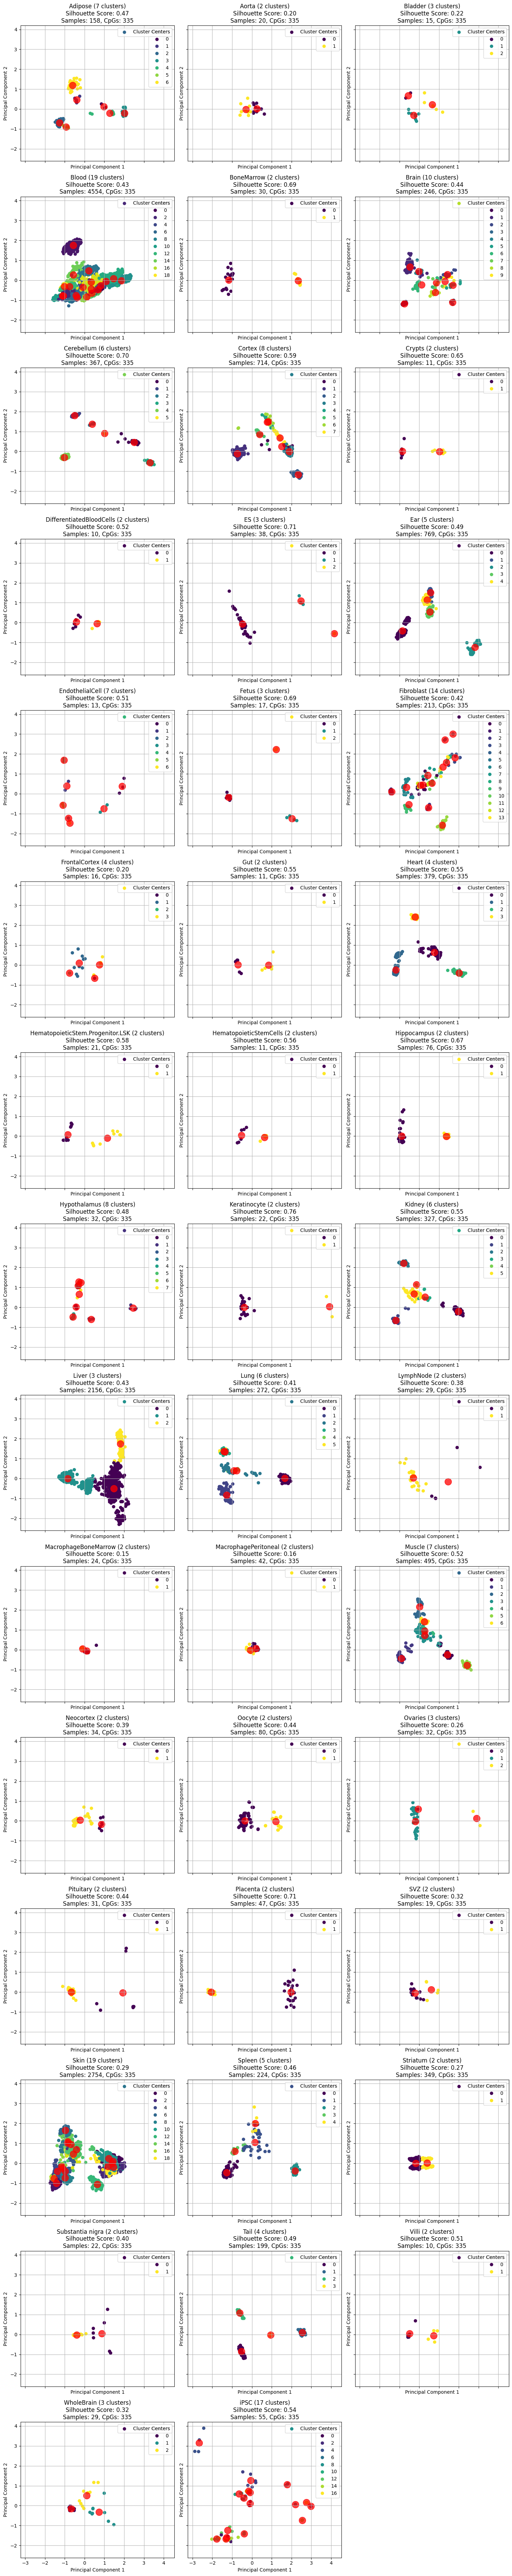

In [69]:
### Scatter plot of KM clustering of tissue datasets filtered by Clock 1 CpGs - With PCA

# Folder where scatter plots will be saved
folder = './Cluster Analysis/KM'

# Sort km_results_tissues by Tissue name
km_results_tissues = km_results_tissues.sort_values(by='Tissue')

# Create a figure with subplots for each tissue
num_tissues = len(km_results_tissues)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_tissues - 1) // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten axs for easier indexing

# Loop through all tissues
subplot_idx = 0  # Keep track of the current subplot
for idx, (index, row) in enumerate(km_results_tissues.iterrows()):
    tissue_name = row['Tissue']
    
    # Debug print to check the tissue being processed
    #print(f"Processing tissue: {tissue_name}")
    
    # Ensure there is a corresponding entry in km_results
    best_k_entry = km_results_tissues[km_results_tissues['Tissue'] == tissue_name]
    if best_k_entry.empty:
        print(f"No best k value found for tissue: {tissue_name}")
        continue  # Skip this tissue if no best k value is found

    # Get the best k value and silhouette score for the tissue
    best_k = best_k_entry['k'].values[0]
    silhouette = best_k_entry['silhouette_score'].values[0]

    # Load the saved cluster centers and labels
    tissue_folder = os.path.join('./Cluster Analysis/KM', tissue_name)
    centers_path = os.path.join(tissue_folder, f'km_{tissue_name}_best_cluster_centers_k{best_k}.joblib')
    labels_path = os.path.join(tissue_folder, f'km_{tissue_name}_best_cluster_labels_k{best_k}.joblib')

    if not os.path.exists(centers_path) or not os.path.exists(labels_path):
        print(f"Files do not exist for tissue: {tissue_name}")
        continue  # Skip if the files do not exist

    cluster_centers = joblib.load(centers_path)
    labels = joblib.load(labels_path)

    # Transpose the dataset so that CpGs are columns and samples are rows
    tissue_dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name].iloc[0]['Dataset']
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    # Check if there are enough samples for clustering
    if tissue_dataset.shape[0] < 2:
        print(f"Not enough samples for tissue: {tissue_name}")
        continue

    # Split the data into training and testing sets for k-means
    X = tissue_dataset.iloc[:, :]  # All samples, all CpG features

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    cluster_centers_pca = pca.transform(cluster_centers)

    # Calculate subplot position so we can access the correct axis for plotting and remove unused subplots
    ax = axs[subplot_idx]

    # Plot the data
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    ax.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', s=200, alpha=0.75)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'{tissue_name} ({best_k} clusters)\nSilhouette Score: {silhouette:.2f}\nSamples: {tissue_dataset.shape[0]}, CpGs: {tissue_dataset.shape[1]}')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.legend(['Cluster Centers'], loc='upper right')
    ax.grid()

    # Save the individual tissue plot
    tissue_folder = os.path.join(folder, tissue_name)
    os.makedirs(tissue_folder, exist_ok=True)
    fig_tissue, ax_tissue = plt.subplots(figsize=(8, 6))
    scatter_tissue = ax_tissue.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    ax_tissue.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', s=200, alpha=0.75)
    ax_tissue.set_xlabel('Principal Component 1')
    ax_tissue.set_ylabel('Principal Component 2')
    ax_tissue.set_title(f'{tissue_name} ({best_k} clusters)\nSilhouette Score: {silhouette:.2f}\nSamples: {tissue_dataset.shape[0]}, CpGs: {tissue_dataset.shape[1]}')
    legend_tissue = ax_tissue.legend(*scatter_tissue.legend_elements(), title="Clusters")
    ax_tissue.add_artist(legend_tissue)
    ax_tissue.legend(['Cluster Centers'], loc='upper right')
    ax_tissue.grid()
    fig_tissue.savefig(os.path.join(tissue_folder, f'{tissue_name}_scatter_plot.png'))
    plt.close(fig_tissue)

    subplot_idx += 1

# Remove any unused subplots
for i in range(subplot_idx, len(axs)):
    axs[i].set_visible(False)

# Adjust the layout
plt.tight_layout()

# Save the combined figure
combined_plot_path = os.path.join(folder, 'combined_scatterplots_pca_kmeans.png')
fig.savefig(combined_plot_path)

plt.show()


In [ ]:
## KM Feature Analysis for each tissue dataset

# Select folder
base_folder = './Cluster Analysis/KM/FEATURE ANALYSIS/'

# Perform feature analysis for each tissue
for index, row in km_results_tissues.iterrows():
    tissue_name = row['Tissue']
    labels = row['cluster_labels']

    # load the dataset
    dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].iloc[0]

    # Transpose the dataset so that features are rows and samples are columns
    dataset = dataset.set_index('CpG').transpose()
    
    # Perform feature analysis
    feature_scores = feature_analysis(tissue_name, dataset, labels)
    
    # Save feature scores to a file
    os.makedirs(base_folder, exist_ok=True)
    output_path = os.path.join(base_folder, f'{tissue_name}_feature_scores.csv')
    feature_scores.to_csv(output_path, index=False)

# Display the feature scores for the 
feature_scores.head()

# takes aprox 1m 50 seconds to run

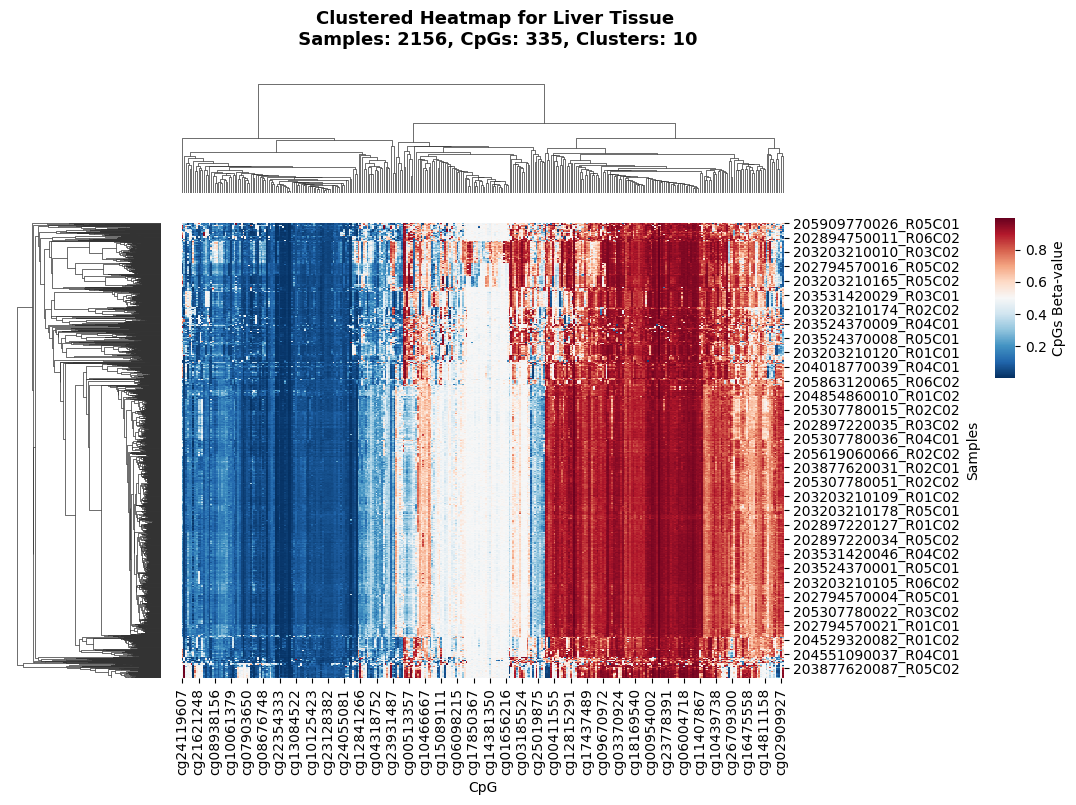

In [59]:
### heatmaps test [ probably remove later]

# folder where to save the CpG clustering results
folder = './Cluster Analysis/Heatmaps'

# Loop through the best K-means results for each tissue
for _, row in km_results_tissues[km_results_tissues['Tissue']=='Liver'].iterrows(): # _ stands for the index of the row
    
    tissue_name = row['Tissue']
    k = row['k']
    labels = row['cluster_labels']

    # Load the best cluster centers and labels
    folder = './Cluster Analysis/KM'
    tissue_folder = os.path.join(folder, tissue_name)
    centers_path = os.path.join(tissue_folder, f'km_{tissue_name}_best_cluster_centers_k{k}.joblib')
    labels_path = os.path.join(tissue_folder, f'km_{tissue_name}_best_cluster_labels_k{k}.joblib')
    labels = joblib.load(labels_path)
    
    # Get the tissue-specific dataset
    tissue_dataset = tissue_datasets.loc[tissue_datasets['Tissue'] == tissue_name, 'Dataset'].iloc[0]
    
    # Transpose the dataset so that CpGs are columns and samples are rows
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    # Skip if tissue dataset is empty or smallet than 2 samples
    if tissue_dataset.shape[0] < 2:
        continue

    # Create the clustered heatmap
    # clustered_heatmaps_only(tissue_name, tissue_dataset, labels, 'K-Means')
    clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, folder)

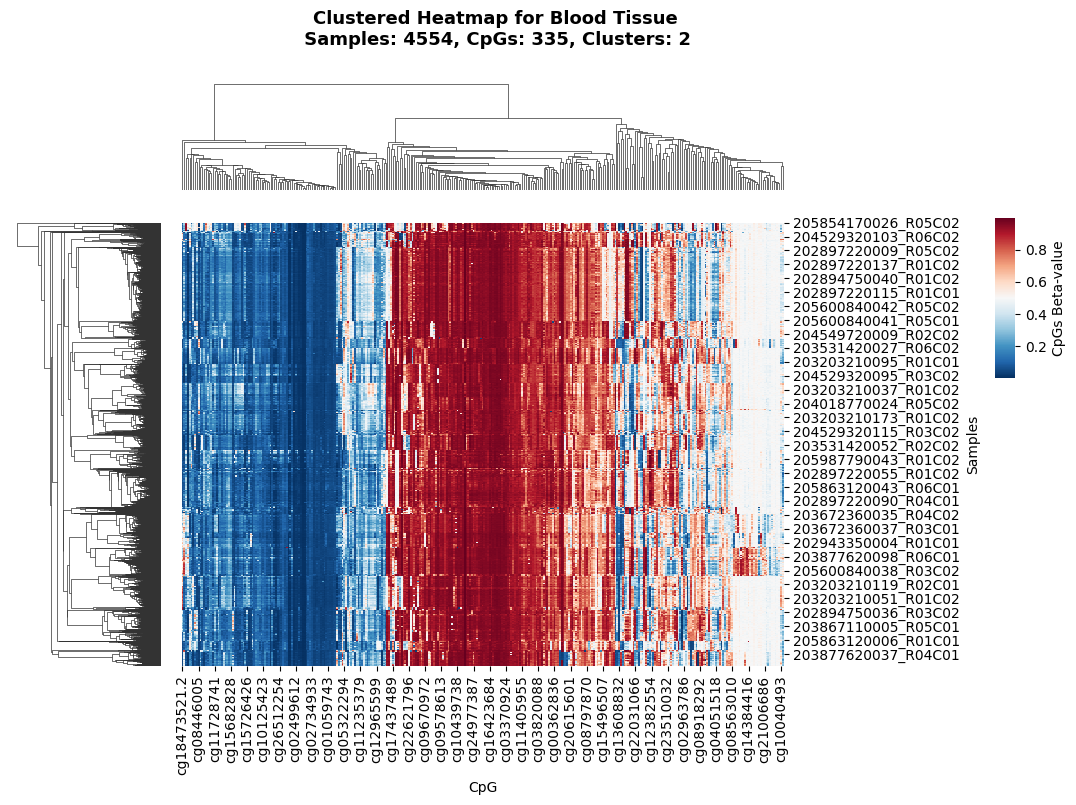

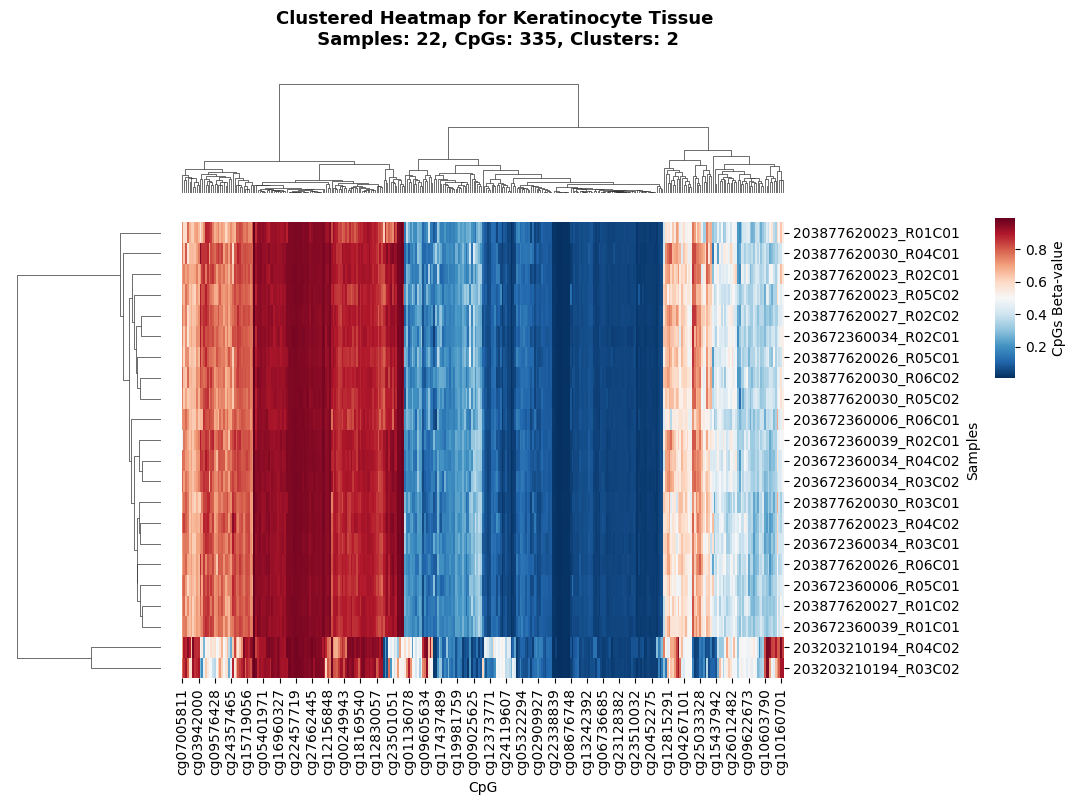

In [48]:
### [Original] Clustered Heatmaps & CpG exporting   ---- Need to sort this and move it somewhere else. This is not model specific. The results will be the same reagrdless of the model used.

# folder where to save the CpG clustering results
folder = './Cluster Analysis/Heatmaps/TEST'

# Loop through the best K-means results for each tissue
for _, row in km_results_tissues.head(2).iterrows(): # _ stands for the index of the row
    
    tissue_name = row['Tissue']
    k = row['k']
    labels = row['cluster_labels']
    
    # Get the tissue-specific dataset
    tissue_dataset = tissue_datasets.loc[tissue_datasets['Tissue'] == tissue_name, 'Dataset'].iloc[0]
    
    # Transpose the dataset so that CpGs are columns and samples are rows
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    # Skip if tissue dataset is empty or smallet than 2 samples
    if tissue_dataset.shape[0] < 2:
        continue

    # Create the clustered heatmap
    # clustered_heatmaps_only(tissue_name, tissue_dataset, labels, 'K-Means')
    clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, folder)

In the cortex? case, the K-means clustering grouped the samples into 8 clusters based on their CpG profiles (Features). However, when hierarchical clustering was performed on the CpGs, it found only 2 major clusters of CpGs that have similar methylation patterns across the 8 sample clusters. This outcome suggests that while the samples can be separated into 8 distinct groups based on their overall CpG profiles, the CpGs themselves may exhibit only two major patterns of co-methylation or co-expression across these sample clusters.

## 2. Hierarchical clustering analysis of all tissue datasets filtered by Clock1

### 2.1. Hierarchical Clustering of Full Methylation Dataset filtered by CpGs in Clock 1

RUN THIS LATER. ITS PROBABLY GOING TO KILL THE KERNEL. 

CONSIDER SCRAPING THIS SECTION AND USE THE KM AS TEMPLATES ON CHATGPT TO MAKE OUTPUTS UNIFORM

In [ ]:
#### Hierarchical Clustering of the complete methylation dataset

# # Function to perform hierarchical clustering and calculate metrics
# @delayed
# def hierarchical_clustering(X, dataset, method, metric):
#     try:
#         # Perform hierarchical clustering
#         Z = linkage(X, method=method, metric=metric)

#         # Calculate the cophenetic correlation
#         c, coph_dists = cophenet(Z, pdist(X))

#         # Calculate the silhouette score
#         labels = fcluster(Z, t=0.7 * np.max(Z[:, 2]), criterion='distance')  # Using distance criterion
#         silhouette_avg = silhouette_score(X, labels)

#         return [dataset, method, metric, c, silhouette_avg, Z, labels]
#     except ValueError as e:
#         return [dataset, method, metric, None, None, None, str(e)]

# # Instantiate the results DataFrame
# hc_results_complete = pd.DataFrame(columns=['Dataset', 'Method', 'Metric', 'Cophonetic Correlation', 'Silhouette Score', 'Z', 'Cluster Labels'])
# hc_results_complete_errors = pd.DataFrame(columns=['Dataset', 'Method', 'Metric', 'Error'])

# # Load dataset
# df = complete_methylation_dataset_clock1_filtered

# # name of the dataset
# dataset = 'Complete Methylation Dataset'

# # Start a Dask client
# client = Client()

# # Transpose the dataset so that the samples are rows and CpGs are columns (CpGs as features)
# complete_dataset = df.set_index('CpG').transpose()

# # Select the data
# X = complete_dataset.iloc[:, :]  # All samples, all CpG features

# # Convert to Dask array
# X_dask = da.from_array(X, chunks=(50, X.shape[1]))

# # Scatter the data to workers and broadcast it so that all workers have access to it
# X_dask_future = client.scatter(X_dask, broadcast=True)

# # Instantiate the methods and metrics to be tested
# methods = ['single', 'complete', 'average', 'ward']
# metrics = ['euclidean', 'cityblock', 'cosine']

# # Create a list of delayed tasks for each method and metric combination
# tasks = []
# for method in methods:
#     for metric in metrics:
#         # Skip incompatible method-metric combinations
#         if method == 'ward' and metric != 'euclidean':
#             continue
#         tasks.append(hierarchical_clustering(X_dask_future, method, metric))

# # Use Dask's ProgressBar to track progress
# with ProgressBar():
#     # Compute the tasks in parallel
#     results = compute(*tasks)
#     print("Computation completed.")

# # Separate successful results from errors
# for result in results:
#     if result[3] is not None:
#         hc_results_complete.loc[len(hc_results_complete)] = result
#     else:
#         hc_results_complete_errors.loc[len(hc_results_complete_errors)] = result[:3] + [result[6]]

# # Sort the results by silhouette score and display the top results
# hc_results_complete_sorted = hc_results_complete.sort_values(by='Silhouette Score', ascending=False)
# # print(hc_results_complete_sorted.head())

# # Save the cluster labels and linkage matrix of the top-performing model
# top_model = hc_results_complete_sorted.iloc[0]
# top_method = top_model['Method']
# top_metric = top_model['Metric']
# top_cophonetic_correlation = top_model['Cophonetic Correlation']
# top_silhouette_score = top_model['Silhouette Score']
# top_Z = top_model['Z']
# top_labels = top_model['Cluster Labels']

# # Save top results using joblib for future plotting
# folder = './Cluster Analysis/HC'
# os.makedirs(folder, exist_ok=True)

# joblib.dump(top_Z, f'{folder}/top_linkage_matrix_hc_results_complete.pkl')
# joblib.dump(top_labels, f'{folder}/top_labels_hc_results_complete.pkl')

# # Shut down the Dask client
# client.close()

# # Display the results
# hc_results_complete_sorted.head()

In [ ]:
# ### Scatter plot of hierarchical clustering of complete methylation dataset

# # Load the top linkage matrix and labels
# top_Z = joblib.load(f'{folder}/top_linkage_matrix_hc_results_complete.pkl')
# top_labels = joblib.load(f'{folder}/top_labels_hc_results_complete.pkl')

# # Transpose the dataset so that the samples are rows and CpGs are columns (CpGs as features)
# complete_dataset = df.set_index('CpG').transpose()

# # Select the data
# X = complete_dataset.iloc[:, :]  # All samples, all CpG features

# # Reduce the data to 2D using PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Create a DataFrame with the PCA results and labels
# pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
# pca_df['Cluster'] = top_labels

# # Plot the data using seaborn
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=pca_df, legend=False)
# plt.title('Hierarchical Clustering of Complete Methylation Dataset')
# plt.show()

In [ ]:
# ### Unabridged hierarchical clustering of the complete dataset   - To remove

# # Instantiate the results DataFrame
# hc_results_complete = pd.DataFrame(columns=['Tissue', 'Method', 'Metric', 'Cophonetic Correlation', 'Silhouette Score', 'Z', 'Cluster Labels'])
# hc_results_complete_errors = pd.DataFrame(columns=['Tissue', 'Method', 'Metric', 'Error'])

# # Transpose the dataset so that the samples are rows and CpGs are columns (CpGs as features)
# complete_dataset = complete_methylation_dataset_clock1_filtered.set_index('CpG').transpose()
# complete_dataset.shape

# # Select the data
# X = complete_dataset.iloc[:, :] # All samples, all CpG features

# # Instatiate the metrics and methods to be tested
# methods = ['single', 'complete', 'average', 'ward']
# metrics = ['euclidean', 'cityblock', 'cosine']

# for method in methods:

#     for metric in metrics:

#         try:
#             # Add an exception for the ward method, which only works with euclidean metric
#             if method == 'ward' and metric != 'euclidean':
#                 continue

#             # Perform hierarchical clustering
#             Z = linkage(X, method=method, metric=metric)

#             # Calculate the cophenetic correlation
#             c, coph_dists = cophenet(Z, pdist(X))

#             # Calculate the silhouette score
#             labels = fcluster(Z, t=0.7*np.max(Z[:, 2]), criterion='distance') # maxclust vs distance???

#             # Silhouette score
#             silhouette_avg = silhouette_score(X, labels)

#             # Add results to result DataFrame
#             hc_results_complete.loc[len(hc_results_complete)] = ['Complete', method, metric, c, silhouette_avg, Z, labels]

#         except ValueError as e:
#             # print(f"Error with method={method} and metric={metric}: {e}")
#             # save the tissue name and k value that caused the error, and save the error message as string
#             hc_results_complete_errors.loc[len(hc_results_complete_errors)] = ['Complete', method, metric, str(e)]
#             continue

# # Print the results
# hc_results_complete.head()

In [ ]:
### HC of complete methylation dataset with PCA, sampling and Dask of the complete dataset

# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from scipy.spatial.distance import pdist
# from dask import delayed, compute
# import dask.dataframe as dd

# # Function to perform clustering
# @delayed
# def hierarchical_clustering(X_sample, dataset, method, metric):

#     """
#     Perform hierarchical clustering on the given data.

#     Parameters:
#     - X_sample: The data to be clustered.
#     - method: The linkage method to be used.
#     - metric: The distance metric to be used.

#     """
#     try:
#         # Add an exception for the ward method, which only works with euclidean metric
#         if method == 'ward' and metric != 'euclidean':
#             return method, metric, None, None, None, None

#         # Perform hierarchical clustering
#         Z = linkage(X_sample, method=method, metric=metric)
        
#         # Calculate the cophenetic correlation
#         c, coph_dists = cophenet(Z, pdist(X_sample))

#         # Calculate the silhouette score
#         labels = fcluster(Z, t=0.7*np.max(Z[:, 2]), criterion='distance')
#         silhouette_avg = silhouette_score(X_sample, labels)

#         # Return the results
#         return method, metric, c, silhouette_avg, Z, labels
    
#     # Add an exception for any errors that may occur
#     except ValueError as e:
#         return method, metric, str(e), None, None, None

# # Data
# complete_dataset = complete_methylation_dataset_clock1_filtered.set_index('CpG').transpose()

# # dataset name
# dataset = 'Complete Methylation Dataset'

# # Instantiate the results DataFrame
# hc_results_complete = pd.DataFrame(columns=['Dataset', 'Method', 'Metric', 'Cophonetic Correlation', 'Silhouette Score', 'Z', 'Cluster Labels'])
# hc_results_complete_errors = pd.DataFrame(columns=['Dataset', 'Method', 'Metric', 'Error'])

# # Transpose the dataset so that the samples are rows and CpGs are columns (CpGs as features)
# complete_dataset = complete_methylation_dataset_clock1_filtered.set_index('CpG').transpose()

# # Select the data
# X = complete_dataset.values

# # Dimensionality reduction
# pca = PCA(n_components=50)
# X_reduced = pca.fit_transform(X)

# # Convert to Dask array with smaller chunks
# X_dask = da.from_array(X_reduced, chunks=(50, X_reduced.shape[1]))

# # Scatter the data to workers and broadcast it so that all workers have access to it
# X_dask_future = client.scatter(X_dask, broadcast=True)

# # # Sampling  - use if needed
# # sample_size = min(1000, X_reduced.shape[0])
# # X_sample = X_reduced[np.random.choice(X_reduced.shape[0], sample_size, replace=False)]


# # Instantiate the metrics and methods to be tested
# methods = ['single', 'complete', 'average', 'ward']
# metrics = ['euclidean', 'cityblock', 'cosine']

# # Create a list of delayed tasks
# tasks = [hierarchical_clustering(X_dask_future, method, metric) for method in methods for metric in metrics]

# # Use Dask's ProgressBar to track progress
# with ProgressBar():
#     print("Starting computation...")
#     # Compute the tasks in parallel using Dask
#     results = compute(*tasks)
#     print("Computation completed.")

# # Add results to DataFrame
# for method, metric, c, silhouette_avg, Z, labels in results:
#     if c is not None:
#         hc_results_complete.loc[len(hc_results_complete)] = [dataset, method, metric, c, silhouette_avg, Z, labels]
#     else:
#         hc_results_complete_errors.loc[len(hc_results_complete_errors)] = [dataset, method, metric, silhouette_avg]

# # Convert the results to Dask DataFrame and compute the final result
# dd_results_complete = dd.from_pandas(hc_results_complete, npartitions=1)
# dd_results_complete_errors = dd.from_pandas(hc_results_complete_errors, npartitions=1)

# # Print the results
# print(dd_results_complete.compute().head())
# print(dd_results_complete_errors.compute().head())

In [ ]:
# ### Plot the dendrogram of the complete dataset

# # Select the best method and metric
# hc_best_results_complete = hc_results_complete.sort_values(by='Silhouette Score', ascending=False).iloc[0]
# method = hc_best_results_complete['Method']
# metric = hc_best_results_complete['Metric']

# # Perform hierarchical clustering with the best method and metric
# Z = hc_best_results_complete['Z']

# # Plot the dendrogram
# plt.figure(figsize=(15, 5))
# dendrogram(Z, labels=complete_dataset.index, orientation='top')
# plt.title(f'Hierarchical Clustering Dendrogram\nMethod: {method}, Metric: {metric}')
# plt.xlabel('Samples')
# plt.ylabel('Distance')
# plt.show()


### 2.2. Hierarchical clustering of tissue datasets filtered by CpGs in Clock 1

HC clustering without selecting best params. instead has several eval metric so I can ort through those and check if they make any difference.

In [ ]:
#### Hierarchical Clustering of tissue datasets filtered by Clock 1 CpGs  --- Other eval metrics but not auto selection of best method and metric. All combinations are saved. To be used with save_best_results function().

# Initialize result dataframes
hc_results = pd.DataFrame(columns=['Tissue', 'best_method', 'best_metric', 'best_num_clusters', 'silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score', 'cluster_labels','Z'])
hc_results_errors = pd.DataFrame(columns=['Tissue', 'method', 'metric', 'num_clusters', 'error'])

# Loop through all tissue datasets
for index, row in tissue_datasets.iterrows():
    tissue_name = row['Tissue']
    tissue_dataset = row['Dataset']

    # Transpose the dataset so that CpGs are columns and samples are rows
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    # Get shape of the dataset
    shape = tissue_dataset.shape

    # Check if there are enough samples for clustering
    if tissue_dataset.shape[0] < 2:
        # Save the tissue name and method/metric that caused the error
        hc_results_errors.loc[len(hc_results_errors)] = [tissue_name, None, None, None, "Not enough samples for clustering"]
        continue
    
    # Split the data into training and testing sets for clustering
    X = tissue_dataset.iloc[:, :]  # All samples, all CpG features

    # Train the model and test different methods of linkage and distance metrics
    methods = ['single', 'complete', 'average', 'ward']
    metrics = ['euclidean', 'cityblock', 'cosine']
    num_clusters_range = range(2, 6)  # Example range of number of clusters to test
    
    for num_clusters in num_clusters_range:
        for method in methods:
            for metric in metrics:
                
                # Ward linkage only works with Euclidean distance
                if method == 'ward' and metric != 'euclidean':
                    continue
                try:
                    # Initialize Hierarchical clustering with current parameters
                    hierarchical = AgglomerativeClustering(linkage=method, metric=metric, n_clusters=num_clusters)
                    
                    # Fit the model to your data
                    hierarchical.fit(X)
                    
                    # Calculate the evaluation metrics
                    labels = hierarchical.labels_
                    silhouette_avg = silhouette_score(X, labels)
                    davies_bouldin_avg = davies_bouldin_score(X, labels)
                    calinski_harabasz_avg = calinski_harabasz_score(X, labels)

                    # Create the linkage matrix using scipy's linkage function because we need the 4 columns for the dendrogram later
                    Z = linkage(X, method=method, metric=metric)

                    # Save the results for the current combination
                    hc_results.loc[len(hc_results)] = [
                        tissue_name, method, metric, num_clusters, silhouette_avg, 
                        davies_bouldin_avg, calinski_harabasz_avg, labels, Z
                    ]

                except ValueError as e:
                    # Save the tissue name, method, metric, and number of clusters that caused the error
                    hc_results_errors.loc[len(hc_results_errors)] = [tissue_name, method, metric, num_clusters, str(e)]
                    continue

# Sort results by silhouette score (or any other metric if desired)
hc_results_tissues = hc_results.sort_values(by='calinski_harabasz_score', ascending=False)

# Display the results
hc_results_tissues.head()

#### Takes 7 min to run

In [ ]:
hc_results_errors.head()

Running the scrip above does not automatically select the best number of clusters. It has several evaluation metrics that can be used to determine the optimal number of clusters, such as the silhouette score, the Calinski-Harabasz index, and the Davies-Bouldin index. The script also generates a dendrogram to visualize the hierarchical clustering of the samples based on the selected CpGs.

The script below saves different versions of the results, depending on the evaluation metric. This means that we can compare the results based on different evaluation metrics and choose the best clustering solution for further analysis. Particularly via dendrogram visualization, as despite having high silhouette scores initially, the clusters were not be well separated.

In [ ]:
### Save the best results for each tissue dataset and evaluation metric

#### Save the best results for each tissue dataset and evaluation metric
#### Also saves dendrogram plots for each evaluation metric

# Folder where the 
read_folder = './Cluster Analysis/HC/' # modify this variable name later

# Function to save best results
def save_best_results(hc_best_results, metric):
    for index, row in hc_best_results.iterrows():
        tissue_name = row['Tissue']
        Z = row['Z']
        best_num_clusters = row['cluster_labels']
        
        # Assuming 'X' is available from your dataset
        tissue_dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].values[0]
        tissue_dataset = tissue_dataset.set_index('CpG').transpose()
        
        X = tissue_dataset
        
        # Save cluster labels and linkage matrix using joblib
        tissue_folder = os.path.join(read_folder, tissue_name)
        os.makedirs(tissue_folder, exist_ok=True)
        
        labels_path = os.path.join(tissue_folder, f'hc_{tissue_name}_best_labels_{metric}.joblib')
        Z_path = os.path.join(tissue_folder, f'hc_{tissue_name}_best_Z_{metric}.joblib')
        
        joblib.dump(best_num_clusters, labels_path)
        joblib.dump(Z, Z_path)

        # Visualize dendrogram
        plt.figure(figsize=(10, 7))
        plt.title(f'Dendrogram for {tissue_name} (eval metric:{metric})')
        dendrogram(Z)
        plt.xlabel('Samples')
        plt.ylabel('Distance')
        plt.savefig(os.path.join(tissue_folder, f'hc_{tissue_name}_dendrogram_{metric}.png'))
        plt.show()


# Sort results and save best for each metric
hc_best_results_calinski = hc_results_tissues.sort_values(by='calinski_harabasz_score', ascending=False).groupby('Tissue').first().reset_index()
save_best_results(hc_best_results_calinski, 'calinski')

hc_best_results_silhouette = hc_results_tissues.sort_values(by='silhouette_score', ascending=False).groupby('Tissue').first().reset_index()
save_best_results(hc_best_results_silhouette, 'silhouette')

hc_best_results_davies = hc_results_tissues.sort_values(by='davies_bouldin_score', ascending=True).groupby('Tissue').first().reset_index()
save_best_results(hc_best_results_davies, 'davies')

In [76]:
hc_best_results_calinski.head()

Tissue best_method best_metric  best_num_clusters  silhouette_score  \
0     Adipose     average   cityblock                  2          0.307179   
1       Aorta    complete   euclidean                  2          0.113785   
2     Bladder        ward   euclidean                  2          0.269672   
3       Blood        ward   euclidean                  4          0.110408   
4  BoneMarrow    complete   cityblock                  2          0.480996   

   davies_bouldin_score  calinski_harabasz_score  \
0              1.424605                60.534351   
1              2.016772                 3.508885   
2              0.545481                 2.862844   
3              1.959796               390.598206   
4              0.808728                34.779237   

                                      cluster_labels  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...   
2      [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                   Z  
0  [[147.0, 157.0, 53.71755963073485, 2.0], [148....  
1  [[17.0, 19.0, 18.169725417517576, 2.0], [10.0,...  
2  [[6.0, 12.0, 17.792994537679405, 2.0], [3.0, 1...  
3  [[2944.0, 3016.0, 2.159089937007428, 2.0], [36...  
4  [[20.0, 24.0, 86.71631039012776, 2.0], [28.0, ...

In [77]:
hc_best_results_calinski[hc_best_results_calinski['Tissue'] == 'Duodenum']

Empty DataFrame
Columns: [Tissue, best_method, best_metric, best_num_clusters, silhouette_score, davies_bouldin_score, calinski_harabasz_score, cluster_labels, Z]
Index: []

After looking at the dendrograms produced using different eval metrics, the one that produced the best clusters was the Calinski Harabasz metric. For that reason, we will use this metric to determine the optimal number of clusters for the hierarchical clustering of the tissue datasets.

In [ ]:
### Scatter plot of hierarchical clustering of tissue datasets filtered by Clock 1 CpGs - With PCA

# Define the folder paths
read_folder = './Cluster Analysis/HC'
save_folder = './Cluster Analysis/HC'

# Define the evaluation metric
eval_metric = 'calinski'

# Sort hc_best_results_calinski by tissue name
hc_best_results_calinski = hc_best_results_calinski.sort_values(by='Tissue')

# Create a figure with subplots for each tissue
num_tissues = len(hc_best_results_calinski)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_tissues - 1) // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten axs for easier indexing

# Loop through all tissues
subplot_idx = 0  # Keep track of the current subplot
for idx, (index, row) in enumerate(hc_best_results_calinski.iterrows()):
    tissue_name = row['Tissue']
    metric = row['best_metric']
    method = row['best_method']
    
    # Load the best labels for the current tissue
    tissue_folder = os.path.join(read_folder, tissue_name)
    labels_path = os.path.join(tissue_folder, f'hc_{tissue_name}_best_labels_{eval_metric}.joblib')
    
    if not os.path.exists(labels_path):
        print(f"Labels file does not exist for tissue: {tissue_name}")
        continue  # Skip if the file does not exist

    labels = joblib.load(labels_path)

    # Get the dataset for the current tissue
    tissue_dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name].iloc[0]['Dataset']
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    # Check if there are enough samples for clustering
    if tissue_dataset.shape[0] < 2:
        print(f"Not enough samples for tissue: {tissue_name}")
        continue

    X = tissue_dataset

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot the data
    ax = axs[subplot_idx]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'Scatterplot for {tissue_name} \n (Metric: {metric}, Method: {method})')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.grid()

    # Save the individual tissue plot
    tissue_save_folder = os.path.join(save_folder, tissue_name)
    os.makedirs(tissue_save_folder, exist_ok=True)
    fig_tissue, ax_tissue = plt.subplots(figsize=(8, 6))
    scatter_tissue = ax_tissue.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    ax_tissue.set_xlabel('Principal Component 1')
    ax_tissue.set_ylabel('Principal Component 2')
    ax_tissue.set_title(f'Scatterplot for {tissue_name} \n (Metric: {metric}, Method: {method})')
    legend_tissue = ax_tissue.legend(*scatter_tissue.legend_elements(), title="Clusters")
    ax_tissue.add_artist(legend_tissue)
    ax_tissue.grid()
    fig_tissue.savefig(os.path.join(tissue_save_folder, f'{tissue_name}_scatter_plot.png'))
    plt.close(fig_tissue)

    subplot_idx += 1

# Remove any unused subplots
for i in range(subplot_idx, len(axs)):
    axs[i].set_visible(False)

# Adjust the layout
plt.tight_layout()

# Save the combined figure
combined_plot_path = os.path.join(save_folder, 'combined_scatterplots_pca_calinski.png')
fig.savefig(combined_plot_path)

plt.show()

In [ ]:
#### Feature Analysis for Hierarchical Clustering of tissue datasets filtered by Clock 1 CpGs  -- Using the best clustering results based on the Calinski-Harabasz score

# Select folder
read_folder = './Cluster Analysis/HC/'
save_folder = './Cluster Analysis/HC/FEATURE ANALYSIS/'

# Evaluation metric
eval_metric = 'calinski'

# Perform feature analysis for each tissue
for index, row in hc_best_results_calinski.iterrows(): # Dataframe with the best results for specific evaluation metric
    tissue_name = row['Tissue']
    
    # Load the best labels for the current tissue
    tissue_folder = os.path.join(read_folder, tissue_name)
    labels_path = os.path.join(tissue_folder, f'hc_{tissue_name}_best_labels_{eval_metric}.joblib')
    labels = joblib.load(labels_path)

    # Load the dataset
    dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].iloc[0]

    # Transpose the dataset so that features are rows and samples are columns
    dataset = dataset.set_index('CpG').transpose()
    
    # Perform feature analysis
    feature_scores = feature_analysis(tissue_name, dataset, labels)
    
    # Check or create the output folder
    output_folder = os.path.join(save_folder)
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f'{tissue_name}_feature_scores.csv')

    # Save the feature scores to a CSV file
    feature_scores.to_csv(output_path, index=False)

# Display the feature scores for the first tissue
feature_scores.head()

Heatmaps: Problematic. Revise later.

In [ ]:
# ### My function corrected

# import os
# import numpy as np
# import joblib
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import fcluster
# from sklearn.preprocessing import StandardScaler

# # Folder where to save the CpG clustering results
# heatmap_folder = './Cluster Analysis/Heatmaps/HC'

# # Function to create clustered heatmaps and export CpGs
# def clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, folder):
#     """
#     Generates a clustered heatmap to visualize relationships in biological data across different samples, 
#     particularly useful for exploring DNA methylation levels. 
#     as well as extracts the hierarchical clustering of the features performed during the clustering. 

#     Parameters:
#     - tissue_name: Name of the tissue type being analyzed.
#     - tissue_dataset: DataFrame containing the dataset to visualize, where the columns are CpGs and the rows are samples.
#     - labels: Cluster labels assigned to each sample.
#     - folder: Folder where CpG clustering results should be save.

#     This function is intended to be used within a loop iterating over the best clustering results for each tissue.
#     """ 

#     # Get the cluster labels
#     labels = labels

#     # Order the dataset based on the cluster labels
#     ordered_dataset = tissue_dataset.copy()  # Make a copy of the dataset
#     ordered_dataset['cluster'] = labels  # Add the cluster labels to the dataset
#     n_clusters = len(ordered_dataset['cluster'].unique())  # Get the number of clusters
#     ordered_dataset = ordered_dataset.sort_values(by='cluster')  # Sort by cluster
#     ordered_dataset = ordered_dataset.drop(columns='cluster')

#     # Create the clustermap
#     g = sns.clustermap(ordered_dataset,  # dataset to plot
#                        cmap='RdBu_r',  # color map
#                        metric='euclidean',  # distance metric for clustering 
#                        z_score=None,  # Z score the data
#                        standard_scale=None,  # Standardize the data
#                        figsize=(10, 8),  # Set figure size here
#                        cbar_kws={'label': 'CpGs Beta-value', 'orientation': 'vertical'})  # Colorbar settings
    
#     ## Extract the linkage matrix used by sns.clustermap
#     linkage_matrix = g.dendrogram_col.linkage

#     ## Calculate the distance threshold manually
#     distance_threshold = 0.7 * np.max(linkage_matrix[:, 2])  # the distance threshold is set to 70% of the max distance in the linkage matrix. This choice of 70% is a value that is commonly used in practice.

#     # Define a cutoff distance to form flat clusters
#     cpg_clusters = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

#     # Get CpG labels
#     cpg_labels = ordered_dataset.columns

#     # Create a DataFrame to see which CpGs are in which clusters
#     cpg_cluster_df = pd.DataFrame({'CpG': cpg_labels, 'Cluster': cpg_clusters})

#     # Move the title to the top of the figure
#     plt.gcf().suptitle(f'Clustered Heatmap for {tissue_name} Tissue\n Samples: {tissue_dataset.shape[0]}, CpGs: {tissue_dataset.shape[1]}, Clusters: {n_clusters}', 
#                        fontsize=13, 
#                        fontweight='bold', 
#                        y=1  # Adjust the vertical position of the title, 0 is bottom, 1 is top
#                        )

#     # Add the label 'Samples' to the rows
#     g.ax_heatmap.set_ylabel('Samples')

#     # Adjust layout to add padding around the heatmap
#     plt.gcf().tight_layout()

#     # Manually adjust the position of the color bar to match the size of the heatmap
#     g.cax.set_position([1, 0.54, 0.02, 0.20])  # [x, y, width, height]
  
#     plt.show()

#     # save the df in a csv 
#     folder = folder
#     os.makedirs(folder, exist_ok=True)
#     filepath = os.path.join(folder, f'{tissue_name}_CpG_heatmap_clusters.csv')
#     cpg_cluster_df.to_csv(filepath, index=False)

# # Loop through the best Calinski-Harabasz results for each tissue
# for _, row in hc_best_results_calinski.iterrows():
#     tissue_name = row['tissue_name']
    
#     # Load the best labels for the current tissue
#     tissue_folder = os.path.join(read_folder, tissue_name)
#     labels_path = os.path.join(tissue_folder, f'hc_{tissue_name}_best_labels_calinski.joblib')
#     labels = joblib.load(labels_path)
    
#     # Get the tissue-specific dataset
#     tissue_dataset = tissue_datasets.loc[tissue_datasets['Tissue'] == tissue_name, 'Dataset'].iloc[0]
    
#     # Transpose the dataset so that CpGs are columns and samples are rows
#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()

#     # Skip if tissue dataset is empty or smaller than 2 samples
#     if tissue_dataset.shape[0] < 2:
#         continue
    
#     # Create the clustered heatmap and export CpGs
#     clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, heatmap_folder)


In [ ]:
# ### Perplexity function

# #### Clusters
# import os
# import numpy as np
# import joblib
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import fcluster, linkage
# from sklearn.preprocessing import StandardScaler

# # Folder where to save the CpG clustering results
# heatmap_folder = './Cluster Analysis/Heatmaps/HC'

# # Function to create clustered heatmaps and export CpGs
# def clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, folder):
#     """
#     Generates a clustered heatmap to visualize relationships in biological data across different samples,
#     particularly useful for exploring DNA methylation levels. 
#     Extracts and saves CpG clustering results performed during the clustering.

#     Parameters:
#     - tissue_name: Name of the tissue type being analyzed.
#     - tissue_dataset: DataFrame containing the dataset to visualize, where the columns are CpGs and the rows are samples.
#     - labels: Cluster labels assigned to each sample.
#     - folder: Folder where CpG clustering results should be saved.

#     This function is intended to be used within a loop iterating over the best clustering results for each tissue.
#     """ 

#     # Order the dataset based on the cluster labels
#     ordered_dataset = tissue_dataset.copy()  # Make a copy of the dataset
#     ordered_dataset['cluster'] = labels  # Add the cluster labels to the dataset
#     ordered_dataset = ordered_dataset.sort_values(by='cluster')  # Sort by cluster
#     ordered_dataset = ordered_dataset.drop(columns='cluster')

#     # Apply hierarchical clustering only to the columns (CpGs)
#     g = sns.clustermap(ordered_dataset,  # dataset to plot
#                        cmap='RdBu_r',  # color map
#                        metric='euclidean',  # distance metric for clustering 
#                        method='ward',  # linkage method for clustering
#                        col_cluster=True,  # cluster columns
#                        row_cluster=True,  # do not cluster rows
#                        figsize=(10, 8),  # Set figure size here
#                        cbar_kws={'label': 'CpGs Beta-value', 'orientation': 'vertical'})  # Colorbar settings
    
#     ## Extract the linkage matrix used by sns.clustermap
#     linkage_matrix = g.dendrogram_col.linkage

#     ## Calculate the distance threshold manually
#     distance_threshold = 0.7 * np.max(linkage_matrix[:, 2])  # The distance threshold is set to 70% of the max distance in the linkage matrix.

#     # Define a cutoff distance to form flat clusters
#     cpg_clusters = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

#     # Get CpG labels
#     cpg_labels = ordered_dataset.columns

#     # Create a DataFrame to see which CpGs are in which clusters
#     cpg_cluster_df = pd.DataFrame({'CpG': cpg_labels, 'Cluster': cpg_clusters})

#     # Move the title to the top of the figure
#     plt.gcf().suptitle(f'Clustered Heatmap for {tissue_name} Tissue\nSamples: {tissue_dataset.shape[0]}, CpGs: {tissue_dataset.shape[1]}', 
#                        fontsize=13, 
#                        fontweight='bold', 
#                        y=1  # Adjust the vertical position of the title, 0 is bottom, 1 is top
#                        )

#     # Add the label 'Samples' to the rows
#     g.ax_heatmap.set_ylabel('Samples')

#     # Adjust layout to add padding around the heatmap
#     plt.gcf().tight_layout()

#     # Manually adjust the position of the color bar to match the size of the heatmap
#     g.cax.set_position([1, 0.54, 0.02, 0.20])  # [x, y, width, height]
  
#     plt.show()

#     # Save the CpG cluster DataFrame to a CSV file
#     os.makedirs(folder, exist_ok=True)
#     filepath = os.path.join(folder, f'{tissue_name}_CpG_heatmap_clusters.csv')
#     cpg_cluster_df.to_csv(filepath, index=False)

# # Loop through the best Calinski-Harabasz results for each tissue
# for _, row in hc_best_results_calinski.iterrows():
#     tissue_name = row['tissue_name']
    
#     # Load the best labels for the current tissue
#     tissue_folder = os.path.join(read_folder, tissue_name)
#     labels_path = os.path.join(tissue_folder, f'hc_{tissue_name}_best_labels_calinski.joblib')
#     labels = joblib.load(labels_path)
    
#     # Get the tissue-specific dataset
#     tissue_dataset = tissue_datasets.loc[tissue_datasets['Tissue'] == tissue_name, 'Dataset'].iloc[0]
    
#     # Transpose the dataset so that CpGs are columns and samples are rows
#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()

#     # Skip if tissue dataset is empty or smaller than 2 samples
#     if tissue_dataset.shape[0] < 2:
#         continue
    
#     # Create the clustered heatmap and export CpGs
#     clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, heatmap_folder)
# # Loop through the best Calinski-Harabasz results for each tissue
# for _, row in hc_best_results_calinski.iterrows():
#     tissue_name = row['tissue_name']
    
#     # Load the best labels for the current tissue
#     tissue_folder = os.path.join(read_folder, tissue_name)
#     labels_path = os.path.join(tissue_folder, f'hc_{tissue_name}_best_labels_calinski.joblib')
#     labels = joblib.load(labels_path)
    
#     # Get the tissue-specific dataset
#     tissue_dataset = tissue_datasets.loc[tissue_datasets['Tissue'] == tissue_name, 'Dataset'].iloc[0]
    
#     # Transpose the dataset so that CpGs are columns and samples are rows
#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()

#     # Skip if tissue dataset is empty or smaller than 2 samples
#     if tissue_dataset.shape[0] < 2:
#         continue
    
#     # Create the clustered heatmap and export CpGs
#     clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, heatmap_folder)


In [ ]:
# #### GPT Function

# import os
# import joblib
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler

# # Folder where to save the CpG clustering results
# heatmap_folder = './Cluster Analysis/Heatmaps/HC'

# # Function to create clustered heatmaps and export CpGs
# def clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, folder):
#     # Standardize the data
#     X = tissue_dataset
    
#     # Create a DataFrame with the labels
#     tissue_df = pd.DataFrame(X, index=tissue_dataset.index, columns=tissue_dataset.columns)
#     tissue_df['Cluster'] = labels

#     # Sort the DataFrame by cluster labels
#     tissue_df_sorted = tissue_df.sort_values('Cluster')
    
#     # Plot the clustered heatmap
#     plt.figure(figsize=(12, 8))
#     sns.clustermap(tissue_df_sorted.drop('Cluster', axis=1), cmap='RdBu_r', row_cluster=False)
#     plt.title(f'Clustered Heatmap for {tissue_name} (Calinski-Harabasz)')
    
#     # Save the heatmap
#     heatmap_path = os.path.join(folder, f'{tissue_name}_heatmap_calinski.png')
#     plt.savefig(heatmap_path)
#     plt.show()
#     plt.close()
    
#     # Export the CpG clusters
#     cpg_cluster_path = os.path.join(folder, f'{tissue_name}_cpg_clusters_calinski.csv')
#     tissue_df_sorted.to_csv(cpg_cluster_path)

# # Loop through the best Calinski-Harabasz results for each tissue
# for _, row in hc_best_results_calinski.iterrows():
#     tissue_name = row['tissue_name']
    
#     # Load the best labels for the current tissue
#     tissue_folder = os.path.join(read_folder, tissue_name)
#     labels_path = os.path.join(tissue_folder, f'hc_{tissue_name}_best_labels_calinski.joblib')
#     labels = joblib.load(labels_path)
    
#     # Get the tissue-specific dataset
#     tissue_dataset = tissue_datasets.loc[tissue_datasets['Tissue'] == tissue_name, 'Dataset'].iloc[0]
    
#     # Transpose the dataset so that CpGs are columns and samples are rows
#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()

#     # Skip if tissue dataset is empty or smaller than 2 samples
#     if tissue_dataset.shape[0] < 2:
#         continue
    
#     # Create the clustered heatmap and export CpGs
#     clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, heatmap_folder)


In [ ]:
# ### Clustered Heatmaps & CpG exporting   ---- Need to sort this and move it somewhere else. This is not model specific. The results will be the same reagrdless of the model used.

# ### needs modification

# # folder where to save the CpG clustering results
# folder = './Cluster Analysis/Heatmaps/HC'

# # Loop through the best K-means results for each tissue
# for _, row in hc_results_tissues.iterrows(): # _ stands for the index of the row
    
#     tissue_name = row['Tissue']
#     k = row['k'] # modify
#     labels = row['cluster_labels'] #modify
    
#     # Get the tissue-specific dataset
#     tissue_dataset = tissue_datasets.loc[tissue_datasets['Tissue'] == tissue_name, 'Dataset'].iloc[0]
    
#     # Transpose the dataset so that CpGs are columns and samples are rows
#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()

#     # Skip if tissue dataset is empty or smallet than 2 samples
#     if tissue_dataset.shape[0] < 2:
#         continue

#     # Create the clustered heatmap
#     # clustered_heatmaps_only(tissue_name, tissue_dataset, labels, 'K-Means')
#     clustered_heatmaps_and_cpgs(tissue_name, tissue_dataset, labels, folder)

## 3. DBSCAN analysis of all tissue datasets filtered by Clock1

### 3.1. DBSCAN of Full Methylation Dataset filtered by CpGs in Clock 1

#### 3.1.1. DBSCAN Clustering of Full Methylation Dataset filtered by CpGs in Clock 1

In [ ]:
# ### Plotting the k-distance graph to help choose an appropriate eps value

# def plot_k_distance(X, k):
#     neighbors = NearestNeighbors(n_neighbors=k)
#     neighbors_fit = neighbors.fit(X)
#     distances, indices = neighbors_fit.kneighbors(X)
#     distances = np.sort(distances[:, k-1], axis=0)
#     plt.plot(distances)
#     plt.title('k-distance Graph')
#     plt.xlabel('Data Points sorted by distance')
#     plt.ylabel(f'{k}-th Nearest Neighbor Distance')
#     plt.show()

# X1 = complete_methylation.set_index('CpG').transpose()
# X2 = complete_methylation_dataset_clock1_filtered.set_index('CpG').transpose()

# plot_k_distance(X1, k=4)
# plot_k_distance(X2, k=4)

In [ ]:
# print(f'The shape of the Complete Methylation Dataset is: {X1.shape}, so the number of dimensions (CpGs) is: {X1.shape[1]}')
# print(f'The shape of the Complete Methylation Dataset filtered by Clock 1 CpGs is: {X2.shape}, so the number of dimensions (CpGs) is: {X2.shape[1]}')

Choosing the params using the elbow method.

EPS: 
The "elbow" in the graph is where the distance starts to increase rapidly, indicating a natural choice for eps. 
For X1 ( the full methylation dataset), the optimal eps value is around 15-20. 
For X2 (filtered complete methylation), the optimal eps value is around 1-2. 

MIN_SAMPLES:
The optimal value for min_samples is usually determined by the number of features in the dataset, and a good rule of thumb is 2 x number of dimensions. 
For X1, the optimal min_samples value is around 7000. However, that is too high and unrealistic. So we will try 10 - 50. 
For X2, the optimal min_samples value is around 670. Again, this is too high, so we will try 10 - 50.

In [ ]:
# #### DBSCAN Clustering of Complete dataset filtered by Clock 1 CpGs

# # Load the dataset (assuming complete_methylation is loaded)
# X = complete_methylation_dataset_clock1_filtered.set_index('CpG').transpose()

# # Adjusted DBSCAN function with plotting
# @delayed
# def dbscan_clustering_importantCpGs(X, eps, min_samples):
#     results = []

#     try:
#         # Perform DBSCAN with current parameters
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         dbscan.fit(X)

#         # Check the number of clusters
#         n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

#         # Check the number of core samples
#         core_samples = np.sum(dbscan.labels_ != -1)

#         # Calculate Silhouette Score
#         if n_clusters > 1:
#             silhouette_avg = silhouette_score(X, dbscan.labels_)
#         else:
#             silhouette_avg = -1

#         # Save the results
#         results.append([eps, min_samples, silhouette_avg, n_clusters, core_samples, dbscan.labels_.tolist(), X.shape[1], X.shape])

#     except ValueError as e:
#         print(f"Error: {e}")
#         pass

#     return results

# # Prepare delayed functions for each parameter combination
# eps_values = range(4,15)  # Based on the elbow plot
# min_samples_values = range(2, 15)

# tasks = [dbscan_clustering_importantCpGs(X, eps, min_samples) for eps in eps_values for min_samples in min_samples_values]

# # Compute the tasks in parallel
# results_list = compute(*tasks)

# # Combine results
# dbscan_results_complete_list = [item for sublist in results_list for item in sublist]

# # Convert results list to a DataFrame
# dbscan_results_complete_df = pd.DataFrame(dbscan_results_complete_list, columns=['eps', 'min_samples', 'silhouette_score', 'n_clusters', 'core_samples', 'cluster_labels', 'total_features', 'dataset_shape'])

# # Sort results by silhouette score
# dbscan_results_complete = dbscan_results_complete_df.sort_values(by='silhouette_score', ascending=False)

# # Display the results
# dbscan_results_complete.head()


In [ ]:
# ### Scatter plot of DBSCAN Clustering of Complete dataset filtered by Clock 1 CpGs

# # Select the best parameters
# best_dbscan_results_complete = dbscan_results_complete.iloc[0]
# eps = best_dbscan_results_complete['eps']
# min_samples = best_dbscan_results_complete['min_samples']
# labels = best_dbscan_results_complete['cluster_labels']

# # PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Plot the clusters
# plt.figure(figsize=(10, 6))

# # Plot the clusters
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
# plt.title(f'DBSCAN Clustering of Complete Methylation Dataset Clock 1 Filtered\neps={eps}, min_samples={min_samples}')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
# plt.show()

#### 3.1.2. DBSCAN Clustering of Full Methylation Dataset

TRY OVERNIGHT

In [ ]:
# ### DBSCAN of complete methylation dataset

# # Results dataframe
# dbscan_results_complete= pd.DataFrame(columns=['eps', 'min_samples', 'silhouette_score', 'n_clusters', 'core_samples', 'cluster_labels', 'total_features', 'dataset_shape'])

# # dataset
# complete_methylation_dataset = complete_methylation.set_index('CpG').transpose()

# X = complete_methylation_dataset

# # Function to perform DBSCAN on the complete methylation dataset filtered by relevant CpGs
# @delayed
# def dbscan_clustering_importantCpGs(X, eps, min_samples):
#     results = []

#     try:
#         # Perform DBSCAN with current parameters
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         dbscan.fit(X)

#         # Check the number of clusters
#         n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

#         # Check the number of core samples
#         core_samples = np.sum(dbscan.labels_ != -1)

#         # Calculate Silhouette Score
#         if n_clusters > 1:
#             silhouette_avg = silhouette_score(X, dbscan.labels_)
#         else:
#             silhouette_avg = -1

#         # Save the results
#         results.append([eps, min_samples, silhouette_avg, n_clusters, core_samples, dbscan.labels_, X.shape[1], X.shape])

#     except ValueError as e:
#         print(f"Error: {e}")
#         pass

#     return results

# # Prepare delayed functions for each parameter combination
# eps_values = [2, 10, 20, 50, 100]
# min_samples_values = [2, 10, 20, 50, 100]

# tasks = [dbscan_clustering_importantCpGs(X, eps, min_samples) for eps in eps_values for min_samples in min_samples_values]

# # Compute the tasks in parallel
# results_list = compute(*tasks)

# # Combine results
# dbscan_results_complete_list = [item for sublist in results_list for item in sublist]

# # Convert results list to a DataFrame
# dbscan_results_complete_df = pd.DataFrame(dbscan_results_complete_list, columns=['eps', 'min_samples', 'silhouette_score', 'n_clusters', 'core_samples', 'cluster_labels', 'total_features', 'dataset_shape'])

# # Sort results by silhouette score
# dbscan_results_complete = dbscan_results_complete_df.sort_values(by='silhouette_score', ascending=False)

# # Display the results
# dbscan_results_complete.head()

In [ ]:
# ### Plot the results of DBSCAN clustering of the complete methylation dataset

# # Select the best parameters
# best_dbscan_results_complete = dbscan_results_complete.iloc[0]
# eps = best_dbscan_results_complete['eps']
# min_samples = best_dbscan_results_complete['min_samples']
# labels = best_dbscan_results_complete['cluster_labels']

# # PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Plot the clusters
# plt.figure(figsize=(10, 6))

# # Plot the clusters
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
# plt.title(f'DBSCAN Clustering of Complete Methylation Dataset\neps={eps}, min_samples={min_samples}')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
# plt.show()

### 3.2. DBSCAN clustering of tissue datasets filtered by CpGs in Clock 1

In [93]:
## DBSCAN clustering of tissue datasets filtered by Clock 1 CpGs - Silhouette with and without noise

# Ran it but the silhouette score seems to be the same before and after noise removal. There might be an issue with the code. 

# # Results dataframe
# dbscan_results = pd.DataFrame(columns=['Tissue', 'eps', 'min_samples', 'silhouette_score_before_noise_removal', 'silhouette_score_after_noise_removal', 'n_clusters', 'core_samples', 'n_noise', 'noise_ratio', 'full_labels', 'non_noise_labels', 'total_features', 'dataset_shape'])
# dbscan_results_errors = pd.DataFrame(columns=['Tissue', 'eps', 'min_samples', 'Error'])

# # Create directories to save results
# base_folder = './Cluster Analysis/DBSCAN'
# os.makedirs(base_folder, exist_ok=True)

# # Function to perform DBSCAN on a single tissue dataset
# @delayed
# def dbscan_clustering(tissue_name, tissue_dataset):
#     results = []
#     errors = []

#     # Check if the dataset is non-empty and then transpose the dataset
#     if tissue_dataset.empty:
#         errors.append([tissue_name, None, None, "Empty dataset"])
#         return results, errors

#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()

#     # Check if there are enough samples for clustering
#     if tissue_dataset.shape[0] < 2:
#         errors.append([tissue_name, None, None, "Not enough samples for clustering"])
#         return results, errors

#     # Select the data for clustering
#     X = tissue_dataset.iloc[:, :]  # All samples, all CpG features

#     # Calculate the max distance between samples
#     max_distance = np.max(squareform(pdist(X)))

#     # Train the model and test different values of epsilon and min_samples
#     eps_values = np.arange(0.1 * max_distance, 1.1 * max_distance, 0.05 * max_distance)  # Adjust step size for efficiency
#     min_samples_values = range(2, 10)

#     best_silhouette_score_before_noise_removal = -1
#     best_silhouette_score_after_noise_removal = -1
#     best_eps = None
#     best_min_samples = None
#     best_labels = None
#     best_n_clusters = None
#     best_core_samples = None
#     best_n_noise = None
#     best_noise_ratio = None

#     for eps in eps_values:
#         for min_samples in min_samples_values:
#             try:
#                 # Perform DBSCAN with current parameters
#                 dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#                 dbscan.fit(X)

#                 # Check the number of clusters
#                 n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

#                 # Check the number of core samples and noise points
#                 core_samples = np.sum(dbscan.labels_ != -1)
#                 n_noise = np.sum(dbscan.labels_ == -1)
#                 noise_ratio = n_noise / X.shape[0]

#                 # Calculate Silhouette Score before noise removal
#                 if n_clusters > 1:
#                     silhouette_avg_before = silhouette_score(X, dbscan.labels_)
#                 else:
#                     silhouette_avg_before = -1

#                 # Calculate Silhouette Score after noise removal
#                 non_noise_mask = dbscan.labels_ != -1
#                 if np.sum(non_noise_mask) > 1 and n_clusters > 1:
#                     silhouette_avg_after = silhouette_score(X[non_noise_mask], dbscan.labels_[non_noise_mask])
#                 else:
#                     silhouette_avg_after = -1

#                 # Update the best model if the current one is better
#                 # Consider both silhouette scores and noise ratio in model selection
#                 if silhouette_avg_before > best_silhouette_score_before_noise_removal and noise_ratio < 0.5:  # Adjust threshold as needed
#                     best_silhouette_score_before_noise_removal = silhouette_avg_before
#                     best_silhouette_score_after_noise_removal = silhouette_avg_after
#                     best_eps = eps
#                     best_min_samples = min_samples
#                     best_labels = dbscan.labels_
#                     best_n_clusters = n_clusters
#                     best_core_samples = core_samples
#                     best_n_noise = n_noise
#                     best_noise_ratio = noise_ratio

#             except ValueError as e:
#                 errors.append([tissue_name, eps, min_samples, str(e)])
#                 continue

#     # Save the best results for the current tissue
#     if best_eps is not None:
#         # Keep both full labels and non-noise labels
#         non_noise_mask = best_labels != -1
#         best_labels_without_noise = best_labels[non_noise_mask]
        
#         results.append([tissue_name, best_eps, best_min_samples, best_silhouette_score_before_noise_removal, best_silhouette_score_after_noise_removal, 
#                         best_n_clusters, best_core_samples, best_n_noise, best_noise_ratio, 
#                         best_labels, best_labels_without_noise, X.shape[1], X.shape])

#         # Save cluster labels using joblib
#         tissue_folder = os.path.join(base_folder, tissue_name)
#         os.makedirs(tissue_folder, exist_ok=True)

#         labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{best_eps}_min_samples{best_min_samples}.joblib')
#         joblib.dump(best_labels, labels_path)
        
#         labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{best_eps}_min_samples{best_min_samples}_without_noise.joblib')
#         joblib.dump(best_labels_without_noise, labels_path)

#         # Save X without the noise points
#         X_without_noise = X[non_noise_mask]
#         X_without_noise_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_X_without_noise_eps{best_eps}_min_samples{best_min_samples}.joblib')
#         joblib.dump(X_without_noise, X_without_noise_path)
       
#         # Report noise points in the results
#         print(f"Tissue: {tissue_name}")
#         print(f"Number of noise points: {best_n_noise}")
#         print(f"Percentage of noise points: {best_noise_ratio * 100:.2f}%")
#         print(f"Silhouette score before noise removal: {best_silhouette_score_before_noise_removal}")
#         print(f"Silhouette score after noise removal: {best_silhouette_score_after_noise_removal}")
#         print("---")

#     return results, errors

# # Prepare delayed functions for each tissue dataset
# tasks = [dbscan_clustering(row['Tissue'], row['Dataset']) for index, row in tissue_datasets.iterrows()]

# # Compute the tasks in parallel
# results_list = compute(*tasks)

# # Combine results and errors
# dbscan_results_list = [item for sublist in results_list for item in sublist[0]]
# dbscan_results_errors_list = [item for sublist in results_list for item in sublist[1]]

# # Convert results lists to DataFrames
# dbscan_results_df = pd.DataFrame(dbscan_results_list, columns=['Tissue', 'eps', 'min_samples', 'silhouette_score_before_noise_removal', 'silhouette_score_after_noise_removal', 'n_clusters', 'core_samples', 'n_noise', 'noise_ratio', 'full_labels', 'non_noise_labels', 'total_features', 'dataset_shape'])

# dbscan_results_errors_df = pd.DataFrame(dbscan_results_errors_list, columns=['Tissue', 'eps', 'min_samples', 'Error'])

# # Sort results by silhouette score before noise removal
# dbscan_results_tissues = dbscan_results_df.sort_values(by='silhouette_score_before_noise_removal', ascending=False)

# # Display the results
# dbscan_results_tissues.head()


Tissue        eps  min_samples  \
2          Blood  55.846791            2   
1          Liver  39.889138            2   
20  Keratinocyte  38.561278            2   
13         Brain  42.087075            2   
33            ES  32.539024            2   

    silhouette_score_before_noise_removal  \
2                                0.709689   
1                                0.623550   
20                               0.606273   
13                               0.603452   
33                               0.593679   

    silhouette_score_after_noise_removal  n_clusters  core_samples  n_noise  \
2                               0.709689           2          4554        0   
1                               0.623550           2          2156        0   
20                              0.606273           2            22        0   
13                              0.603452           2           246        0   
33                              0.593679           2            38        0   

    noise_ratio                                        full_labels  \
2           0.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1           0.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
20          0.0  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
13          0.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
33          0.0  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                     non_noise_labels  total_features  \
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
20  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...             335   
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
33  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...             335   

   dataset_shape  
2    (4554, 335)  
1    (2156, 335)  
20     (22, 335)  
13    (246, 335)  
33     (38, 335)

In [94]:
#### [Upgraded] DBSCAN Clustering of tissue datasets filtered by Clock 1 CpGs - noise removal & PCA
# keeping track of noise points and using them in the model selection process, but removing them from the final best model

# Results dataframe
dbscan_results = pd.DataFrame(columns=['Tissue', 'eps', 'min_samples', 'silhouette_score', 'n_clusters', 'core_samples', 'n_noise', 'noise_ratio', 'cluster_labels', 'total_features', 'dataset_shape'])
dbscan_results_errors = pd.DataFrame(columns=['Tissue', 'eps', 'min_samples', 'Error'])

# Create directories to save results
base_folder = './Cluster Analysis/DBSCAN'
os.makedirs(base_folder, exist_ok=True)

# Function to perform DBSCAN on a single tissue dataset
@delayed
def dbscan_clustering(tissue_name, tissue_dataset):
    results = []
    errors = []

    # Check if the dataset is non-empty and then transpose the dataset
    if tissue_dataset.empty:
        errors.append([tissue_name, None, None, "Empty dataset"])
        return results, errors

    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    # Check if there are enough samples for clustering
    if tissue_dataset.shape[0] < 2:
        errors.append([tissue_name, None, None, "Not enough samples for clustering"])
        return results, errors

    # Select the data for clustering
    X = tissue_dataset.iloc[:, :]  # All samples, all CpG features

    # Calculate the max distance between samples
    max_distance = np.max(squareform(pdist(X)))

    # Train the model and test different values of epsilon and min_samples
    eps_values = np.arange(0.1 * max_distance, 1.1 * max_distance, 0.05 * max_distance)  # Adjust step size for efficiency
    min_samples_values = range(2, 10)

    best_silhouette_score = -1
    best_eps = None
    best_min_samples = None
    best_labels = None
    best_n_clusters = None
    best_core_samples = None
    best_n_noise = None
    best_noise_ratio = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                # Perform DBSCAN with current parameters
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                dbscan.fit(X)

                # Check the number of clusters
                n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

                # Check the number of core samples and noise points
                core_samples = np.sum(dbscan.labels_ != -1)
                n_noise = np.sum(dbscan.labels_ == -1)
                noise_ratio = n_noise / X.shape[0]

                # Calculate Silhouette Score
                if n_clusters > 1:
                    silhouette_avg = silhouette_score(X, dbscan.labels_)
                else:
                    silhouette_avg = -1

                # Update the best model if the current one is better
                # Consider both silhouette score and noise ratio in model selection
                if silhouette_avg > best_silhouette_score and noise_ratio < 0.5:  # Adjust threshold as needed
                    best_silhouette_score = silhouette_avg
                    best_eps = eps
                    best_min_samples = min_samples
                    best_labels = dbscan.labels_
                    best_n_clusters = n_clusters
                    best_core_samples = core_samples
                    best_n_noise = n_noise
                    best_noise_ratio = noise_ratio

            except ValueError as e:
                errors.append([tissue_name, eps, min_samples, str(e)])
                continue

    # Save the best results for the current tissue
    # In the dbscan_clustering function:
    if best_eps is not None:
        # Keep both full labels and non-noise labels
        non_noise_mask = best_labels != -1
        best_labels_without_noise = best_labels[non_noise_mask]
        
        results.append([tissue_name, best_eps, best_min_samples, best_silhouette_score, 
                        best_n_clusters, best_core_samples, best_n_noise, best_noise_ratio, 
                        best_labels, best_labels_without_noise, X.shape[1], X.shape])

            
        # Save cluster labels using joblib
        tissue_folder = os.path.join(base_folder, tissue_name)
        os.makedirs(tissue_folder, exist_ok=True)

        labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{best_eps}_min_samples{best_min_samples}.joblib')
        joblib.dump(best_labels, labels_path)
        
        labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{best_eps}_min_samples{best_min_samples}_without_noise.joblib')
        joblib.dump(best_labels_without_noise, labels_path)

        # Save X without the noise points
        X_without_noise = X[non_noise_mask]
        X_without_noise_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_X_without_noise_eps{best_eps}_min_samples{best_min_samples}.joblib')
        joblib.dump(X_without_noise, X_without_noise_path)
       

        # Report noise points in the results
        print(f"Tissue: {tissue_name}")
        print(f"Number of noise points: {best_n_noise}")
        print(f"Percentage of noise points: {best_noise_ratio * 100:.2f}%")
        print(f"Silhouette score: {best_silhouette_score}")
        print("---")

    return results, errors

# Prepare delayed functions for each tissue dataset
tasks = [dbscan_clustering(row['Tissue'], row['Dataset']) for index, row in tissue_datasets.iterrows()]

# Compute the tasks in parallel
results_list = compute(*tasks)

# Combine results and errors
dbscan_results_list = [item for sublist in results_list for item in sublist[0]]
dbscan_results_errors_list = [item for sublist in results_list for item in sublist[1]]

# Convert results lists to DataFrames
dbscan_results_df = pd.DataFrame(dbscan_results_list, columns=['Tissue', 'eps', 'min_samples', 'silhouette_score', 'n_clusters', 'core_samples', 'n_noise', 'noise_ratio', 'full_labels', 'non_noise_labels', 'total_features', 'dataset_shape'])

dbscan_results_errors_df = pd.DataFrame(dbscan_results_errors_list, columns=['Tissue', 'eps', 'min_samples', 'Error'])

# Sort results by silhouette score
dbscan_results_tissues = dbscan_results_df.sort_values(by='silhouette_score', ascending=False)

# Display the results
dbscan_results_tissues.head()


Tissue        eps  min_samples  silhouette_score  n_clusters  \
2          Blood  55.846791            2          0.709689           2   
1          Liver  39.889138            2          0.623550           2   
20  Keratinocyte  38.561278            2          0.606273           2   
13         Brain  42.087075            2          0.603452           2   
33            ES  32.539024            2          0.593679           2   

    core_samples  n_noise  noise_ratio  \
2           4554        0          0.0   
1           2156        0          0.0   
20            22        0          0.0   
13           246        0          0.0   
33            38        0          0.0   

                                          full_labels  \
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
20  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
33  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                     non_noise_labels  total_features  \
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
20  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...             335   
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
33  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...             335   

   dataset_shape  
2    (4554, 335)  
1    (2156, 335)  
20     (22, 335)  
13    (246, 335)  
33     (38, 335)

In [104]:
# check cortex
dbscan_results_tissues[dbscan_results_tissues['Tissue'] == 'Cortex']

Tissue        eps  min_samples  silhouette_score  n_clusters  core_samples  \
0  Cortex  35.678178            2          0.530147           2           709   

   n_noise  noise_ratio                                        full_labels  \
0        5     0.007003  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                    non_noise_labels  total_features  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   

  dataset_shape  
0    (714, 335)

In [ ]:
# #### [Original] DBSCAN Clustering of tissue datasets filtered by Clock 1 CpGs - without noise removal

# # Results dataframe
# dbscan_results = pd.DataFrame(columns=['Tissue', 'eps', 'min_samples', 'silhouette_score', 'n_clusters', 'core_samples', 'cluster_labels', 'total_features', 'dataset_shape'])
# dbscan_results_errors = pd.DataFrame(columns=['Tissue', 'eps', 'min_samples', 'Error'])

# # Create directories to save results
# base_folder = './Cluster Analysis/DBSCAN'
# os.makedirs(base_folder, exist_ok=True)

# # Function to perform DBSCAN on a single tissue dataset
# @delayed
# def dbscan_clustering(tissue_name, tissue_dataset):
#     results = []
#     errors = []

#     # Check if the dataset is non-empty and then transpose the dataset
#     if tissue_dataset.empty:
#         errors.append([tissue_name, None, None, "Empty dataset"])
#         return results, errors

#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()

#     # Check if there are enough samples for clustering
#     if tissue_dataset.shape[0] < 2:
#         errors.append([tissue_name, None, None, "Not enough samples for clustering"])
#         return results, errors

#     # Select the data for clustering
#     X = tissue_dataset.iloc[:, :]  # All samples, all CpG features

#     # Calculate the max distance between samples
#     max_distance = np.max(squareform(pdist(X)))

#     # Train the model and test different values of epsilon and min_samples
#     eps_values = np.arange(0.1 * max_distance, 1.1 * max_distance, 0.05 * max_distance)  # Adjust step size for efficiency
#     min_samples_values = range(2, 10)

#     best_silhouette_score = -1
#     best_eps = None
#     best_min_samples = None
#     best_labels = None
#     best_n_clusters = None
#     best_core_samples = None

#     for eps in eps_values:
#         for min_samples in min_samples_values:
#             try:
#                 # Perform DBSCAN with current parameters
#                 dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#                 dbscan.fit(X)

#                 # Check the number of clusters
#                 n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

#                 # Check the number of core samples
#                 core_samples = np.sum(dbscan.labels_ != -1)

#                 # Calculate Silhouette Score
#                 if n_clusters > 1:
#                     silhouette_avg = silhouette_score(X, dbscan.labels_)
#                 else:
#                     silhouette_avg = -1

#                 # Update the best model if the current one is better
#                 if silhouette_avg > best_silhouette_score:
#                     best_silhouette_score = silhouette_avg
#                     best_eps = eps
#                     best_min_samples = min_samples
#                     best_labels = dbscan.labels_
#                     best_n_clusters = n_clusters
#                     best_core_samples = core_samples

#             except ValueError as e:
#                 errors.append([tissue_name, eps, min_samples, str(e)])
#                 continue

#     # Save the best results for the current tissue
#     if best_eps is not None:
#         results.append([tissue_name, best_eps, best_min_samples, best_silhouette_score, best_n_clusters, best_core_samples, best_labels, X.shape[1], X.shape])
        
#         # Save cluster labels using joblib
#         tissue_folder = os.path.join(base_folder, tissue_name)
#         os.makedirs(tissue_folder, exist_ok=True)
        
#         labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{best_eps}_min_samples{best_min_samples}.joblib')
#         joblib.dump(best_labels, labels_path)

#     return results, errors

# # Prepare delayed functions for each tissue dataset
# tasks = [dbscan_clustering(row['Tissue'], row['Dataset']) for index, row in tissue_datasets.iterrows()]

# # Compute the tasks in parallel
# results_list = compute(*tasks)

# # Combine results and errors
# dbscan_results_list = [item for sublist in results_list for item in sublist[0]]
# dbscan_results_errors_list = [item for sublist in results_list for item in sublist[1]]

# # Convert results lists to DataFrames
# dbscan_results_df = pd.DataFrame(dbscan_results_list, columns=['Tissue', 'eps', 'min_samples', 'silhouette_score', 'n_clusters','core_samples', 'cluster_labels', 'total_features', 'dataset_shape'])
# dbscan_results_errors_df = pd.DataFrame(dbscan_results_errors_list, columns=['Tissue', 'eps', 'min_samples', 'Error'])

# # Sort results by silhouette score
# dbscan_results_tissues = dbscan_results_df.sort_values(by='silhouette_score', ascending=False)

# # Display the results
# dbscan_results_tissues.head()
# # print(dbscan_results_errors_df.head())

### takes 6 min to run

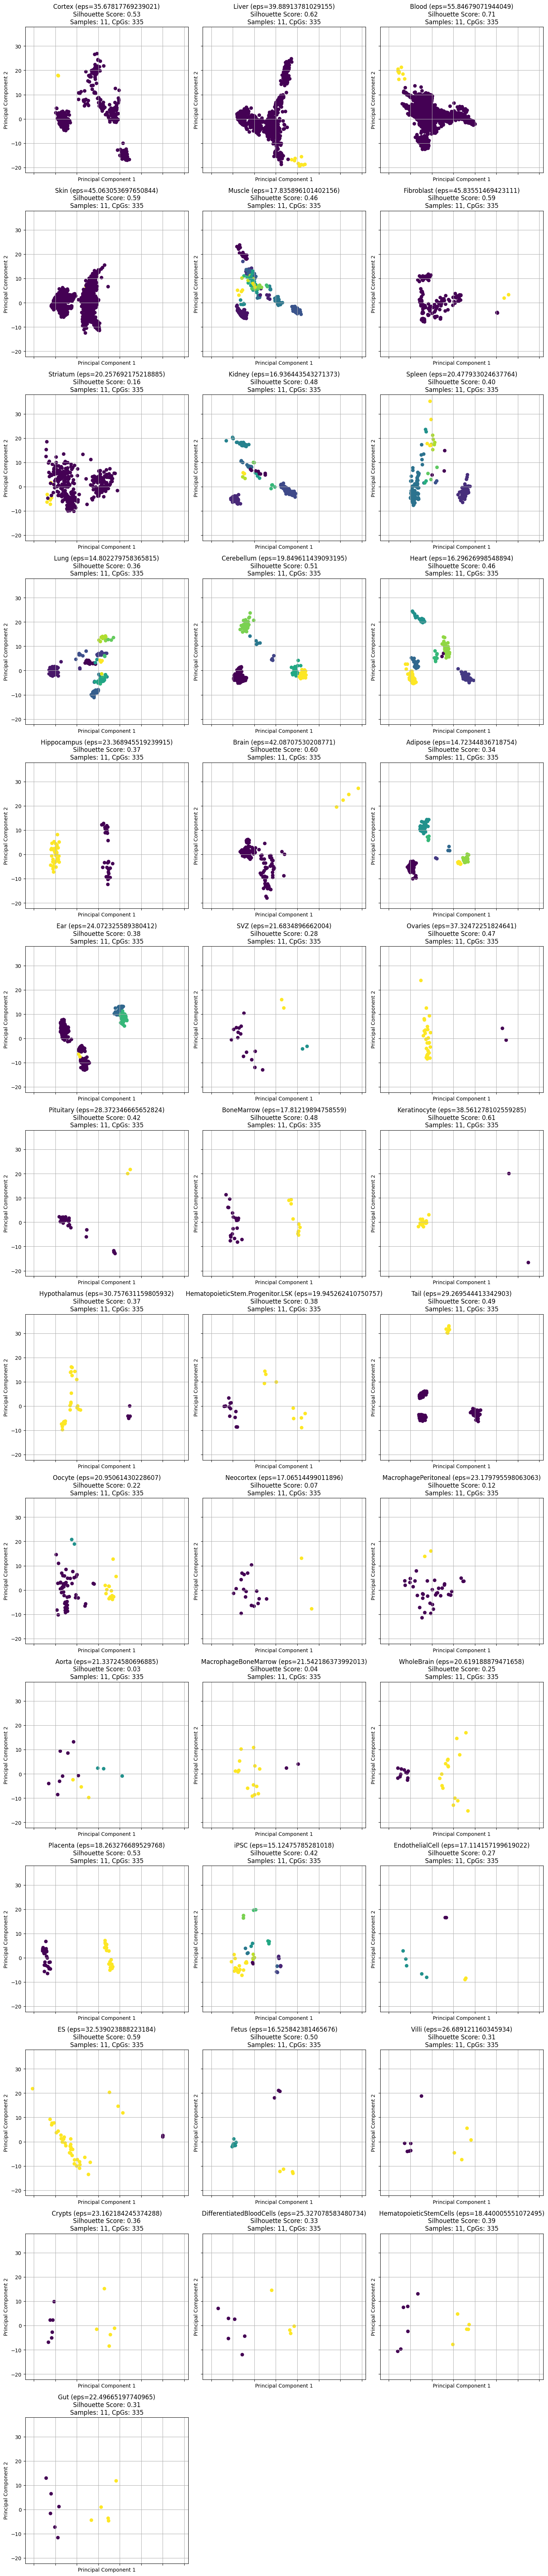

In [86]:
#### Scatter plot of DBSCAN Clustering of tissue datasets filtered by Clock 1 CpGs - Noise Removal & PCA

# Sort the DBSCAN results by tissue name
dbscan_results_tissues = dbscan_results_tissues.sort_values(by='Tissue')

# Define the folder paths
read_folder = './Cluster Analysis/DBSCAN'
save_folder = './Cluster Analysis/DBSCAN'

# Create a figure with subplots for each tissue
num_tissues = len(tissue_datasets)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_tissues - 1) // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

# Flatten axs array
axs = axs.flatten()

# Loop through all tissues
subplot_idx = 0  # Keep track of the current subplot
for idx, (index, row) in enumerate(tissue_datasets.iterrows()):
    tissue_name = row['Tissue']

    # Ensure there is a corresponding entry in dbscan_results
    best_eps_entry = dbscan_results_tissues[dbscan_results_tissues['Tissue'] == tissue_name]
    if best_eps_entry.empty:
        continue  # Skip this tissue if no best eps value is found

    # Get the best eps value and silhouette score for the tissue
    best_eps = best_eps_entry['eps'].values[0]
    best_min_samples = best_eps_entry['min_samples'].values[0]
    silhouette = best_eps_entry['silhouette_score'].values[0]

    # Load the saved cluster labels
    tissue_folder = os.path.join(read_folder, tissue_name)
    labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{best_eps}_min_samples{best_min_samples}_without_noise.joblib')

    if not os.path.exists(labels_path):
        continue  # Skip if the file does not exist

    labels = joblib.load(labels_path)

    # Load the filtered dataset
    X_filtered_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_X_without_noise_eps{best_eps}_min_samples{best_min_samples}.joblib')
    X_filtered = joblib.load(X_filtered_path)
    X = X_filtered

    # Check if the data and labels are valid
    if X.size == 0 or labels.size == 0:
        continue  # Skip this tissue if data or labels are empty

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Check if PCA transformation is successful
    if X_pca.size == 0:
        continue  # Skip this tissue if PCA results in empty data

    # Plot the data
    ax = axs[subplot_idx]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'{tissue_name} (eps={best_eps})\nSilhouette Score: {silhouette:.2f}\nSamples: {tissue_dataset.shape[0]}, CpGs: {tissue_dataset.shape[1]}')
    ax.grid()

    # Save the individual tissue plot
    tissue_save_folder = os.path.join(save_folder, tissue_name)
    os.makedirs(tissue_save_folder, exist_ok=True)
    fig_tissue, ax_tissue = plt.subplots(figsize=(8, 6))
    scatter_tissue = ax_tissue.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    ax_tissue.set_xlabel('Principal Component 1')
    ax_tissue.set_ylabel('Principal Component 2')
    ax_tissue.set_title(f'{tissue_name} (eps={best_eps})\nSilhouette Score: {silhouette:.2f}\nSamples: {tissue_dataset.shape[0]}, CpGs: {tissue_dataset.shape[1]}')
    ax_tissue.grid()
    fig_tissue.savefig(os.path.join(tissue_save_folder, f'{tissue_name}_scatter_plot.png'))
    plt.close(fig_tissue)

    subplot_idx += 1

# Remove any unused subplots
for i in range(subplot_idx, len(axs)):
    axs[i].set_visible(False)

# Adjust the layout
plt.tight_layout()

# Save the combined figure
combined_plot_path = os.path.join(save_folder, 'combined_scatterplots_pca_dbscan_wihthout_noise.png')
fig.savefig(combined_plot_path)

plt.show()

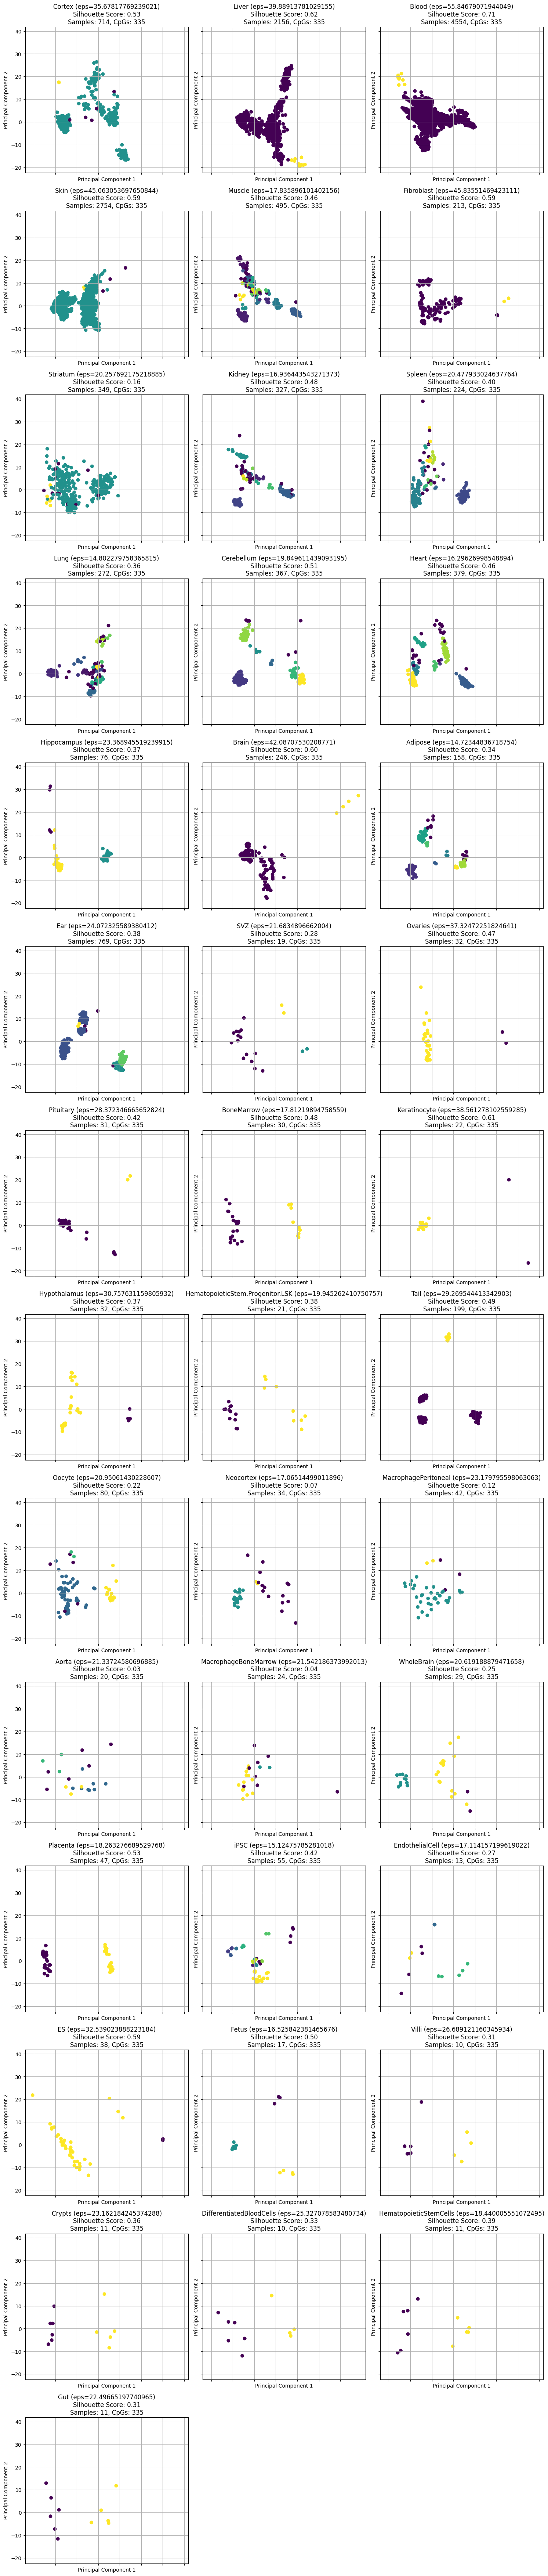

In [85]:
### Scatter plot of DBSCAN clustering of tissue datasets filtered by Clock 1 CpGs - PCA & Without noise removal 

# Sort the DBSCAN results by tissue name
dbscan_results_tissues = dbscan_results_tissues.sort_values(by='Tissue')

# Define the folder paths
read_folder = './Cluster Analysis/DBSCAN'
save_folder = './Cluster Analysis/DBSCAN'

# Create a figure with subplots for each tissue
num_tissues = len(tissue_datasets)
num_cols = 3  # Adjust the number of columns as needed
num_rows = (num_tissues - 1) // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex=True, sharey=True)

# Flatten axs array
axs = axs.flatten()

# Loop through all tissues
subplot_idx = 0  # Keep track of the current subplot
for idx, (index, row) in enumerate(tissue_datasets.iterrows()):
    tissue_name = row['Tissue']

    # Ensure there is a corresponding entry in dbscan_results
    best_eps_entry = dbscan_results_tissues[dbscan_results_tissues['Tissue'] == tissue_name]
    if best_eps_entry.empty:
        continue  # Skip this tissue if no best eps value is found

    # Get the best eps value and silhouette score for the tissue
    best_eps = best_eps_entry['eps'].values[0]
    best_min_samples = best_eps_entry['min_samples'].values[0]
    silhouette = best_eps_entry['silhouette_score'].values[0]

    # Load the saved cluster labels
    tissue_folder = os.path.join(read_folder, tissue_name)
    labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{best_eps}_min_samples{best_min_samples}.joblib')

    if not os.path.exists(labels_path):
        continue  # Skip if the file does not exist

    labels = joblib.load(labels_path)

    # Transpose the dataset so that CpGs are columns and samples are rows
    tissue_dataset = row['Dataset'].set_index('CpG').transpose()

    # Check if there are enough samples for clustering
    if tissue_dataset.shape[0] < 2:
        continue

    X = tissue_dataset

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # For the filtered dataset to pass thi scrip need to modify to have this instead
    # # Filter X to remove noise points
    # non_noise_mask = full_labels != -1
    # X_filtered = X[non_noise_mask]

    # Plot the data
    ax = axs[subplot_idx]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'{tissue_name} (eps={best_eps})\nSilhouette Score: {silhouette:.2f}\nSamples: {tissue_dataset.shape[0]}, CpGs: {tissue_dataset.shape[1]}')
    ax.grid()

    # Save the individual tissue plot
    tissue_save_folder = os.path.join(save_folder, tissue_name)
    os.makedirs(tissue_save_folder, exist_ok=True)
    fig_tissue, ax_tissue = plt.subplots(figsize=(8, 6))
    scatter_tissue = ax_tissue.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    ax_tissue.set_xlabel('Principal Component 1')
    ax_tissue.set_ylabel('Principal Component 2')
    ax_tissue.set_title(f'{tissue_name} (eps={best_eps})\nSilhouette Score: {silhouette:.2f}\nSamples: {tissue_dataset.shape[0]}, CpGs: {tissue_dataset.shape[1]}')
    ax_tissue.grid()
    fig_tissue.savefig(os.path.join(tissue_save_folder, f'{tissue_name}_scatter_plot.png'))
    plt.close(fig_tissue)

    subplot_idx += 1

# Remove any unused subplots
for i in range(subplot_idx, len(axs)):
    axs[i].set_visible(False)

# Adjust the layout
plt.tight_layout()

# Save the combined figure
combined_plot_path = os.path.join(save_folder, 'combined_scatterplots_pca_dbscan.png')
fig.savefig(combined_plot_path)

plt.show()

In [95]:
#### [Upgraded] Feature Analysis for DBSCAN Clustering of tissue datasets filtered by Clock 1 CpGs - With noise removal

# Select folder
read_folder = './Cluster Analysis/DBSCAN/'
save_folder = './Cluster Analysis/DBSCAN/FEATURE ANALYSIS/'

# Perform feature analysis for each tissue
for index, row in dbscan_results_tissues.iterrows():
    tissue_name = row['Tissue']
    
    # Load the best labels for the current tissue (without noise)
    tissue_folder = os.path.join(read_folder, tissue_name)
    labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{row["eps"]}_min_samples{row["min_samples"]}_without_noise.joblib')
    labels_without_noise = joblib.load(labels_path)

    # Load the dataset without noise
    X_without_noise_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_X_without_noise_eps{row["eps"]}_min_samples{row["min_samples"]}.joblib')
    X_without_noise = joblib.load(X_without_noise_path)

    # Load the original dataset
    dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].iloc[0]

    # Transpose the dataset so that features are rows and samples are columns
    dataset = dataset.set_index('CpG').transpose()
    
    # Get the non-noise samples
    non_noise_mask = row['full_labels'] != -1
    dataset_without_noise = dataset.iloc[non_noise_mask]

    # Ensure that the number of samples in dataset_without_noise matches X_without_noise
    assert dataset_without_noise.shape[0] == X_without_noise.shape[0], "Mismatch in number of samples"

    # Perform feature analysis
    feature_scores = feature_analysis(tissue_name, dataset_without_noise, labels_without_noise)
    
    # Check or create the output folder
    output_folder = os.path.join(save_folder)
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f'{tissue_name}_feature_scores_without_noise.csv')

    # Save the feature scores to a CSV file
    feature_scores.to_csv(output_path, index=False)

# Display the feature scores for the first tissue
feature_scores.head()


CpG  Chi2_Score  Chi2_Pvalue    F_Score  F_Pvalue  MI_Score
89     cg08446005    0.241710     0.886163  12.669460  0.001398  0.385718
97     cg09025625    0.209934     0.900354  13.519891  0.001087  0.350627
226  cg18473521.2    0.204634     0.902743   9.877886  0.003500  0.203657
285    cg23510032    0.179585     0.914121  17.945288  0.000344  0.421432
133    cg11321459    0.176171     0.915683   9.543920  0.003949  0.201160

In [ ]:
# #### [Original] Feature Analysis for DBSCAN Clustering of tissue datasets filtered by Clock 1 CpGs - Without noise removal

# # Select folder
# read_folder = './Cluster Analysis/DBSCAN/'
# save_folder = './Cluster Analysis/DBSCAN/FEATURE ANALYSIS/'

# # Perform feature analysis for each tissue
# for index, row in dbscan_results_tissues.iterrows():
#     tissue_name = row['Tissue']
    
#     # Load the best labels for the current tissue
#     tissue_folder = os.path.join(read_folder, tissue_name)
#     labels_path = os.path.join(tissue_folder, f'dbscan_{tissue_name}_best_cluster_labels_eps{row["eps"]}_min_samples{row["min_samples"]}.joblib')
#     labels = joblib.load(labels_path)

#     # Load the dataset
#     dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].iloc[0]

#     # Transpose the dataset so that features are rows and samples are columns
#     dataset = dataset.set_index('CpG').transpose()
    
#     # Perform feature analysis
#     feature_scores = feature_analysis(tissue_name, dataset, labels)
    
#     # Check or create the output folder
#     output_folder = os.path.join(save_folder)
#     os.makedirs(output_folder, exist_ok=True)
#     output_path = os.path.join(output_folder, f'{tissue_name}_feature_scores.csv')

#     # Save the feature scores to a CSV file
#     feature_scores.to_csv(output_path, index=False)

# # Display the feature scores for the first tissue
# feature_scores.head()

# ### takes 2 min to run

## 5. Comparing Clustering Models

-  Compare the clustering results (e.g., cluster centroids, cluster assignments) obtained from different tissue-specific datasets.
- Visualize the clustering patterns across tissues using heatmaps, dendrograms, or multidimensional scaling plots.
- Use techniques such as hierarchical clustering or k-means clustering to cluster tissues based on their clustering patterns.
- Calculate similarity or dissimilarity metrics (e.g., Jaccard similarity, Euclidean distance) between clustering results of different tissues to identify similarities and differences.
- Perform statistical tests (e.g., ANOVA, t-tests) to assess the significance of differences in clustering patterns across tissues.

### 5.1. Best Overall Model for tissue datasets (BOM)

The clustering scripts above selected the best params for EACH tissue dataset within the same clustering mode. So, the results will comprise the SAME clustering model but with tuned params for each tissue dataset.

In [96]:
# Comparing all methods for ALL tissues (so, best method and params overall)

kmeans_df = km_results_tissues.copy()
hc_df = hc_best_results_calinski.copy()
dbscan_df = dbscan_results_tissues.copy()

# Calculate average silhouette scores
kmeans_avg_score = kmeans_df['silhouette_score'].mean()
hc_avg_score = hc_df['silhouette_score'].mean()
dbscan_avg_score = dbscan_df['silhouette_score'].mean()

# Store the results in a dictionary
avg_scores = {
    'KMeans': kmeans_avg_score,
    'Hierarchical': hc_avg_score,
    'DBSCAN': dbscan_avg_score
}

# Find the best method based on average silhouette score
best_method = max(avg_scores, key=avg_scores.get)
best_score = avg_scores[best_method]

# rename the dataset if it is the best method
if best_method == 'KMeans':
    best_model_BOM = km_results_tissues.copy()
elif best_method == 'Hierarchical':
    best_model_BOM = hc_best_results_calinski.copy()
elif best_method == 'DBSCAN':
    best_model_BOM = dbscan_results_tissues.copy()
else:
    print('Error: Best method not found')

print(f"The best method overall is {best_method} with an average silhouette score of {best_score:.6f}")
print (avg_scores)

The best method overall is DBSCAN with an average silhouette score of 0.394864
{'KMeans': 0.3416610079815497, 'Hierarchical': 0.30973727993321026, 'DBSCAN': 0.39486441714958154}


In [97]:
best_model_BOM.head()

Tissue        eps  min_samples  silhouette_score  n_clusters  \
2          Blood  55.846791            2          0.709689           2   
1          Liver  39.889138            2          0.623550           2   
20  Keratinocyte  38.561278            2          0.606273           2   
13         Brain  42.087075            2          0.603452           2   
33            ES  32.539024            2          0.593679           2   

    core_samples  n_noise  noise_ratio  \
2           4554        0          0.0   
1           2156        0          0.0   
20            22        0          0.0   
13           246        0          0.0   
33            38        0          0.0   

                                          full_labels  \
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
20  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
33  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                     non_noise_labels  total_features  \
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
20  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...             335   
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...             335   
33  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...             335   

   dataset_shape  
2    (4554, 335)  
1    (2156, 335)  
20     (22, 335)  
13    (246, 335)  
33     (38, 335)

### 5.2. Best method for EACH tissue datasets (TSM)

In [98]:
### Cluster Stability & Quality Evaluation - Selecting the best method for each tissue

# Define a function to calculate cluster stability
def calculate_cluster_stability(X, labels, method, params):
    np.random.seed(42)
    n_iterations = 10
    perturbation_factor = 0.1  # Adjust this factor to control the amount of perturbation

    stability_scores = []

    for _ in range(n_iterations):
        X_perturbed = X + np.random.normal(0, perturbation_factor, X.shape)
        if method == 'kmeans':
            kmeans = KMeans(n_clusters=params['k'], random_state=42)
            kmeans.fit(X_perturbed)
            new_labels = kmeans.labels_
        elif method == 'hierarchical':
            hierarchical = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage=params['linkage'], metric=params['metric'])   
            new_labels = hierarchical.fit_predict(X_perturbed)
        elif method == 'dbscan':
            dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
            new_labels = dbscan.fit_predict(X_perturbed)
        
        stability_score = silhouette_score(X_perturbed, new_labels)
        stability_scores.append(stability_score)

    return np.mean(stability_scores)

# Evaluate cluster stability for each method and tissue
def evaluate_clustering_methods(tissue_name, tissue_dataset):
    tissue_results = {}

    # Load the dataset 
    X = tissue_dataset

    # Evaluate KMeans
    km_tissue_result = km_results[km_results['Tissue'] == tissue_name]
    if not km_tissue_result.empty:
        best_k = km_tissue_result.iloc[0]['k']
        best_labels = km_tissue_result.iloc[0]['cluster_labels']
        km_stability = calculate_cluster_stability(X, best_labels, 'kmeans', {'k': best_k})
        km_quality = km_tissue_result.iloc[0]['silhouette_score']
        tissue_results['kmeans'] = {'stability': km_stability, 'quality': km_quality}

    # Evaluate Hierarchical Clustering
    hc_tissue_result = hc_results[hc_results['Tissue'] == tissue_name]
    if not hc_tissue_result.empty:
        best_method = hc_tissue_result.iloc[0]['best_method']
        best_metric = hc_tissue_result.iloc[0]['best_metric']
        best_num_clusters = hc_tissue_result.iloc[0]['best_num_clusters']
        best_labels = hc_tissue_result.iloc[0]['cluster_labels']
        hc_stability = calculate_cluster_stability(X, best_labels, 'hierarchical', {'n_clusters': best_num_clusters, 'linkage': best_method, 'metric': best_metric})
        hc_quality = hc_tissue_result.iloc[0]['silhouette_score']
        tissue_results['hierarchical'] = {'stability': hc_stability, 'quality': hc_quality}

    # Evaluate DBSCAN
    dbscan_tissue_result = dbscan_results[dbscan_results['Tissue'] == tissue_name]
    if not dbscan_tissue_result.empty:
        best_eps = dbscan_tissue_result.iloc[0]['eps']
        best_min_samples = dbscan_tissue_result.iloc[0]['min_samples']
        # best_labels = dbscan_tissue_result.iloc[0]['cluster_labels'] # With noise
        best_labels = dbscan_tissue_result.iloc[0]['non_noise_labels'] # checking if better to use non noise labels
        dbscan_stability = calculate_cluster_stability(X, best_labels, 'dbscan', {'eps': best_eps, 'min_samples': best_min_samples})
        dbscan_quality = dbscan_tissue_result.iloc[0]['silhouette_score']
        tissue_results['dbscan'] = {'stability': dbscan_stability, 'quality': dbscan_quality}

    return tissue_results

# Function to determine the best method based on stability and quality
def determine_best_method(tissue_results):
    best_method = None
    best_score = -np.inf

    for method, scores in tissue_results.items():
        combined_score = scores['stability'] + scores['quality']
        if combined_score > best_score:
            best_score = combined_score
            best_method = method

    return best_method, best_score

# Function to visualize the clusters
def visualize_clusters(X, tissue, labels, title, folder):
    try:
        # Reduce dimensionality with PCA for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # Ensure labels match the number of samples
        if len(labels) != X_pca.shape[0]:
            print(f"Error: Number of labels {len(labels)} in tissue {tissue} does not match number of PCA samples {X_pca.shape[0]}")
            return
        
        # Plot the clusters
        fig, ax = plt.subplots(figsize=(8, 6))
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        plt.colorbar(scatter)
        
        # Save the plot
        os.makedirs(folder, exist_ok=True)
        plot_path = os.path.join(folder, f'{title}.png')
        plt.savefig(plot_path, bbox_inches='tight')

        # Display the plot
        plt.show()

        
    except Exception as e:
        print(f"An error occurred during visualization: {e}")


# Load the tissue datasets
km_results = km_results_tissues.copy()
hc_results = hc_best_results_calinski.copy()
dbscan_results = dbscan_results_tissues.copy()

# Main evaluation loop
final_results = []

for index, row in tissue_datasets.iterrows():
    tissue_name = row['Tissue']
    tissue_dataset = row['Dataset']
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    if tissue_dataset.shape[0] < 2:
        print(f"Skipping {tissue_name} due to insufficient samples")   
        continue

    tissue_results = evaluate_clustering_methods(tissue_name, tissue_dataset)
    final_results.append({'Tissue': tissue_name, 'Results': tissue_results})


# Determine the best method for each tissue
best_methods = []

for result in final_results:
    tissue_name = result['Tissue']
    tissue_results = result['Results']
    best_method, best_score = determine_best_method(tissue_results)
    best_methods.append({'Tissue': tissue_name, 'Best_Method': best_method, 'Combined Score': best_score})

# Convert to DataFrame and display results
best_models_TSM = pd.DataFrame(best_methods)
best_models_TSM

# # Visualize clusters for best method of each tissue
# for result in final_results:
#     tissue_name = result['Tissue']
#     best_method_TSM = best_models_TSM[best_models_TSM['Tissue'] == tissue_name]['Best_Method'].values[0]
#     tissue_dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].values[0]
#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()
#     X = tissue_dataset

#     if best_method_TSM == 'kmeans':
#         best_labels = km_results[km_results['Tissue'] == tissue_name].iloc[0]['cluster_labels']
#     elif best_method_TSM == 'hierarchical':
#         best_labels = hc_results[hc_results['Tissue'] == tissue_name].iloc[0]['cluster_labels']
#     elif best_method_TSM == 'dbscan':
#         best_labels = dbscan_results[dbscan_results['Tissue'] == tissue_name].iloc[0]['cluster_labels']

#     visualize_clusters(X, tissue_name, best_labels, f'{tissue_name} - Best Method: {best_method_TSM}', './Cluster Analysis/Best Methods')



Tissue   Best_Method  Combined Score
0                             Cortex        dbscan        1.057267
1                              Liver        dbscan        1.177628
2                              Blood        dbscan        1.417749
3                               Skin        dbscan        1.182575
4                             Muscle        dbscan        0.908231
5                         Fibroblast        dbscan        1.176951
6                           Striatum        kmeans        0.340898
7                             Kidney        dbscan        0.942270
8                             Spleen        dbscan        0.790661
9                               Lung        dbscan        0.701773
10                         LymphNode        kmeans        0.558724
11                        Cerebellum        kmeans        1.033527
12                             Heart        kmeans        0.917519
13                       Hippocampus        dbscan        0.744402
14                             Brain        dbscan        1.204343
15                           Adipose        kmeans        0.728391
16                               Ear        dbscan        0.755140
17                               SVZ        kmeans        0.590547
18                           Ovaries  hierarchical        0.934027
19                         Pituitary        dbscan        0.827550
20                        BoneMarrow        kmeans        0.957337
21                           Bladder  hierarchical        0.537460
22                     FrontalCortex        kmeans        0.218289
23                      Keratinocyte        kmeans        1.209330
24                      Hypothalamus        dbscan        0.730126
25  HematopoieticStem.Progenitor.LSK        kmeans        0.761088
26                              Tail        dbscan        0.981220
27                            Oocyte  hierarchical        0.443400
28                         Neocortex        kmeans        0.618525
29                  Substantia nigra  hierarchical        0.563343
30              MacrophagePeritoneal        kmeans        0.300462
31                             Aorta  hierarchical        0.227087
32              MacrophageBoneMarrow  hierarchical        0.880563
33                        WholeBrain        kmeans        0.573354
34                          Placenta        kmeans        1.053153
35                              iPSC        kmeans        0.864836
36                   EndothelialCell  hierarchical        0.547863
37                                ES        dbscan        1.153450
38                             Fetus        kmeans        0.996858
39                             Villi        kmeans        0.623824
40                            Crypts        kmeans        0.723155
41          DifferentiatedBloodCells        kmeans        0.657069
42            HematopoieticStemCells        kmeans        0.770300
43                               Gut        kmeans        0.612278

In [100]:
best_models_TSM['Best_Method'].value_counts()

Best_Method
kmeans          21
dbscan          16
hierarchical     7
Name: count, dtype: int64

## 6. Comparing Clustering Results

The permutation tests help evaluate the stability and quality of the clustering results by comparing the observed distances between tissue centroids/medoids to the distribution of distances obtained by randomly permuting the data points.

In [105]:
### Cluster Stability & Quality Evaluation with Permutation Tests - TSM

# Function to compute centroids or medoids
def compute_centroids(X, labels, method='centroid'):
    unique_labels = np.unique(labels)
    centroids = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        if method == 'centroid':
            centroid = np.mean(cluster_points, axis=0)
        elif method == 'medoid':
            distances = pairwise_distances(cluster_points, metric='euclidean')
            medoid_index = np.argmin(distances.sum(axis=1))
            centroid = cluster_points[medoid_index]
        centroids.append(centroid)
    return np.array(centroids)

# Function to compute pairwise distances between clusters of different tissues
def compute_pairwise_distances(centroids_dict, metric='euclidean'):
    tissue_names = list(centroids_dict.keys())
    pairwise_distances_dict = {}
    for (tissue1, centroids1), (tissue2, centroids2) in itertools.combinations(centroids_dict.items(), 2):
        distances = pairwise_distances(centroids1, centroids2, metric=metric)
        pairwise_distances_dict[(tissue1, tissue2)] = distances
    return pairwise_distances_dict

# Function to perform permutation tests
def permutation_test(X1, X2, n_permutations=1000, metric='euclidean'):
    observed_distance = np.mean(pairwise_distances(X1, X2, metric=metric))
    combined = np.vstack((X1, X2))
    n1 = X1.shape[0]
    
    perm_distances = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_X1 = combined[:n1]
        perm_X2 = combined[n1:]
        perm_distance = np.mean(pairwise_distances(perm_X1, perm_X2, metric=metric))
        perm_distances.append(perm_distance)
    
    p_value = np.sum(perm_distances >= observed_distance) / n_permutations
    return observed_distance, p_value


km_results = km_results_tissues.copy()
hc_results = hc_best_results_calinski.copy()
dbscan_results = dbscan_results_tissues.copy()

# Load the best clustering results for each tissue
centroids_dict = {}

for tissue_name, best_method in zip(best_models_TSM['Tissue'], best_models_TSM['Best_Method']):
    if best_method == 'kmeans':
        best_clustering_results = km_results[km_results['Tissue'] == tissue_name]
    elif best_method == 'hierarchical':
        best_clustering_results = hc_results[hc_results['Tissue'] == tissue_name] # here
    elif best_method == 'dbscan':
        best_clustering_results = dbscan_results[dbscan_results['Tissue'] == tissue_name]
    else:
        print(f"Error: Best method not found for {tissue_name}")
        continue

    # Load the tissue dataset
    tissue_dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].values[0]
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()
    X = tissue_dataset

   # Compute centroids or medoids
    try:
        cluster_labels = best_clustering_results.iloc[0]['cluster_labels']
    except KeyError:
        best_eps = best_clustering_results.iloc[0]['eps']
        cluster_labels = best_clustering_results.iloc[0]['non_noise_labels']
        X_filtered_path = f'./Cluster Analysis/DBSCAN/{tissue_name}/dbscan_{tissue_name}_X_without_noise_eps{best_eps}_min_samples2.joblib'
        X_filtered = joblib.load(X_filtered_path)
        X = X_filtered

    centroids = compute_centroids(X, cluster_labels, method='centroid')
    centroids_dict[tissue_name] = centroids

# Compute pairwise distances
pairwise_distances_dict = compute_pairwise_distances(centroids_dict, metric='euclidean')

# Perform permutation tests
permutation_results = {}
for (tissue1, tissue2), distances in pairwise_distances_dict.items():
    centroids1 = centroids_dict[tissue1]
    centroids2 = centroids_dict[tissue2]
    observed_distance, p_value = permutation_test(centroids1, centroids2, n_permutations=1000, metric='euclidean')
    permutation_results[(tissue1, tissue2)] = {'observed_distance': observed_distance, 'p_value': p_value}

# Save all the results in a dataframe and in folder for future reference
folder = 'Cluster Analysis/Cluster Stability/'
os.makedirs(folder, exist_ok=True)

# # save results in a csv file
# cluster_stability_TSM = pd.DataFrame(permutation_results)

# cluster_stability_TSM.to_csv(os.path.join(folder, 'cluster_stability_results.csv'))

# Display the results
cluster_stability_TSM = pd.DataFrame(permutation_results) # Convert to DataFrame for display
cluster_stability_TSM


Cortex                                             \
                       Liver     Blood       Skin     Muscle Fibroblast   
observed_distance  42.303804  52.80631  43.891534  36.066167   42.87564   
p_value             0.825000   1.00000   1.000000   0.100000    1.00000   

                                                                        ...  \
                    Striatum     Kidney     Spleen      Lung LymphNode  ...   
observed_distance  27.510042  34.235266  34.926893  33.63048  29.79656  ...   
p_value             1.000000   0.166000   0.211000   0.09500   0.75100  ...   

                       Villi                                                  \
                      Crypts DifferentiatedBloodCells HematopoieticStemCells   
observed_distance  16.125646                 17.59696              18.069742   
p_value             1.000000                  0.95200               1.000000   

                                               Crypts                         \
                         Gut DifferentiatedBloodCells HematopoieticStemCells   
observed_distance  14.995309                18.182305              18.572101   
p_value             1.000000                 1.000000               1.000000   

                             DifferentiatedBloodCells             \
                         Gut   HematopoieticStemCells        Gut   
observed_distance  15.900714                15.480189  17.309796   
p_value             1.000000                 0.960000   1.000000   

                  HematopoieticStemCells  
                                     Gut  
observed_distance              17.741968  
p_value                         0.779000  

[2 rows x 946 columns]

In [106]:
# Show only results where p-value is less than 0.05 - TSM
cluster_stability_TSM_transposed = cluster_stability_TSM.transpose()
significant_results = cluster_stability_TSM_transposed[cluster_stability_TSM_transposed['p_value'] < 0.05]
significant_results

observed_distance  p_value
Spleen     iPSC                27.686611    0.049
Lung       Cerebellum          32.701593    0.015
           Ear                 31.204985    0.042
           iPSC                26.393076    0.013
Cerebellum iPSC                30.904854    0.022

In [107]:
### [Updated] Cluster Stability & Quality Evaluation with Permutation Tests - BOM 
### Cluster Stability & Quality Evaluation with Permutation Tests - BOM

# Function to compute centroids or medoids
def compute_centroids(X, labels, method='centroid'):
    unique_labels = np.unique(labels)
    centroids = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        if method == 'centroid':
            centroid = np.mean(cluster_points, axis=0)
        elif method == 'medoid':
            distances = pairwise_distances(cluster_points, metric='euclidean')
            medoid_index = np.argmin(distances.sum(axis=1))
            centroid = cluster_points[medoid_index]
        centroids.append(centroid)
    return np.array(centroids)

# Function to compute pairwise distances between clusters of different tissues
def compute_pairwise_distances(centroids_dict, metric='euclidean'):
    tissue_names = list(centroids_dict.keys())
    pairwise_distances_dict = {}
    for (tissue1, centroids1), (tissue2, centroids2) in itertools.combinations(centroids_dict.items(), 2):
        distances = pairwise_distances(centroids1, centroids2, metric=metric)
        pairwise_distances_dict[(tissue1, tissue2)] = distances
    return pairwise_distances_dict

# Function to perform permutation tests
def permutation_test(X1, X2, n_permutations=1000, metric='euclidean'):
    observed_distance = np.mean(pairwise_distances(X1, X2, metric=metric))
    combined = np.vstack((X1, X2))
    n1 = X1.shape[0]
    
    perm_distances = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_X1 = combined[:n1]
        perm_X2 = combined[n1:]
        perm_distance = np.mean(pairwise_distances(perm_X1, perm_X2, metric=metric))
        perm_distances.append(perm_distance)
    
    p_value = np.sum(perm_distances >= observed_distance) / n_permutations
    return observed_distance, p_value


# Load the best clustering results for each tissue

# Load the best clustering results for each tissue
centroids_dict = {}

for tissue_name in best_model_BOM['Tissue']:
    best_clustering_results = best_model_BOM[best_model_BOM['Tissue'] == tissue_name]

    # Load the tissue dataset
    tissue_dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].values[0]
    tissue_dataset = tissue_dataset.set_index('CpG').transpose()

    X = tissue_dataset

    # Get both full labels and non-noise labels
    full_labels = best_clustering_results.iloc[0]['full_labels']
    non_noise_labels = best_clustering_results.iloc[0]['non_noise_labels']

    # Filter X to remove noise points
    non_noise_mask = full_labels != -1
    X_filtered = X[non_noise_mask]

    # Compute centroids or medoids using the filtered X and non-noise labels
    centroids = compute_centroids(X_filtered, non_noise_labels, method='centroid')
    centroids_dict[tissue_name] = centroids

# Compute pairwise distances
pairwise_distances_dict = compute_pairwise_distances(centroids_dict, metric='euclidean')

# Perform permutation tests
permutation_results = {}
for (tissue1, tissue2), distances in pairwise_distances_dict.items():
    centroids1 = centroids_dict[tissue1]
    centroids2 = centroids_dict[tissue2]
    observed_distance, p_value = permutation_test(centroids1, centroids2, n_permutations=1000, metric='euclidean')
    permutation_results[(tissue1, tissue2)] = {'observed_distance': observed_distance, 'p_value': p_value}

# Save all the results in a dataframe and in folder for future reference
folder = 'Cluster Analysis/Cluster Stability/'
os.makedirs(folder, exist_ok=True)

# # save results in a csv file
# cluster_stability_TSM = pd.DataFrame(permutation_results)

# cluster_stability_TSM.to_csv(os.path.join(folder, 'cluster_stability_results.csv'))

# Display the results
cluster_stability_BOM = pd.DataFrame(permutation_results) # Convert to DataFrame for display
cluster_stability_BOM

Blood                                                \
                       Liver Keratinocyte      Brain         ES       Skin   
observed_distance  46.344953     53.12835  45.655646  55.192682  54.547972   
p_value             1.000000      1.00000   1.000000   0.789000   1.000000   

                                                                        ...  \
                  Fibroblast    Cortex   Placenta Cerebellum     Fetus  ...   
observed_distance  53.009379  52.80631  46.879699   53.12087  48.22405  ...   
p_value             0.841000   0.70600   1.000000    0.23600   0.42100  ...   

                              Striatum                                 \
                  MacrophagePeritoneal Neocortex MacrophageBoneMarrow   
observed_distance            18.523557  16.91117            17.129698   
p_value                       1.000000   1.00000             1.000000   

                             MacrophagePeritoneal                       \
                       Aorta            Neocortex MacrophageBoneMarrow   
observed_distance  18.303211            15.670575             15.50175   
p_value             0.480000             1.000000              0.85600   

                                        Neocortex             \
                       Aorta MacrophageBoneMarrow      Aorta   
observed_distance  16.547058            13.956059  14.358099   
p_value             0.753000             1.000000   1.000000   

                  MacrophageBoneMarrow  
                                 Aorta  
observed_distance            15.156706  
p_value                       0.985000  

[2 rows x 780 columns]

In [109]:
#### [Original] Cluster Stability & Quality Evaluation with Permutation Tests - BOM

# # Function to compute centroids or medoids
# def compute_centroids(X, labels, method='centroid'):
#     unique_labels = np.unique(labels)
#     centroids = []
#     for label in unique_labels:
#         cluster_points = X[labels == label]
#         if method == 'centroid':
#             centroid = np.mean(cluster_points, axis=0)
#         elif method == 'medoid':
#             distances = pairwise_distances(cluster_points, metric='euclidean')
#             medoid_index = np.argmin(distances.sum(axis=1))
#             centroid = cluster_points[medoid_index]
#         centroids.append(centroid)
#     return np.array(centroids)

# # Function to compute pairwise distances between clusters of different tissues
# def compute_pairwise_distances(centroids_dict, metric='euclidean'):
#     tissue_names = list(centroids_dict.keys())
#     pairwise_distances_dict = {}
#     for (tissue1, centroids1), (tissue2, centroids2) in itertools.combinations(centroids_dict.items(), 2):
#         distances = pairwise_distances(centroids1, centroids2, metric=metric)
#         pairwise_distances_dict[(tissue1, tissue2)] = distances
#     return pairwise_distances_dict

# # Function to perform permutation tests
# def permutation_test(X1, X2, n_permutations=1000, metric='euclidean'):
#     observed_distance = np.mean(pairwise_distances(X1, X2, metric=metric))
#     combined = np.vstack((X1, X2))
#     n1 = X1.shape[0]
    
#     perm_distances = []
#     for _ in range(n_permutations):
#         np.random.shuffle(combined)
#         perm_X1 = combined[:n1]
#         perm_X2 = combined[n1:]
#         perm_distance = np.mean(pairwise_distances(perm_X1, perm_X2, metric=metric))
#         perm_distances.append(perm_distance)
    
#     p_value = np.sum(perm_distances >= observed_distance) / n_permutations
#     return observed_distance, p_value


# # Load the best clustering results for each tissue

# centroids_dict = {}

# for tissue_name in best_model_BOM['Tissue']:

#     best_clustering_results = best_model_BOM[best_model_BOM['Tissue'] == tissue_name]

#     # Load the tissue dataset
#     tissue_dataset = tissue_datasets[tissue_datasets['Tissue'] == tissue_name]['Dataset'].values[0]
#     tissue_dataset = tissue_dataset.set_index('CpG').transpose()
#     X = tissue_dataset

#     # Compute centroids or medoids
#     cluster_labels = best_clustering_results.iloc[0]['cluster_labels']
#     centroids = compute_centroids(X, cluster_labels, method='centroid')
#     centroids_dict[tissue_name] = centroids

# # Compute pairwise distances
# pairwise_distances_dict = compute_pairwise_distances(centroids_dict, metric='euclidean')

# # Perform permutation tests
# permutation_results = {}
# for (tissue1, tissue2), distances in pairwise_distances_dict.items():
#     centroids1 = centroids_dict[tissue1]
#     centroids2 = centroids_dict[tissue2]
#     observed_distance, p_value = permutation_test(centroids1, centroids2, n_permutations=1000, metric='euclidean')
#     permutation_results[(tissue1, tissue2)] = {'observed_distance': observed_distance, 'p_value': p_value}

# # Save all the results in a dataframe and in folder for future reference
# folder = 'Cluster Analysis/Cluster Stability/'
# os.makedirs(folder, exist_ok=True)

# # # save results in a csv file
# # cluster_stability_TSM = pd.DataFrame(permutation_results)

# # cluster_stability_TSM.to_csv(os.path.join(folder, 'cluster_stability_results.csv'))

# # Display the results
# cluster_stability_BOM = pd.DataFrame(permutation_results) # Convert to DataFrame for display
# cluster_stability_BOM

In [111]:
### Show only results where p-value is less than 0.05 - BOM
cluster_stability_BOM_transposed = cluster_stability_BOM.transpose()
significant_results = cluster_stability_BOM_transposed[cluster_stability_BOM_transposed['p_value'] < 0.05]
significant_results

observed_distance  p_value
Cerebellum Lung          32.719646    0.014
Ear        Lung          31.204985    0.043

### 6.1. Jaccard similarity and ARI between tissues

These similarity metrics (jaccard and ARI) provide insights into how similar or dissimilar the clustering results are across different tissue datasets.

In [184]:
#### Jaccard Similiarity and ARI between between tissues - TSM - With Padding

# Load the tissue datasets
km_results = km_results_tissues.copy()
hc_results = hc_best_results_calinski.copy()
dbscan_results = dbscan_results_tissues.copy()

# Initialize an empty dataframe to store best models
best_models = pd.DataFrame(columns=['Tissue', 'Best_Method', 'Cluster_Labels']) # best_models based on TSM

# Iterate through each tissue and best method
for tissue_name, best_method in zip(best_models_TSM['Tissue'], best_models_TSM['Best_Method']):
    if best_method == 'kmeans':
        best_clustering_results = km_results[km_results['Tissue'] == tissue_name]
    elif best_method == 'hierarchical':
        best_clustering_results = hc_results[hc_results['Tissue'] == tissue_name]
    elif best_method == 'dbscan':
        best_clustering_results = dbscan_results[dbscan_results['Tissue'] == tissue_name]
    else:
        print(f"Error: Best method not found for {tissue_name}")
        continue

    if not best_clustering_results.empty:
        try:
            cluster_labels = best_clustering_results['cluster_labels'].values[0]
        except KeyError:
            cluster_labels = best_clustering_results['non_noise_labels'].values[0]
        best_models.loc[len(best_models)] = [tissue_name, best_method, cluster_labels]

best_models.head()

### Calculate similarity between cluster labels using Jaccard similarity and Adjusted Rand Index

# Create a dataframe to store the results
similarity_results_TSM = pd.DataFrame(columns=['Tissue 1', 'Tissue 2', 'Jaccard Similarity', 'Adjusted Rand Index'])

# Get all combinations of tissue pairs
tissue_pairs = list(combinations(best_models['Tissue'].unique(), 2))

# Calculate similarity/dissimilarity metrics for each pair
for tissue1, tissue2 in tissue_pairs:
    try: 
        labels1 = best_models.loc[best_models['Tissue'] == tissue1, 'Cluster_Labels'].values[0]
        labels2 = best_models.loc[best_models['Tissue'] == tissue2, 'Cluster_Labels'].values[0]
    except KeyError:
        labels1 = best_models.loc[best_models['Tissue'] == tissue1, 'non_noise_labels'].values[0]
        labels2 = best_models.loc[best_models['Tissue'] == tissue2, 'non_noise_labels'].values[0]
    
    # Ensure both label sets have the same length by padding with a special label (-1)
    max_len = max(len(labels1), len(labels2))
    labels1 = np.pad(labels1, (0, max_len - len(labels1)), constant_values=-1)
    labels2 = np.pad(labels2, (0, max_len - len(labels2)), constant_values=-1)
    
    # Create a mask to ignore the padding labels
    mask = (labels1 != -1) & (labels2 != -1)
    labels1 = labels1[mask]
    labels2 = labels2[mask]
    
    # Calculate Jaccard similarity
    jaccard_sim = jaccard_score(labels1, labels2, average='macro')
    
    # Calculate Adjusted Rand Index
    ari = adjusted_rand_score(labels1, labels2)
    
    # Append results to the dataframe
    similarity_results_TSM.loc[len(similarity_results_TSM)] = [tissue1, tissue2, jaccard_sim, ari]

similarity_results_TSM.sort_values(by='Adjusted Rand Index', ascending=False)


Tissue 1                Tissue 2  Jaccard Similarity  \
945  HematopoieticStemCells                     Gut            1.000000   
938                   Villi  HematopoieticStemCells            1.000000   
625                 Ovaries            Keratinocyte            1.000000   
639                 Ovaries                      ES            0.000000   
749            Keratinocyte                      ES            0.000000   
..                      ...                     ...                 ...   
601                     SVZ            Hypothalamus            0.266667   
391               LymphNode                     SVZ            0.266667   
324                  Spleen                     SVZ            0.225000   
389               LymphNode                 Adipose            0.172414   
910                    iPSC         EndothelialCell            0.000000   

     Adjusted Rand Index  
945             1.000000  
938             1.000000  
625             1.000000  
639             1.000000  
749             1.000000  
..                   ...  
601            -0.129730  
391            -0.129730  
324            -0.130312  
389            -0.134623  
910            -0.165517  

[946 rows x 4 columns]

In [168]:
# check range of ARI values
similarity_results_TSM.describe()

Jaccard Similarity  Adjusted Rand Index
count          946.000000           946.000000
mean             0.235356             0.046870
std              0.195908             0.170742
min              0.000000            -0.165517
25%              0.066206             0.000000
50%              0.200000             0.000000
75%              0.350000             0.025584
max              1.000000             1.000000

In [169]:
# check tissues where ARI was less than 0
similarity_results_TSM[similarity_results_TSM['Adjusted Rand Index'] < 0]

Tissue 1                  Tissue 2  Jaccard Similarity  \
3             Cortex                    Muscle            0.002472   
11            Cortex                     Heart            0.029278   
44             Liver                      Skin            0.497217   
166           Muscle                Fibroblast            0.011783   
177           Muscle                       Ear            0.008580   
..               ...                       ...                 ...   
922  EndothelialCell  DifferentiatedBloodCells            0.119048   
923  EndothelialCell    HematopoieticStemCells            0.107143   
924  EndothelialCell                       Gut            0.107143   
926               ES                     Villi            0.416667   
928               ES  DifferentiatedBloodCells            0.416667   

     Adjusted Rand Index  
3              -0.005319  
11             -0.004816  
44             -0.001541  
166            -0.003199  
177            -0.124386  
..                   ...  
922            -0.111111  
923            -0.076923  
924            -0.076923  
926            -0.046512  
928            -0.046512  

[236 rows x 4 columns]

In [170]:
#### Jaccard Similiarity and ARI between between tissues - BOM - With Padding

# here we have used padding with -1, so that all labels from each tissue are used in the comparison (the number must match). 
# After padding is used to ensure both label sets have the same lenght, we mask the -1's to ignore them

# Initialize an empty dataframe to store pairwise similarity/dissimilarity results
similarity_results_BOM = pd.DataFrame(columns=['Tissue1', 'Tissue2', 'Jaccard Similarity', 'Adjusted Rand Index'])

# Get all combinations of tissue pairs
tissue_pairs = list(combinations(best_model_BOM['Tissue'].unique(), 2)) # best_model_BOM based on BOM

# Calculate similarity/dissimilarity metrics for each pair
for tissue1, tissue2 in tissue_pairs:
    labels1 = best_model_BOM.loc[best_model_BOM['Tissue'] == tissue1, 'non_noise_labels'].values[0]
    labels2 = best_model_BOM.loc[best_model_BOM['Tissue'] == tissue2, 'non_noise_labels'].values[0]

    # Ensure both label sets have the same length by padding with a special label (-1)
    max_len = max(len(labels1), len(labels2))
    labels1 = np.pad(labels1, (0, max_len - len(labels1)), constant_values=-1)
    labels2 = np.pad(labels2, (0, max_len - len(labels2)), constant_values=-1)
    
    # Create a mask to ignore the padding labels
    mask = (labels1 != -1) & (labels2 != -1)
    labels1 = labels1[mask]
    labels2 = labels2[mask]
    
    # Calculate Jaccard similarity
    jaccard_sim = jaccard_score(labels1, labels2, average='macro')
    
    # Calculate Adjusted Rand Index
    ari = adjusted_rand_score(labels1, labels2)
    
    # Append results to the dataframe
    similarity_results_BOM.loc[len(similarity_results_BOM)] = [tissue1, tissue2, jaccard_sim, ari]

# Display the results
similarity_results_BOM.sort_values(by='Adjusted Rand Index', ascending=False).head()

Tissue1                   Tissue2  Jaccard Similarity  \
679                    Crypts                       Gut                 1.0   
594    HematopoieticStemCells                    Crypts                 1.0   
597    HematopoieticStemCells  DifferentiatedBloodCells                 1.0   
715  DifferentiatedBloodCells                       Gut                 1.0   
714  DifferentiatedBloodCells                     Villi                 1.0   

     Adjusted Rand Index  
679                  1.0  
594                  1.0  
597                  1.0  
715                  1.0  
714                  1.0

### 6.2. Most Similar Tissues based on Jaccard similarity & Euclidean distance of clustering results

In [171]:
### Filter the similar tissues based on the calculated thresholds - TSM

# Define thresholds for significant similarities and distances
ari_threshold = 0.5

# Filter the similarity results based on the thresholds
ari_significant_similarities_TSM = similarity_results_TSM[similarity_results_TSM['Adjusted Rand Index'] >= ari_threshold]


# Print
print(f"The number of significant tissue combination similarities based on\nthe Adjusted Rand Index threshold of {ari_threshold} is: {ari_significant_similarities_TSM.shape[0]}")

# Display the significant similarities
ari_significant_similarities_TSM.sort_values(by='Adjusted Rand Index', ascending=False).head()

The number of significant tissue combination similarities based on
the Adjusted Rand Index threshold of 0.5 is: 29


Tissue 1                Tissue 2  Jaccard Similarity  \
945  HematopoieticStemCells                     Gut                 1.0   
938                   Villi  HematopoieticStemCells                 1.0   
936                   Villi                  Crypts                 1.0   
939                   Villi                     Gut                 1.0   
749            Keratinocyte                      ES                 0.0   

     Adjusted Rand Index  
945                  1.0  
938                  1.0  
936                  1.0  
939                  1.0  
749                  1.0

In [172]:
### Filter the similar tissues based on the calculated thresholds - BOM

# Define thresholds for significant similarities and distances
ari_threshold = 0.5

# Filter the similarity results based on the thresholds
ari_significant_similarities_BOM = similarity_results_BOM[similarity_results_BOM['Adjusted Rand Index'] >= ari_threshold]

# Print
print(f"The number of significant tissue combination similarities based on\nthe Adjusted Rand Index threshold of {ari_threshold} is: {ari_significant_similarities_BOM.shape[0]}")

# Display the significant similarities
ari_significant_similarities_BOM.sort_values(by='Adjusted Rand Index', ascending=False).head()


The number of significant tissue combination similarities based on
the Adjusted Rand Index threshold of 0.5 is: 30


Tissue1                   Tissue2  Jaccard Similarity  \
78             Keratinocyte                        ES                 1.0   
597  HematopoieticStemCells  DifferentiatedBloodCells                 1.0   
87             Keratinocyte                    Kidney                 1.0   
598  HematopoieticStemCells                     Villi                 1.0   
599  HematopoieticStemCells                       Gut                 1.0   

     Adjusted Rand Index  
78                   1.0  
597                  1.0  
87                   1.0  
598                  1.0  
599                  1.0

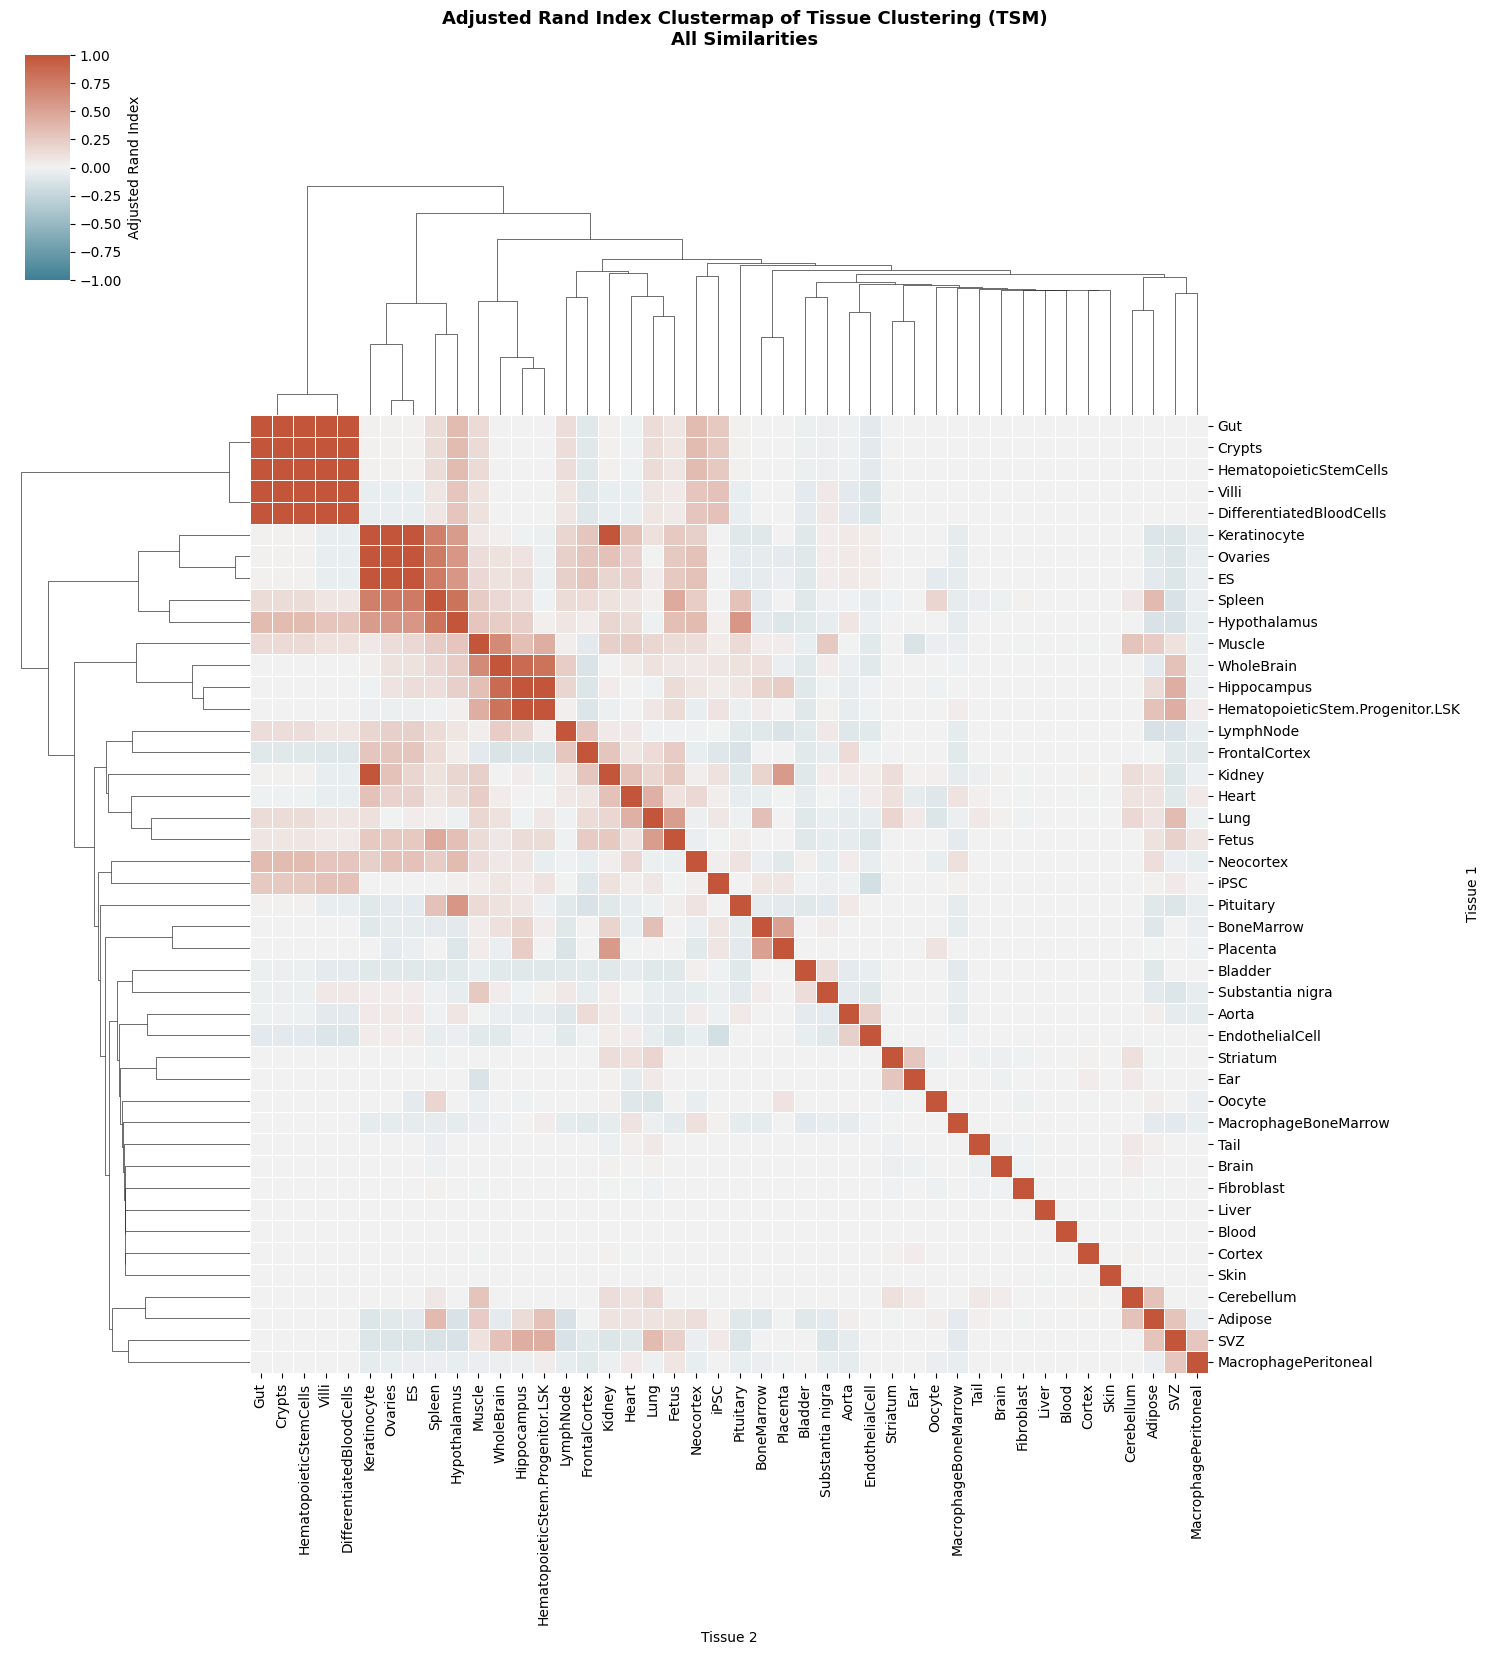

In [173]:
### Clustermap of ALL Similarities grouped by ARIs - TSM

# Create a pivot table for the clustermap
ari_pivot = similarity_results_TSM.pivot(index='Tissue 1', columns='Tissue 2', values='Adjusted Rand Index') # For complete similarity matrix

# Fill NaN values with 1.0 for self-comparisons and ensure symmetry
for tissue in best_models_TSM['Tissue'].unique():
    ari_pivot.loc[tissue, tissue] = 1.0

ari_pivot = ari_pivot.fillna(ari_pivot.T)

# Replace any remaining NaN values with a suitable value (e.g., 0)
ari_pivot = ari_pivot.fillna(0)

# Ensure x and y axis have the tissues in the same order
tissue_order = best_models_TSM['Tissue'].unique()
ari_pivot = ari_pivot.reindex(index=tissue_order, columns=tissue_order)

# Create a custom color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the clustermap
g = sns.clustermap(ari_pivot, 
                   cmap=cmap, 
                   figsize=(15, 15),
                   vmin=-1, vmax=1, 
                   linewidths=.5, 
                   annot=False, fmt='.2f',
                   cbar_kws={'label': 'Adjusted Rand Index', 'orientation': 'vertical', 'pad': 0.02, 'shrink': 0.5},
                   cbar_pos=(0.02, 0.92, 0.03, 0.15),  # Adjust the position of the colorbar [x, y, width, height]
                   xticklabels=ari_pivot.columns,
                   yticklabels=ari_pivot.index)  # Set figure size here

# Rotate the tick labels
plt.setp(g.ax_heatmap.yaxis.get_ticklabels(), rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_ticklabels(), rotation=90)

# Set the title
plt.gcf().suptitle('Adjusted Rand Index Clustermap of Tissue Clustering (TSM)\nAll Similarities', 
                   fontsize=13, 
                   fontweight='bold', 
                   y=1.1  # Adjust the vertical position of the title, 0 is bottom, 1 is top
                   )

plt.show()


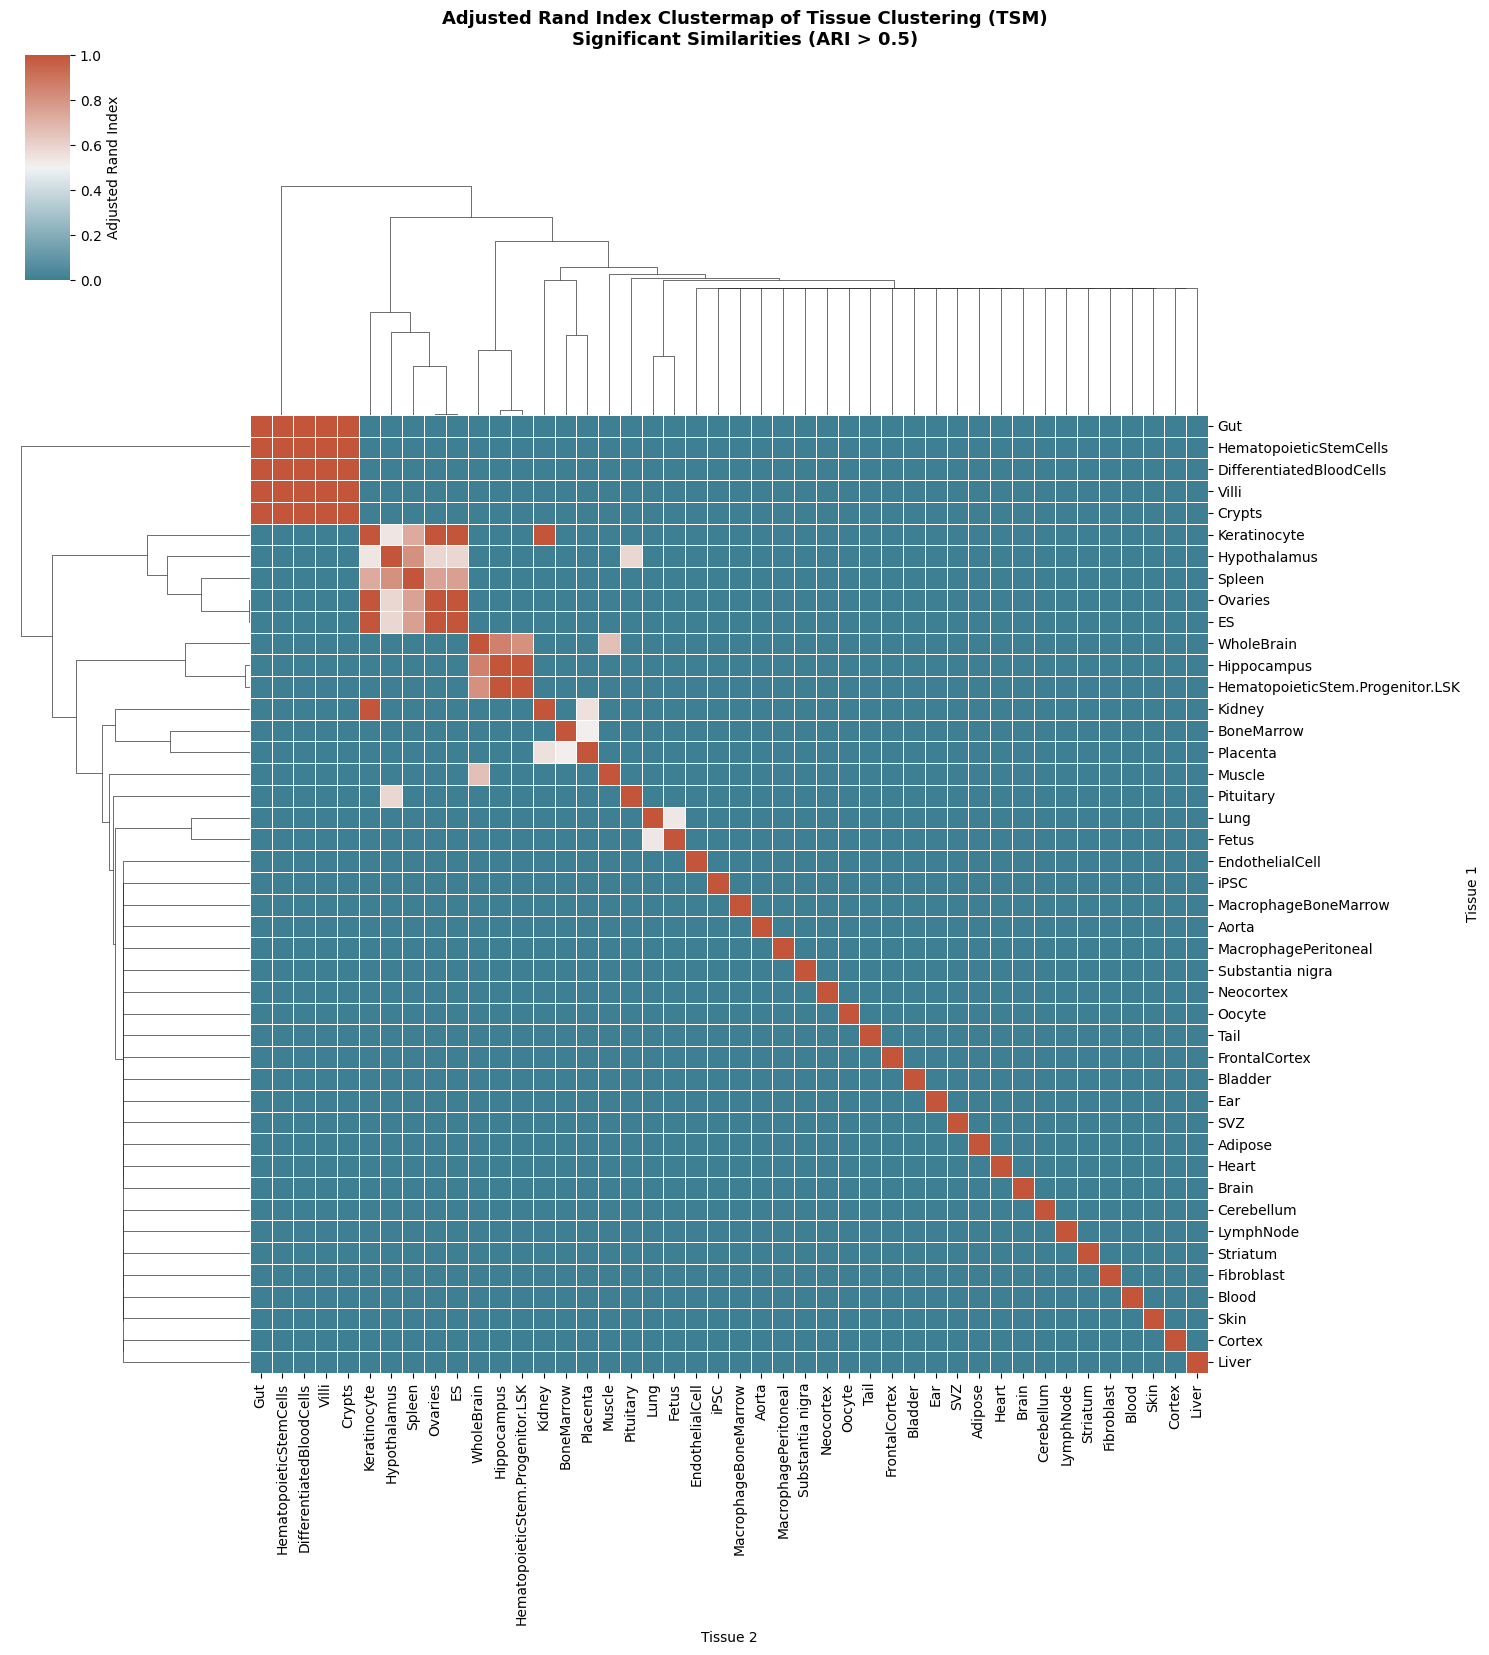

In [179]:
### Clustermap of SIGNIFICANT Similarities grouped by ARIs - TSM

# Create a pivot table for the clustermap
ari_pivot = ari_significant_similarities_TSM.pivot(index='Tissue 1', columns='Tissue 2', values='Adjusted Rand Index') # For significant similarities only

# Fill NaN values with 1.0 for self-comparisons and ensure symmetry
for tissue in best_models_TSM['Tissue'].unique():
    ari_pivot.loc[tissue, tissue] = 1.0

ari_pivot = ari_pivot.fillna(ari_pivot.T)

# Replace any remaining NaN values with a suitable value (e.g., 0)
ari_pivot = ari_pivot.fillna(0)

# Ensure x and y axis have the tissues in the same order
tissue_order = best_models_TSM['Tissue'].unique()
ari_pivot = ari_pivot.reindex(index=tissue_order, columns=tissue_order)

# Create a custom color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the clustermap
g = sns.clustermap(ari_pivot, 
                   cmap=cmap, 
                   figsize=(15, 15),
                   vmin=0, vmax=1, 
                   linewidths=.5, 
                   annot=False, fmt='.2f',
                   cbar_kws={'label': 'Adjusted Rand Index', 'orientation': 'vertical', 'pad': 0.02, 'shrink': 0.5},
                   cbar_pos=(0.02, 0.92, 0.03, 0.15),  # Adjust the position of the colorbar [x, y, width, height]
                   xticklabels=ari_pivot.columns,
                   yticklabels=ari_pivot.index)  # Set figure size here

# Rotate the tick labels
plt.setp(g.ax_heatmap.yaxis.get_ticklabels(), rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_ticklabels(), rotation=90)

# Set the title
plt.gcf().suptitle('Adjusted Rand Index Clustermap of Tissue Clustering (TSM)\nSignificant Similarities (ARI > 0.5)', 
                   fontsize=13, 
                   fontweight='bold', 
                   y=1.1  # Adjust the vertical position of the title, 0 is bottom, 1 is top
                   )

plt.show()


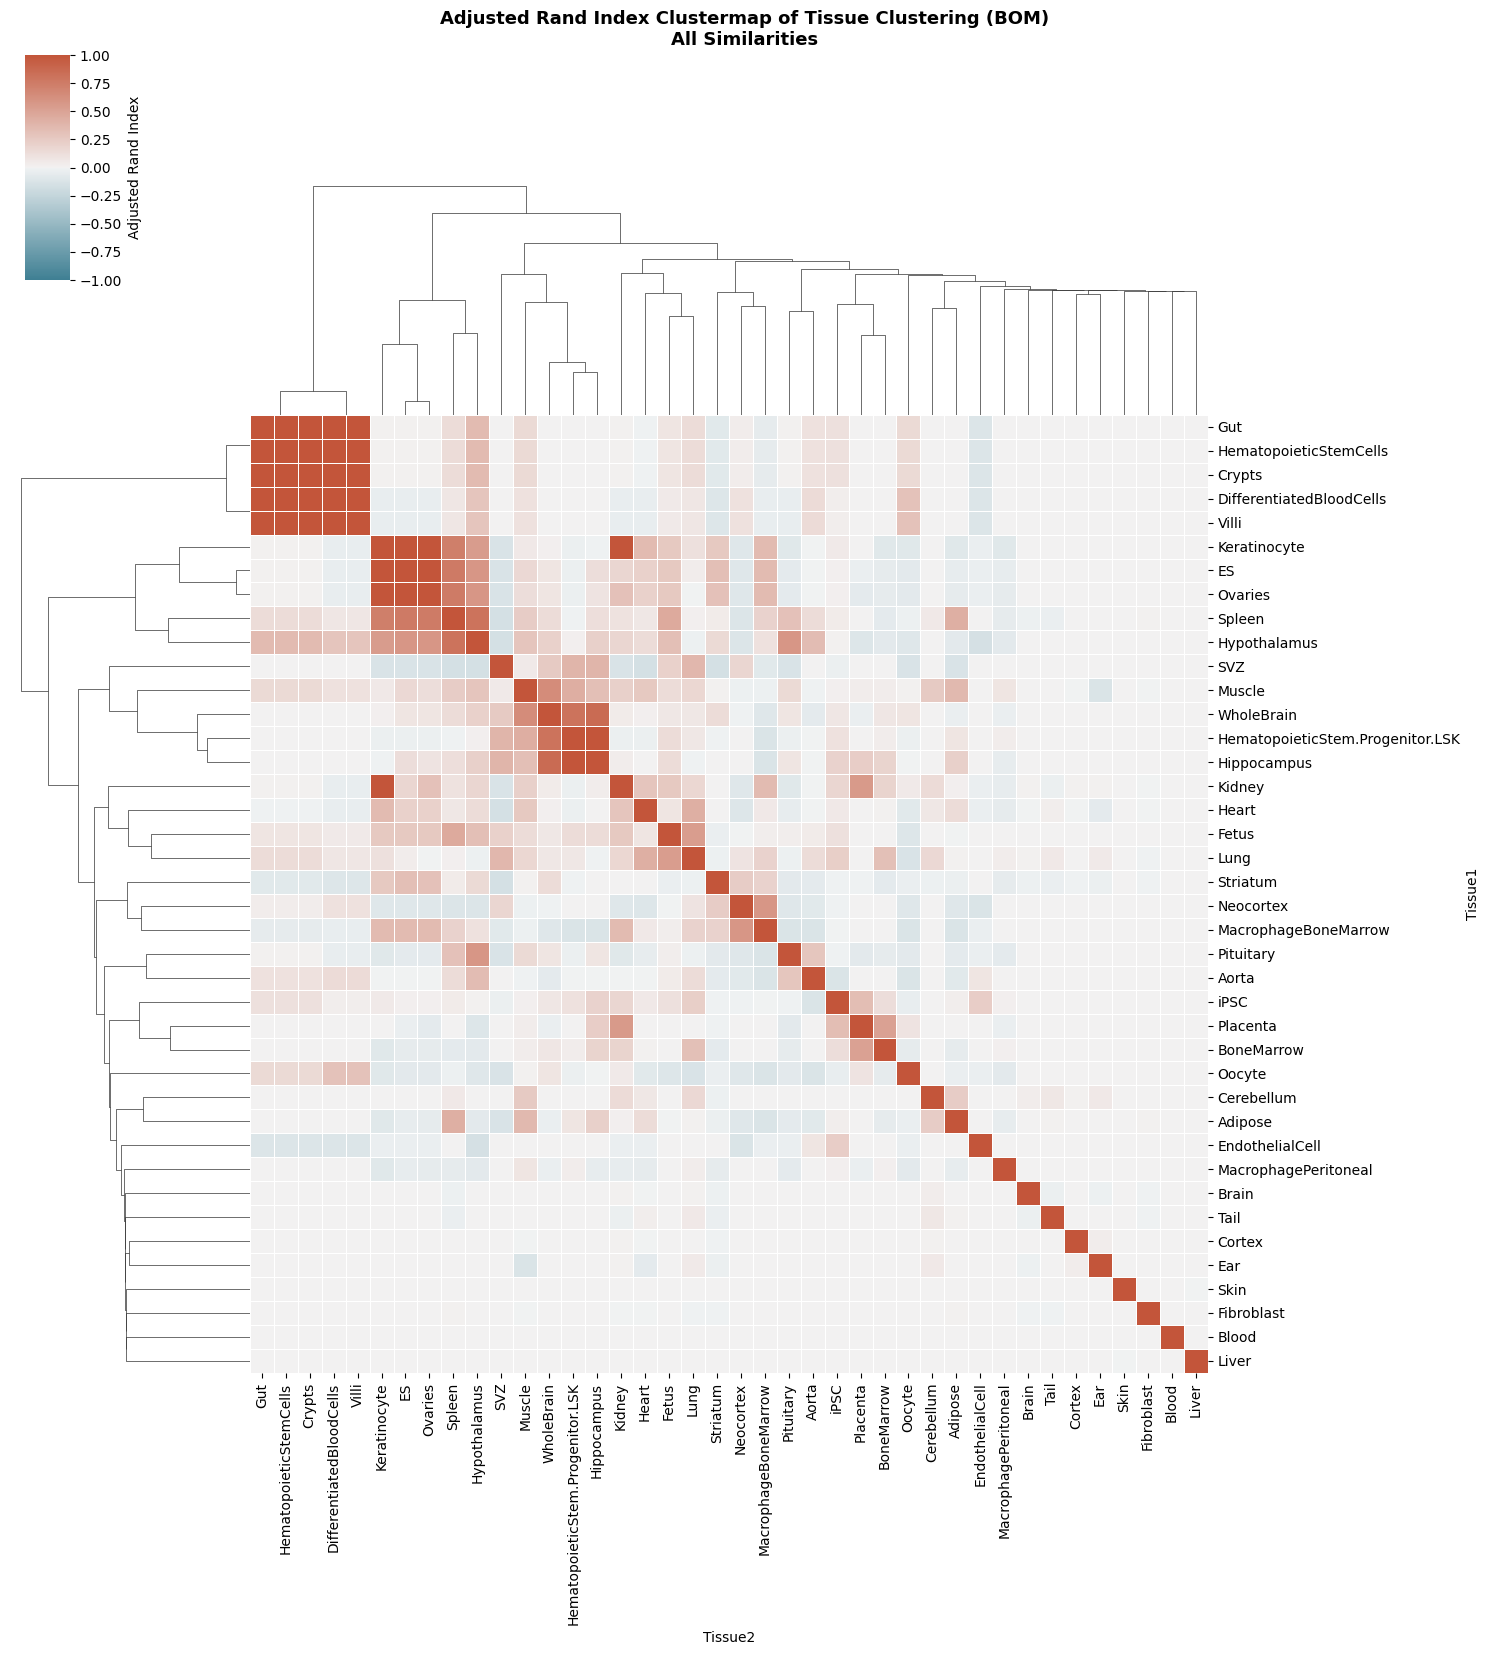

In [180]:
### Clustermap of ALL Similarities grouped by ARIs -BOM

# Create a pivot table for the clustermap
ari_pivot = similarity_results_BOM.pivot(index='Tissue1', columns='Tissue2', values='Adjusted Rand Index') # For all similarities

# Fill NaN values with 1.0 for self-comparisons and ensure symmetry
for tissue in best_model_BOM['Tissue'].unique():
    ari_pivot.loc[tissue, tissue] = 1.0

ari_pivot = ari_pivot.fillna(ari_pivot.T)

# Replace any remaining NaN values with a suitable value (e.g., 0)
ari_pivot = ari_pivot.fillna(0)

# ensure x and y axis have the tissues in the same order
tissue_order = best_model_BOM['Tissue'].unique()
ari_pivot = ari_pivot.reindex(index=tissue_order, columns=tissue_order)

# Create a custom color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)


# Plot the clustermap
g = sns.clustermap(ari_pivot, 
                   cmap=cmap, 
                   figsize=(15, 15),
                   vmin=-1, vmax=1, 
                   linewidths=.5, 
                   annot=False, fmt='.2f',
                   cbar_kws={'label': 'Adjusted Rand Index', 'orientation': 'vertical', 'pad': 0.02, 'shrink': 0.5},
                   cbar_pos=(0.02, 0.92, 0.03, 0.15),  # Adjust the position of the colorbar [x, y, width, height]
                   xticklabels=ari_pivot.columns,
                   yticklabels=ari_pivot.index)  # Set figure size here

# Rotate the tick labels
plt.setp(g.ax_heatmap.yaxis.get_ticklabels(), rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_ticklabels(), rotation=90)

# Set the title
plt.gcf().suptitle('Adjusted Rand Index Clustermap of Tissue Clustering (BOM)\nAll Similarities', 
                   fontsize=13, 
                   fontweight='bold', 
                   y=1.1  # Adjust the vertical position of the title, 0 is bottom, 1 is top
                   )

plt.show()

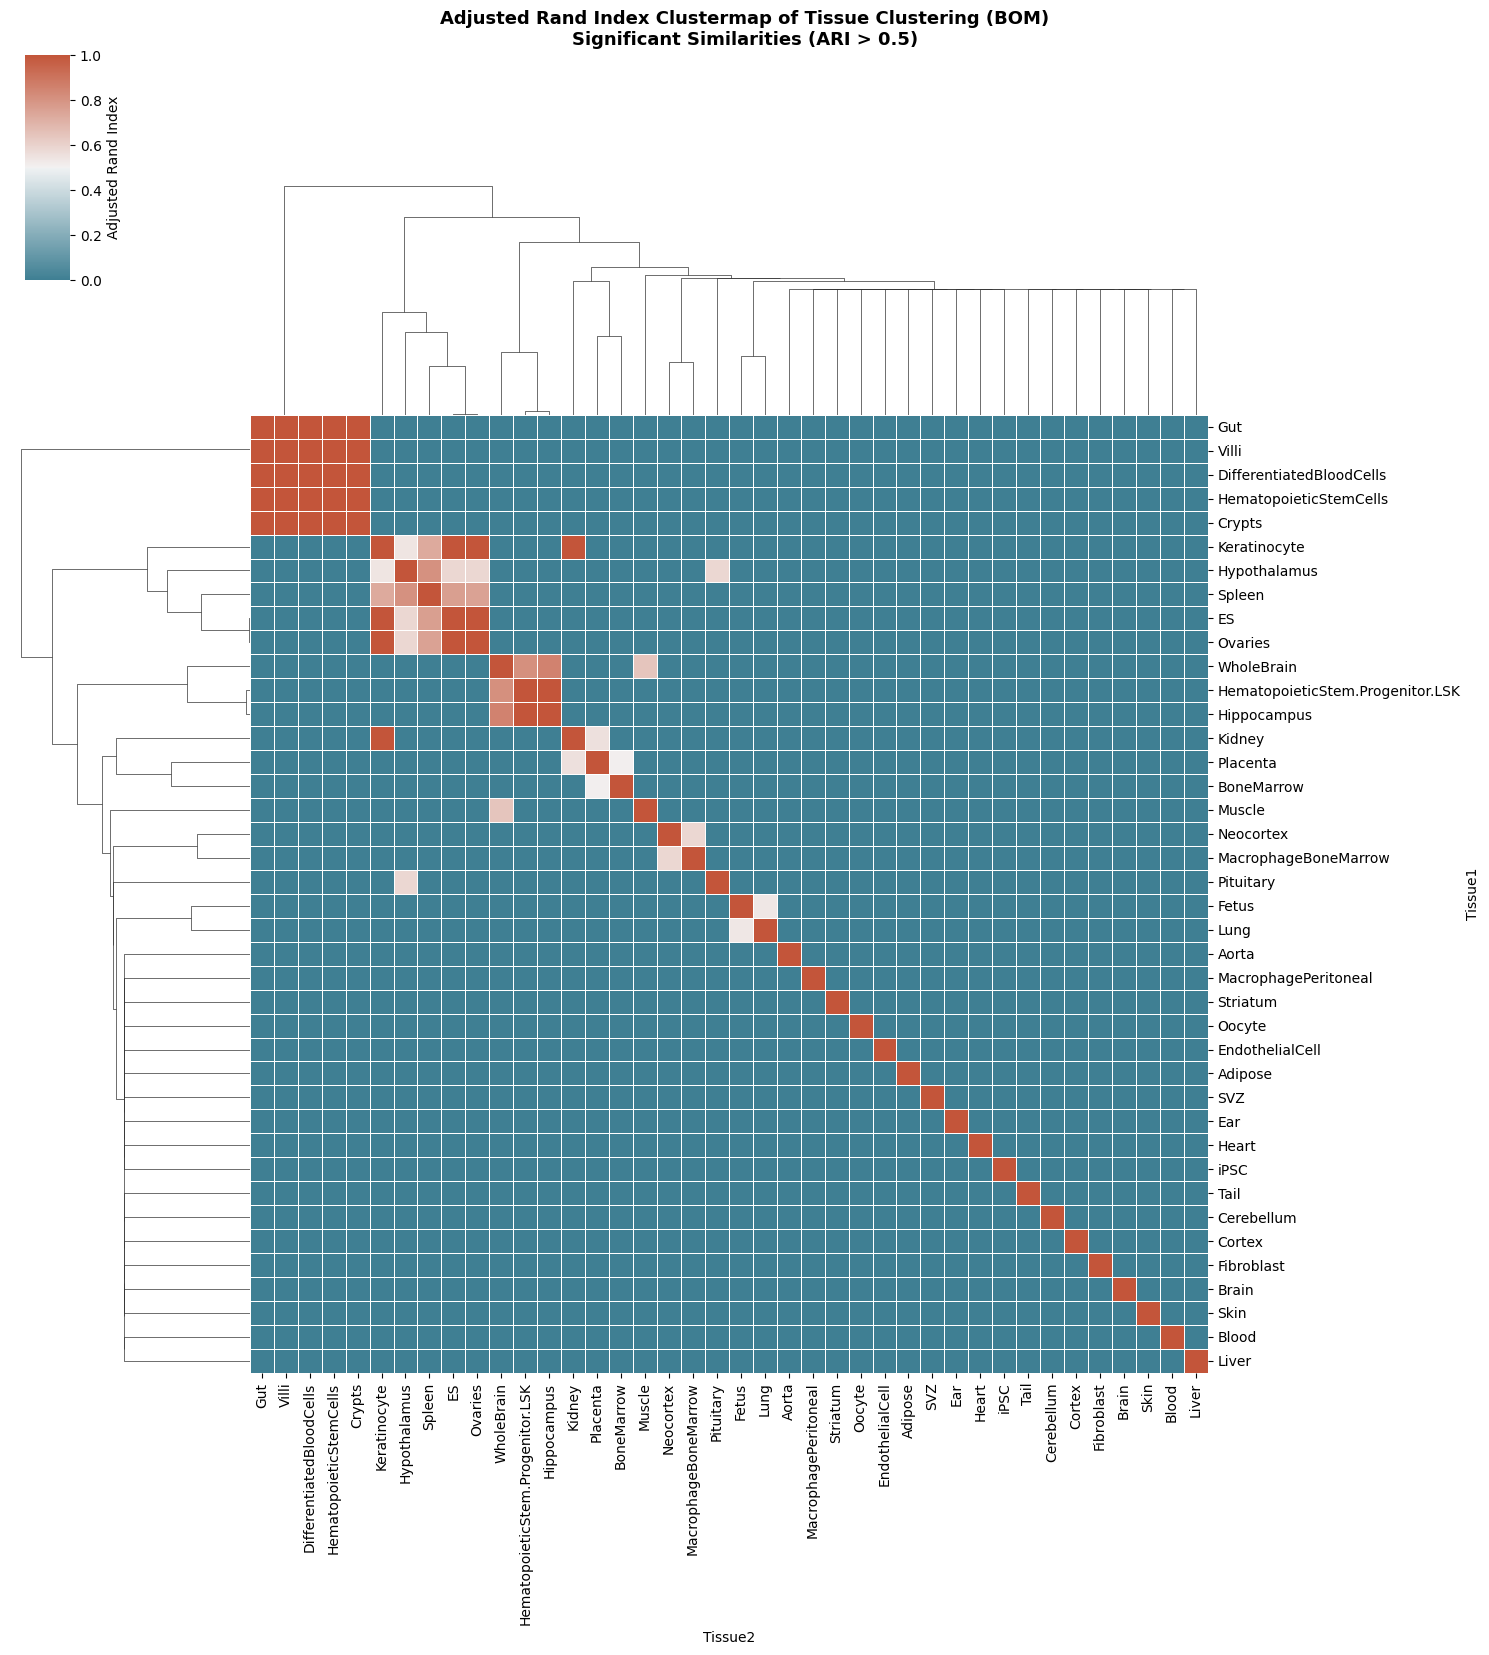

In [182]:
### Clustermap of SIGNIFICANT Similarities grouped by ARIs -BOM

# Create a pivot table for the clustermap
ari_pivot = ari_significant_similarities_BOM.pivot(index='Tissue1', columns='Tissue2', values='Adjusted Rand Index')  # For significant similarities only

# Fill NaN values with 1.0 for self-comparisons and ensure symmetry
for tissue in best_model_BOM['Tissue'].unique():
    ari_pivot.loc[tissue, tissue] = 1.0

ari_pivot = ari_pivot.fillna(ari_pivot.T)

# Replace any remaining NaN values with a suitable value (e.g., 0)
ari_pivot = ari_pivot.fillna(0)

# ensure x and y axis have the tissues in the same order
tissue_order = best_model_BOM['Tissue'].unique()
ari_pivot = ari_pivot.reindex(index=tissue_order, columns=tissue_order)

# Create a custom color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)


# Plot the clustermap
g = sns.clustermap(ari_pivot, 
                   cmap=cmap, 
                   figsize=(15, 15),
                   vmin=0, vmax=1, 
                   linewidths=.5, 
                   annot=False, fmt='.2f',
                   cbar_kws={'label': 'Adjusted Rand Index', 'orientation': 'vertical', 'pad': 0.02, 'shrink': 0.5},
                   cbar_pos=(0.02, 0.92, 0.03, 0.15),  # Adjust the position of the colorbar [x, y, width, height]
                   xticklabels=ari_pivot.columns,
                   yticklabels=ari_pivot.index)  # Set figure size here

# Rotate the tick labels
plt.setp(g.ax_heatmap.yaxis.get_ticklabels(), rotation=0)
plt.setp(g.ax_heatmap.xaxis.get_ticklabels(), rotation=90)

# Set the title
plt.gcf().suptitle('Adjusted Rand Index Clustermap of Tissue Clustering (BOM)\nSignificant Similarities (ARI > 0.5)', 
                   fontsize=13, 
                   fontweight='bold', 
                   y=1.1  # Adjust the vertical position of the title, 0 is bottom, 1 is top
                   )

plt.show()

### 6.3. Important CpGs across all tissues

In [185]:
#### [Deprecated] CpGs relevant in all tissues based on feature scores - Best Overall Method (BOM) [DBSCAN]

# Initialize a list to store feature scores for each tissue
all_feature_scores_BOM = []

# Load feature scores for each tissue
for tissue_name in best_model_BOM['Tissue']:
    # Load the feature scores for the current tissue
    feature_scores_path = os.path.join('./Cluster Analysis/DBSCAN/FEATURE ANALYSIS', f'{tissue_name}_feature_scores.csv')
    feature_scores = pd.read_csv(feature_scores_path)
    
    # Add the tissue name to the feature scores
    feature_scores['Tissue'] = tissue_name
    
    # Append the feature scores to the list
    all_feature_scores_BOM.append(feature_scores)

# Concatenate feature scores into a single DataFrame
combined_feature_scores_BOM = pd.concat(all_feature_scores_BOM)

# Specify the score column to use
score_column_BOM = 'F_Score'

# Identify CpGs relevant in all tissues based on a threshold_BOM (e.g., top 10% of scores)
percentage = 0.99
threshold_BOM = combined_feature_scores_BOM[score_column_BOM].quantile(percentage)
relevant_cpgs_BOM = combined_feature_scores_BOM[combined_feature_scores_BOM[score_column_BOM] >= threshold_BOM]['CpG']

relevant_cpgs_BOM = relevant_cpgs_BOM.unique()

print(f"Relevant CpGs in all tissues based on {score_column_BOM}: {relevant_cpgs_BOM.tolist()}")

Relevant CpGs in all tissues based on F_Score: ['cg02499612', 'cg10061379', 'cg09568652', 'cg18918349', 'cg15991909', 'cg19513247', 'cg19591642', 'cg20185523', 'cg09461098', 'cg05401971', 'cg03370924', 'cg16867657', 'cg06472065', 'cg00362836', 'cg10501210', 'cg12449245', 'cg01019040', 'cg03898602', 'cg11516694', 'cg19358608', 'cg26012482', 'cg01656216', 'cg22264409', 'cg18672716', 'cg17850367', 'cg26614073', 'cg18738190', 'cg06098215', 'cg16599143', 'cg03605454', 'cg23501051', 'cg26311454', 'cg01511232', 'cg26662324', 'cg00687674', 'cg26581729', 'cg00593462', 'cg20804050', 'cg03098892', 'cg24551749', 'cg23931487', 'cg12815291', 'cg18168101', 'cg04211240', 'cg17905888', 'cg08563010', 'cg14381350', 'cg09360996', 'cg17499466', 'cg09622673', 'cg09313705', 'cg01429475', 'cg14811158', 'cg13935553', 'cg00250826', 'cg27547112', 'cg09750164', 'cg04706544', 'cg07938388', 'cg25019875', 'cg15580396', 'cg18094982', 'cg24315421', 'cg05562063', 'cg03185524', 'cg15089111', 'cg18194685', 'cg24058132', 

In [186]:
print(f'Using the best overall model applied to all tissue datasets, the number of relevant CpGs identified based on a threshold of {percentage} was {len(relevant_cpgs_BOM)} out of 335 (Combined: {combined_feature_scores_BOM.shape[0]})')

Using the best overall model applied to all tissue datasets, the number of relevant CpGs identified based on a threshold of 0.99 was 95 out of 335 (Combined: 13400)


In [190]:
#### CpGs relevant in all tissues based on feature scores - Tissue-Specific Models (TSM)

# Initialize a list to store feature scores for each tissue
all_feature_scores_TSM = []

for _, row in best_models_TSM.iterrows():
    tissue_name = row['Tissue']
    best_method = row['Best_Method']
    
    # Set the path based on the best method
    if best_method == 'kmeans':
        feature_scores_path = Path(f'./Cluster Analysis/KM/FEATURE ANALYSIS/{tissue_name}_feature_scores.csv')
    elif best_method == 'hierarchical':
        feature_scores_path = Path(f'./Cluster Analysis/HC/FEATURE ANALYSIS/{tissue_name}_feature_scores.csv')
    elif best_method == 'dbscan':
        feature_scores_path = Path(f'./Cluster Analysis/DBSCAN/FEATURE ANALYSIS/{tissue_name}_feature_scores.csv')

    # Load the feature scores for the current tissues
    if feature_scores_path.exists():
        feature_scores = pd.read_csv(feature_scores_path)
        
        # Add the tissue name to the feature scores
        feature_scores['Tissue'] = tissue_name
        
        # Append the feature scores to the list
        all_feature_scores_TSM.append(feature_scores)
    else:
        print(f"File not found: {feature_scores_path}")

# Concatenate feature scores into a single DataFrame
combined_feature_scores_TSM = pd.concat(all_feature_scores_TSM)

# Specify the score column to use
score_column_TSM = 'F_Score'

# Identify CpGs relevant in all tissues based on a threshold (e.g., top 10% of scores)
percentage = 0.99 # Top 1% of scores
threshold_TSM = combined_feature_scores_TSM[score_column_TSM].quantile(percentage) #
relevant_cpgs_TSM = combined_feature_scores_TSM[combined_feature_scores_TSM[score_column_TSM] >= threshold_TSM]['CpG']

relevant_cpgs_TSM = relevant_cpgs_TSM.unique()

print(f"Relevant CpGs in all tissues based on {score_column_TSM}: {relevant_cpgs_TSM.tolist()}")


Relevant CpGs in all tissues based on F_Score: ['cg02499612', 'cg10061379', 'cg09568652', 'cg18918349', 'cg15991909', 'cg19513247', 'cg19591642', 'cg09461098', 'cg05401971', 'cg03370924', 'cg01019040', 'cg20804050', 'cg03098892', 'cg09750164', 'cg21345677', 'cg04706544', 'cg07938388', 'cg08665685', 'cg17116410', 'cg27228973', 'cg25019875', 'cg15580396', 'cg10603790', 'cg20113482', 'cg18094982', 'cg24315421', 'cg09360996', 'cg10501210', 'cg09025625', 'cg05562063', 'cg03185524', 'cg18194685', 'cg15089111', 'cg09622673', 'cg26012482', 'cg09605634', 'cg16867657', 'cg04051518', 'cg24058132', 'cg10480998', 'cg03564272', 'cg09618893', 'cg00687674', 'cg26418994', 'cg01656216', 'cg03605454', 'cg15746205', 'cg23501051', 'cg26614073', 'cg25184118', 'cg01511232', 'cg26581729', 'cg18738190', 'cg16756969', 'cg03820088', 'cg22264409', 'cg00513357', 'cg00593462', 'cg17357006', 'cg16599143', 'cg17516812', 'cg19098934', 'cg14384416', 'cg17850367', 'cg17633063', 'cg03898602', 'cg14361875', 'cg12841266', 

In [191]:
print(f'Using the best tissue specific model applied to respective dataset, the number of relevant CpGs identified based on a threshold of {percentage} was {len(relevant_cpgs_TSM)} out of 335 (Combined: {combined_feature_scores_TSM.shape[0]})')

Using the best tissue specific model applied to respective dataset, the number of relevant CpGs identified based on a threshold of 0.99 was 99 out of 335 (Combined: 14740)


In [192]:
# check if there are any overlapped CpGs
overlapped_cpgs = set(relevant_cpgs_BOM).intersection(relevant_cpgs_TSM)
print(f"Number of overlapped CpGs between BOM and TSM: {len(overlapped_cpgs)}")

Number of overlapped CpGs between BOM and TSM: 86


In [193]:
# Save the relevant CpGs to a file

folder = 'Cluster Analysis/Relevant CpGs/'
os.makedirs(folder, exist_ok=True)

relevant_cpgs_file = os.path.join(folder, 'relevant_cpgs.csv')
pd.DataFrame(relevant_cpgs_TSM).to_csv(relevant_cpgs_file, index=False)

### 6.4. Clustering of complete dataset with important CpGs only

In [ ]:
# ### Filtering the complete methylation datasets for the relevant CpGs

# important_cpgs = overlapped_cpgs.copy()

# # Filter the complete methylation datasets for the relevant CpGs
# complete_methylation_dataset_importantCpGs_filtered = complete_methylation[complete_methylation['CpG'].isin(important_cpgs)]

# # Display the shape of the filtered dataset
# print(f"Shape of the complete methylation dataset after filtering for relevant CpGs: {complete_methylation_dataset_importantCpGs_filtered.shape}")

# # Display the first few rows of the filtered dataset
# complete_methylation_dataset_importantCpGs_filtered.head()

In [ ]:
### DBSCAN Clustering of the complete methylation dataset filtered by relevant CpGs - TRANSPOSED

# # Results dataframe
# dbscan_results_importantCpGs = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette_score', 'n_clusters', 'core_samples', 'cluster_labels', 'total_features', 'dataset_shape'])

# # dataset
# complete_methylation_dataset_importantCpGs_filtered_transposed = complete_methylation_dataset_importantCpGs_filtered.set_index('CpG').transpose()

# X = complete_methylation_dataset_importantCpGs_filtered_transposed

# # Function to perform DBSCAN on the complete methylation dataset filtered by relevant CpGs
# @delayed
# def dbscan_clustering_importantCpGs(X, eps, min_samples):
#     results = []

#     try:
#         # Perform DBSCAN with current parameters
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         dbscan.fit(X)

#         # Check the number of clusters
#         n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

#         # Check the number of core samples
#         core_samples = np.sum(dbscan.labels_ != -1)

#         # Calculate Silhouette Score
#         if n_clusters > 1:
#             silhouette_avg = silhouette_score(X, dbscan.labels_)
#         else:
#             silhouette_avg = -1

#         # Save the results
#         results.append([eps, min_samples, silhouette_avg, n_clusters, core_samples, dbscan.labels_, X.shape[1], X.shape])

#     except ValueError as e:
#         print(f"Error: {e}")
#         pass

#     return results

# # Prepare delayed functions for each parameter combination
# eps_values = range(4,15)  # Based on the elbow plot
# min_samples_values = range(2, 15)

# tasks = [dbscan_clustering_importantCpGs(X, eps, min_samples) for eps in eps_values for min_samples in min_samples_values]

# # Compute the tasks in parallel
# results_list = compute(*tasks)

# # Combine results
# dbscan_results_importantCpGs_list = [item for sublist in results_list for item in sublist]

# # Convert results list to a DataFrame
# dbscan_results_importantCpGs_df = pd.DataFrame(dbscan_results_importantCpGs_list, columns=['eps', 'min_samples', 'silhouette_score', 'n_clusters', 'core_samples', 'cluster_labels', 'total_features', 'dataset_shape'])

# # Sort results by silhouette score
# dbscan_results_importantCpGs = dbscan_results_importantCpGs_df.sort_values(by='silhouette_score', ascending=False)

# # Display the results
# dbscan_results_importantCpGs.head()

In [ ]:
# ### Scatter plot of DBSCAN clustering of the complete methylation dataset filtered by relevant CpGs - With PCA

# # Get the best results
# best_eps = dbscan_results_importantCpGs['eps'].values[0]
# best_min_samples = dbscan_results_importantCpGs['min_samples'].values[0]
# best_labels = dbscan_results_importantCpGs['cluster_labels'].values[0]

# # Apply PCA to reduce to 2 dimensions
# pca = PCA(n_components=2)

# # Transpose the dataset so that CpGs are columns and samples are rows
# X = complete_methylation_dataset_importantCpGs_filtered_transposed
# X = sc.fit_transform(X)
# X_pca = pca.fit_transform(X)

# # Plot the data
# plt.figure(figsize=(8, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title(f'Complete Methylation Dataset Filtered by Relevant CpGs\nDBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})')
# plt.grid()
# plt.colorbar(label='Cluster Label')
# plt.show()
